In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cupy as cp

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
#from torchvision import datasets, transforms
#import torch.optim as optim

import import_ipynb
import dnn_models
from dnn_models import MLP1L, MLP1L_B, CNN, CNN2D, CNN2DB, CNN2DF

import time

D:\Users\vange\anaconda3\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
model = CNN2DB()

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

print(model)

cuda
CNN2DB(
  (conv1): Conv2d(1, 4, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


In [3]:
class GraphDataset(Dataset):

    def __init__(self, plots, labels, transform=None, transform_label=None):
        self.plots = plots
        self.labels = labels
        self.transform = transform
        self.transform_label = transform_label

    def __getitem__(self, idx):
        label = self.labels[idx]
        plot = self.plots[idx]

        if self.transform:
            plot = self.transform(np.array(plot))

        if self.transform_label:
            label = self.transform_label(np.array(label))

        return plot, label

    def __len__(self):
        return len(self.labels)

In [4]:
def train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer, pretrained_model=False):
    model = model.to(device)
    #initial(curriculum, min_epoch, max_epoch, resume0=False, resume1=False, resume2=False)
    out = directory1
    if not os.path.isdir(out):
        os.makedirs(out)

    out2 = directory2
    if not os.path.isdir(out2):
        os.makedirs(out2)

    path = f"{out}/MLP1L.pt"

    #if resume0 == True:
        #Load log book
        #log = open(os.path.join(out, 'epoch_log.txt'), 'a+')
        #Load lists of training and testing accuracies of the previous run
        #correct = pickle.load(open(os.path.join(out, "correct.pkl"), "rb"))

    if resume0 == True:

        if pretrained_model == False:
          #Load log book
          log = open(os.path.join(out,'epoch_log.txt'),'a+')
          #Load lists of training and testing accuracies of the previous run
          training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))
          testing_accu1 = pickle.load(open(os.path.join(out,"testing_accu1.pkl"),"rb"))
          #Load lists of traininf and testing losses of the previous run
          training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
          testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

          #I need this to assign value to last epoch. Batch size might change and we cannot rely on the iterators
          training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))

        else:
          log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
          log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

          # Initialize lists of losses and accuracies
          training_loss1 = []
          training_accu1 = []
          testing_loss1 = []
          testing_accu1 = []

        #Load the model and the optimizer of the previous run
        saved_model = torch.load(path, weights_only=True)
        model.load_state_dict(saved_model['model_state_dict'])
        optimizer.load_state_dict(saved_model['optimizer_state_dict'])



    elif resume0 == False:
        log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
        log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

        # Initialize lists of losses and accuracies
        training_loss1 = []
        training_accu1 = []
        testing_loss1 = []
        testing_accu1 = []

    test_count = len(test_dataloader)

    time_start = time.time()

    train_count = 0

    rep = 0
    epoch = len(training_accu1)

    while (epoch < max_epoch) and (rep < max_rep):
        if epoch - last_epoch == 0:
            drop_tolerance = -1

        elif epoch - last_epoch <= 10:
            drop_tolerance = max_drop_tolerance

        #elif epoch - last_epoch <= 20:
        #    drop_tolerance = mid_drop_tolerance

        else:
            drop_tolerance = min_drop_tolerance

        size = len(train_dataloader.dataset)
        num_batches = len(train_dataloader)
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        model.train()

        train_loss, train_accu = 0., 0.
        for batch, (X, y) in enumerate(train_dataloader):
            #print(X.shape)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss_fn(pred, y).item()
            #print(pred, y)
            #train_accu += (pred == y).item()
            train_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
            #train_accu += 1/loss_fn(pred, y).item()


            #if batch % 100 == 0:
            #    loss, current = loss.item(), batch * batch_size + len(X)
            #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        training_accu1.append(train_accu/size)
        training_loss1.append(train_loss/num_batches)

        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        model.eval()
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, test_accu = 0., 0.

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in test_dataloader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                #test_accu += (pred == y).item()
                test_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
                #test_accu += 1/loss_fn(pred, y).item()

        testing_accu1.append(test_accu/size)
        testing_loss1.append(test_loss/num_batches)

        """
        drop = float(training_accu1[len(training_accu1)-1]) - float(training_accu1[len(training_accu1)-2])
        #drop = float(training_loss1[len(training_loss1)-1]) - float(training_loss1[len(training_loss1)-2])
        #print(drop)
        #margin = abs(float(training_accu1[len(training_accu1)-1]) - float(testing_accu1[len(training_accu1)-1]))
        #print(drop, drop_tolerance)
        if drop < drop_tolerance: #or margin > margin_tolerance:
            rep += 1
            #Load log book
            log = open(os.path.join(out,'epoch_log.txt'),'a+')
            log.write('We are restarting at epoch {:06d} for {:03d} times \r\n'.format(epoch, rep))
            #Load lists of training and testing accuracies of the previous run
            training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))
            testing_accu1 = pickle.load(open(os.path.join(out,"testing_accu1.pkl"),"rb"))
            #Load lists of training and testing losses of the previous run
            training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
            testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))
            #Load the model and the optimizer of the previous run
            saved_model = torch.load(path, weights_only=True)
            model.load_state_dict(saved_model['model_state_dict'])
            optimizer.load_state_dict(saved_model['optimizer_state_dict'])
            #I need this to assign value to the recent epoch
            #drop_tolerance += drop_tolerance_inc
            epoch = len(training_accu1)
            print(f'{rep:03d}: Restarting...')

        else:
            rep = 0

        #print(f"Test Error: \n Accuracy: {(100*test_accu):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        """

        epoch = len(training_accu1)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss/num_batches
        }, path)

        #Save training data
        pickle.dump(training_loss1,open(os.path.join(out,"training_loss1.pkl"),"wb"))
        pickle.dump(training_accu1,open(os.path.join(out,"training_accu1.pkl"),"wb"))

        #Save testing data
        pickle.dump(testing_loss1,open(os.path.join(out,"testing_loss1.pkl"),"wb"))
        pickle.dump(testing_accu1,open(os.path.join(out,"testing_accu1.pkl"),"wb"))

        time_epoch = time.time() - time_start
        log.write(f'\n Epoch:{epoch:06d} Time elapsed:{time_epoch:0.06f} sec')

        log.flush()
        print(f'Epoch:{epoch:06d} done. Time elapsed:{time_epoch:0.06f} sec. Training Accu: {training_accu1[-1]*100:0.02f}')

        if epoch%save_epoch == 0:
            out3 = f'epoch{epoch:06d}'
            if not os.path.isdir(os.path.join(out2, out3)):
                os.mkdir(os.path.join(out2, out3))

            import shutil
            shutil.copy(os.path.join(out,'MLP1L.pt'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_accu1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_accu1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'epoch_log.txt'),os.path.join(out2,out3))

def train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer):
    model = model.to(device)
    #initial(curriculum, min_epoch, max_epoch, resume0=False, resume1=False, resume2=False)
    out = directory1
    if not os.path.isdir(out):
        os.makedirs(out)

    out2 = directory2
    if not os.path.isdir(out2):
        os.makedirs(out2)

    path = f"{out}/MLP1L.pt"

    #if resume0 == True:
        #Load log book
        #log = open(os.path.join(out, 'epoch_log.txt'), 'a+')
        #Load lists of training and testing accuracies of the previous run
        #correct = pickle.load(open(os.path.join(out, "correct.pkl"), "rb"))

    if resume0 == True:
        #Load log book
        log = open(os.path.join(out,'epoch_log.txt'),'a+')
        #Load lists of training and testing accuracies of the previous run
        training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))
        testing_accu1 = pickle.load(open(os.path.join(out,"testing_accu1.pkl"),"rb"))
        #Load lists of traininf and testing losses of the previous run
        training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
        testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))
        #Load the model and the optimizer of the previous run
        saved_model = torch.load(path, weights_only=True)
        model.load_state_dict(saved_model['model_state_dict'])
        optimizer.load_state_dict(saved_model['optimizer_state_dict'])

        #I need this to assign value to last epoch. Batch size might change and we cannot rely on the iterators
        training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))

    elif resume0 == False:
        log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
        log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

        # Initialize lists of losses and accuracies
        training_loss1 = []
        training_accu1 = []
        testing_loss1 = []
        testing_accu1 = []

    test_count = len(test_dataloader)

    time_start = time.time()

    train_count = 0

    rep = 0
    epoch = len(training_accu1)

    while (epoch < max_epoch) and (rep < max_rep):
        if epoch - last_epoch == 0:
            drop_tolerance = -1

        elif epoch - last_epoch <= 10:
            drop_tolerance = max_drop_tolerance

        #elif epoch - last_epoch <= 20:
        #    drop_tolerance = mid_drop_tolerance

        else:
            drop_tolerance = min_drop_tolerance

        size = len(train_dataloader.dataset)
        num_batches = len(train_dataloader)
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        model.train()

        train_loss, train_accu = 0., 0.
        for batch, (X, y) in enumerate(train_dataloader):
            #print(X.shape)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss_fn(pred, y).item()
            #train_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_accu += 1/(loss_fn(pred, y).item()+1)


            #if batch % 100 == 0:
            #    loss, current = loss.item(), batch * batch_size + len(X)
            #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        training_accu1.append(train_accu/size)
        training_loss1.append(train_loss/num_batches)

        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        model.eval()
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, test_accu = 0., 0.

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in test_dataloader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                #test_accu += (pred.argmax(1) == y).type(torch.float).sum().item()
                test_accu += 1/loss_fn(pred, y).item()

        testing_accu1.append(test_accu/size)
        testing_loss1.append(test_loss/num_batches)

        """
        drop = float(training_accu1[len(training_accu1)-1]) - float(training_accu1[len(training_accu1)-2])
        #drop = float(training_loss1[len(training_loss1)-1]) - float(training_loss1[len(training_loss1)-2])
        #print(drop)
        #margin = abs(float(training_accu1[len(training_accu1)-1]) - float(testing_accu1[len(training_accu1)-1]))
        #print(drop, drop_tolerance)
        if drop < drop_tolerance: #or margin > margin_tolerance:
            rep += 1
            #Load log book
            log = open(os.path.join(out,'epoch_log.txt'),'a+')
            log.write('We are restarting at epoch {:06d} for {:03d} times \r\n'.format(epoch, rep))
            #Load lists of training and testing accuracies of the previous run
            training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))
            testing_accu1 = pickle.load(open(os.path.join(out,"testing_accu1.pkl"),"rb"))
            #Load lists of training and testing losses of the previous run
            training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
            testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))
            #Load the model and the optimizer of the previous run
            saved_model = torch.load(path, weights_only=True)
            model.load_state_dict(saved_model['model_state_dict'])
            optimizer.load_state_dict(saved_model['optimizer_state_dict'])
            #I need this to assign value to the recent epoch
            #drop_tolerance += drop_tolerance_inc
            epoch = len(training_accu1)
            print(f'{rep:03d}: Restarting...')

        else:
            rep = 0


        #print(f"Test Error: \n Accuracy: {(100*test_accu):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        """
        epoch = len(training_accu1)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss/num_batches
        }, path)

        #Save training data
        pickle.dump(training_loss1,open(os.path.join(out,"training_loss1.pkl"),"wb"))
        pickle.dump(training_accu1,open(os.path.join(out,"training_accu1.pkl"),"wb"))

        #Save testing data
        pickle.dump(testing_loss1,open(os.path.join(out,"testing_loss1.pkl"),"wb"))
        pickle.dump(testing_accu1,open(os.path.join(out,"testing_accu1.pkl"),"wb"))

        time_epoch = time.time() - time_start
        log.write(f'\n Epoch:{epoch:06d} Time elapsed:{time_epoch:0.06f} sec')

        log.flush()
        print(f'Epoch:{epoch:06d} done. Time elapsed:{time_epoch:0.06f} sec. Training loss: {training_loss1[-1]*100:0.02f}')

        if epoch%save_epoch == 0:
            out3 = f'epoch{epoch:06d}'
            if not os.path.isdir(os.path.join(out2, out3)):
                os.mkdir(os.path.join(out2, out3))

            import shutil
            shutil.copy(os.path.join(out,'MLP1L.pt'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_accu1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_accu1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'epoch_log.txt'),os.path.join(out2,out3))

In [5]:
def graph_accu(file_name, save_fig=False):
    training_accu1 = pickle.load(open(os.path.join(out,"training_accu1.pkl"),"rb"))
    testing_accu1 = pickle.load(open(os.path.join(out,"testing_accu1.pkl"),"rb"))

    print(f'Curriculum:{curriculum:02d}', 'Batchsize:{batchsize}')
    print(f'last epoch: {len(training_accu1)}')
    print(f'Training Accuracy: {training_accu1[-1]*100:.2f}%')
    print(f'Testing Accuracy: {testing_accu1[-1]*100:.2f}%')

    #Convert to CuPy arrays and then to NumPy arrays
    training_accu1 = cp.array(training_accu1).get()
    testing_accu1 = cp.array(testing_accu1).get()

    plt.rcParams.update({'font.size': 12, 'font.family':'serif', 'font.weight':'light'})
    fig = plt.figure(figsize=(12, 6), dpi=300)
    test = plt.plot(testing_accu1,'orange', label='Test')
    train = plt.plot(training_accu1,'blue', label ='Train')
    plt.title(f'{file_name} Accuracy',fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    # Set x-axis ticks at intervals of 100
    tick_positions = range(0, len(testing_accu1), 20)
    plt.xticks(tick_positions, fontsize=12)

    # Set x-axis tick labels at intervals of 200
    tick_labels = [str(i) if i % 100 == 0 else '' for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, fontsize=12)

    # Set x-axis limits to ensure 0 is not offset
    plt.ylim(0,1.05)
    plt.xlim(0, len(testing_accu1))

    plt.grid(True)
    plt.legend()
    if save_fig:
        plt.savefig(f'{file_name}_accuracy.png')

    plt.show()

In [6]:
def graph_loss(file_name, save_fig=False):
    training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
    testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

    print(f'Curriculum:{curriculum:02d}', 'Batchsize:{batchsize}')
    print(f'last epoch: {len(training_loss1)}')
    print(f'Training Loss: {training_loss1[-1]:.2f}%')
    print(f'Testing Loss: {testing_loss1[-1]:.2f}%')

    #Convert to CuPy arrays and then to NumPy arrays
    training_loss1 = cp.array(training_loss1).get()
    testing_loss1 = cp.array(testing_loss1).get()

    fig = plt.figure(figsize=(12, 6), dpi=300)
    test = plt.plot(testing_loss1,'orange', label='Testing Loss')
    train = plt.plot(training_loss1,'blue', label ='Training Loss')
    plt.title(f'{file_name} Loss',fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    # Set x-axis ticks at intervals of 100
    tick_positions = range(0, len(testing_loss1), 20)
    plt.xticks(tick_positions, fontsize=10)

    # Set x-axis tick labels at intervals of 200
    tick_labels = [str(i) if i % 100 == 0 else '' for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, fontsize=10)

    plt.ylim(0,max(testing_loss1))
    # Set x-axis limits to ensure 0 is not offset
    plt.xlim(0, len(testing_loss1))

    plt.grid(True)
    plt.legend()
    if save_fig:
        plt.savefig(f'{file_name}_loss.png')

    plt.show()

# Lambda(1405) Full Training

In [7]:
curriculum = 1

#directory = f"250118_lambda_1405_full_curriculum{curriculum:02d}"
directory = f"250219_lambda-1405_full_curriculum{curriculum:02d}"
#directory = f"250209_lambda-1405_binary_curriculum{curriculum:02d}"

train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)

test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)

train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
#train_labels = torch.from_numpy(train_labels).type(torch.float).to(device)

test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)
#test_labels = torch.from_numpy(test_labels).type(torch.float).to(device)

print(len(test_labels))

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batchsize = 128

train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

8000


In [8]:
#model = CNN2DB()
model = CNN2D()
#model = MLP1L()
#model = CNN2DR()

learning_rate = 1e-3
#Set minibatch size
#batchsize = 32 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#pretrained_model = False

resume0 = True
resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 499#31070  1#31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = False

#Set maximum epoch of the full training
max_epoch = 500 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.005
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 1

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = f"250219_lambda-1405_full_curriculum{curriculum:02d}"
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'250219_lambda_curriculum{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'250219_lambda_curriculum{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum-1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'250219_lambda_curriculum{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer, pretrained_model=resume2)
#train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000500 done. Time elapsed:5.291113 sec. Training Accu: 93.06


Curriculum:01 Batchsize:{batchsize}
last epoch: 500
Training Accuracy: 93.06%
Testing Accuracy: 93.05%


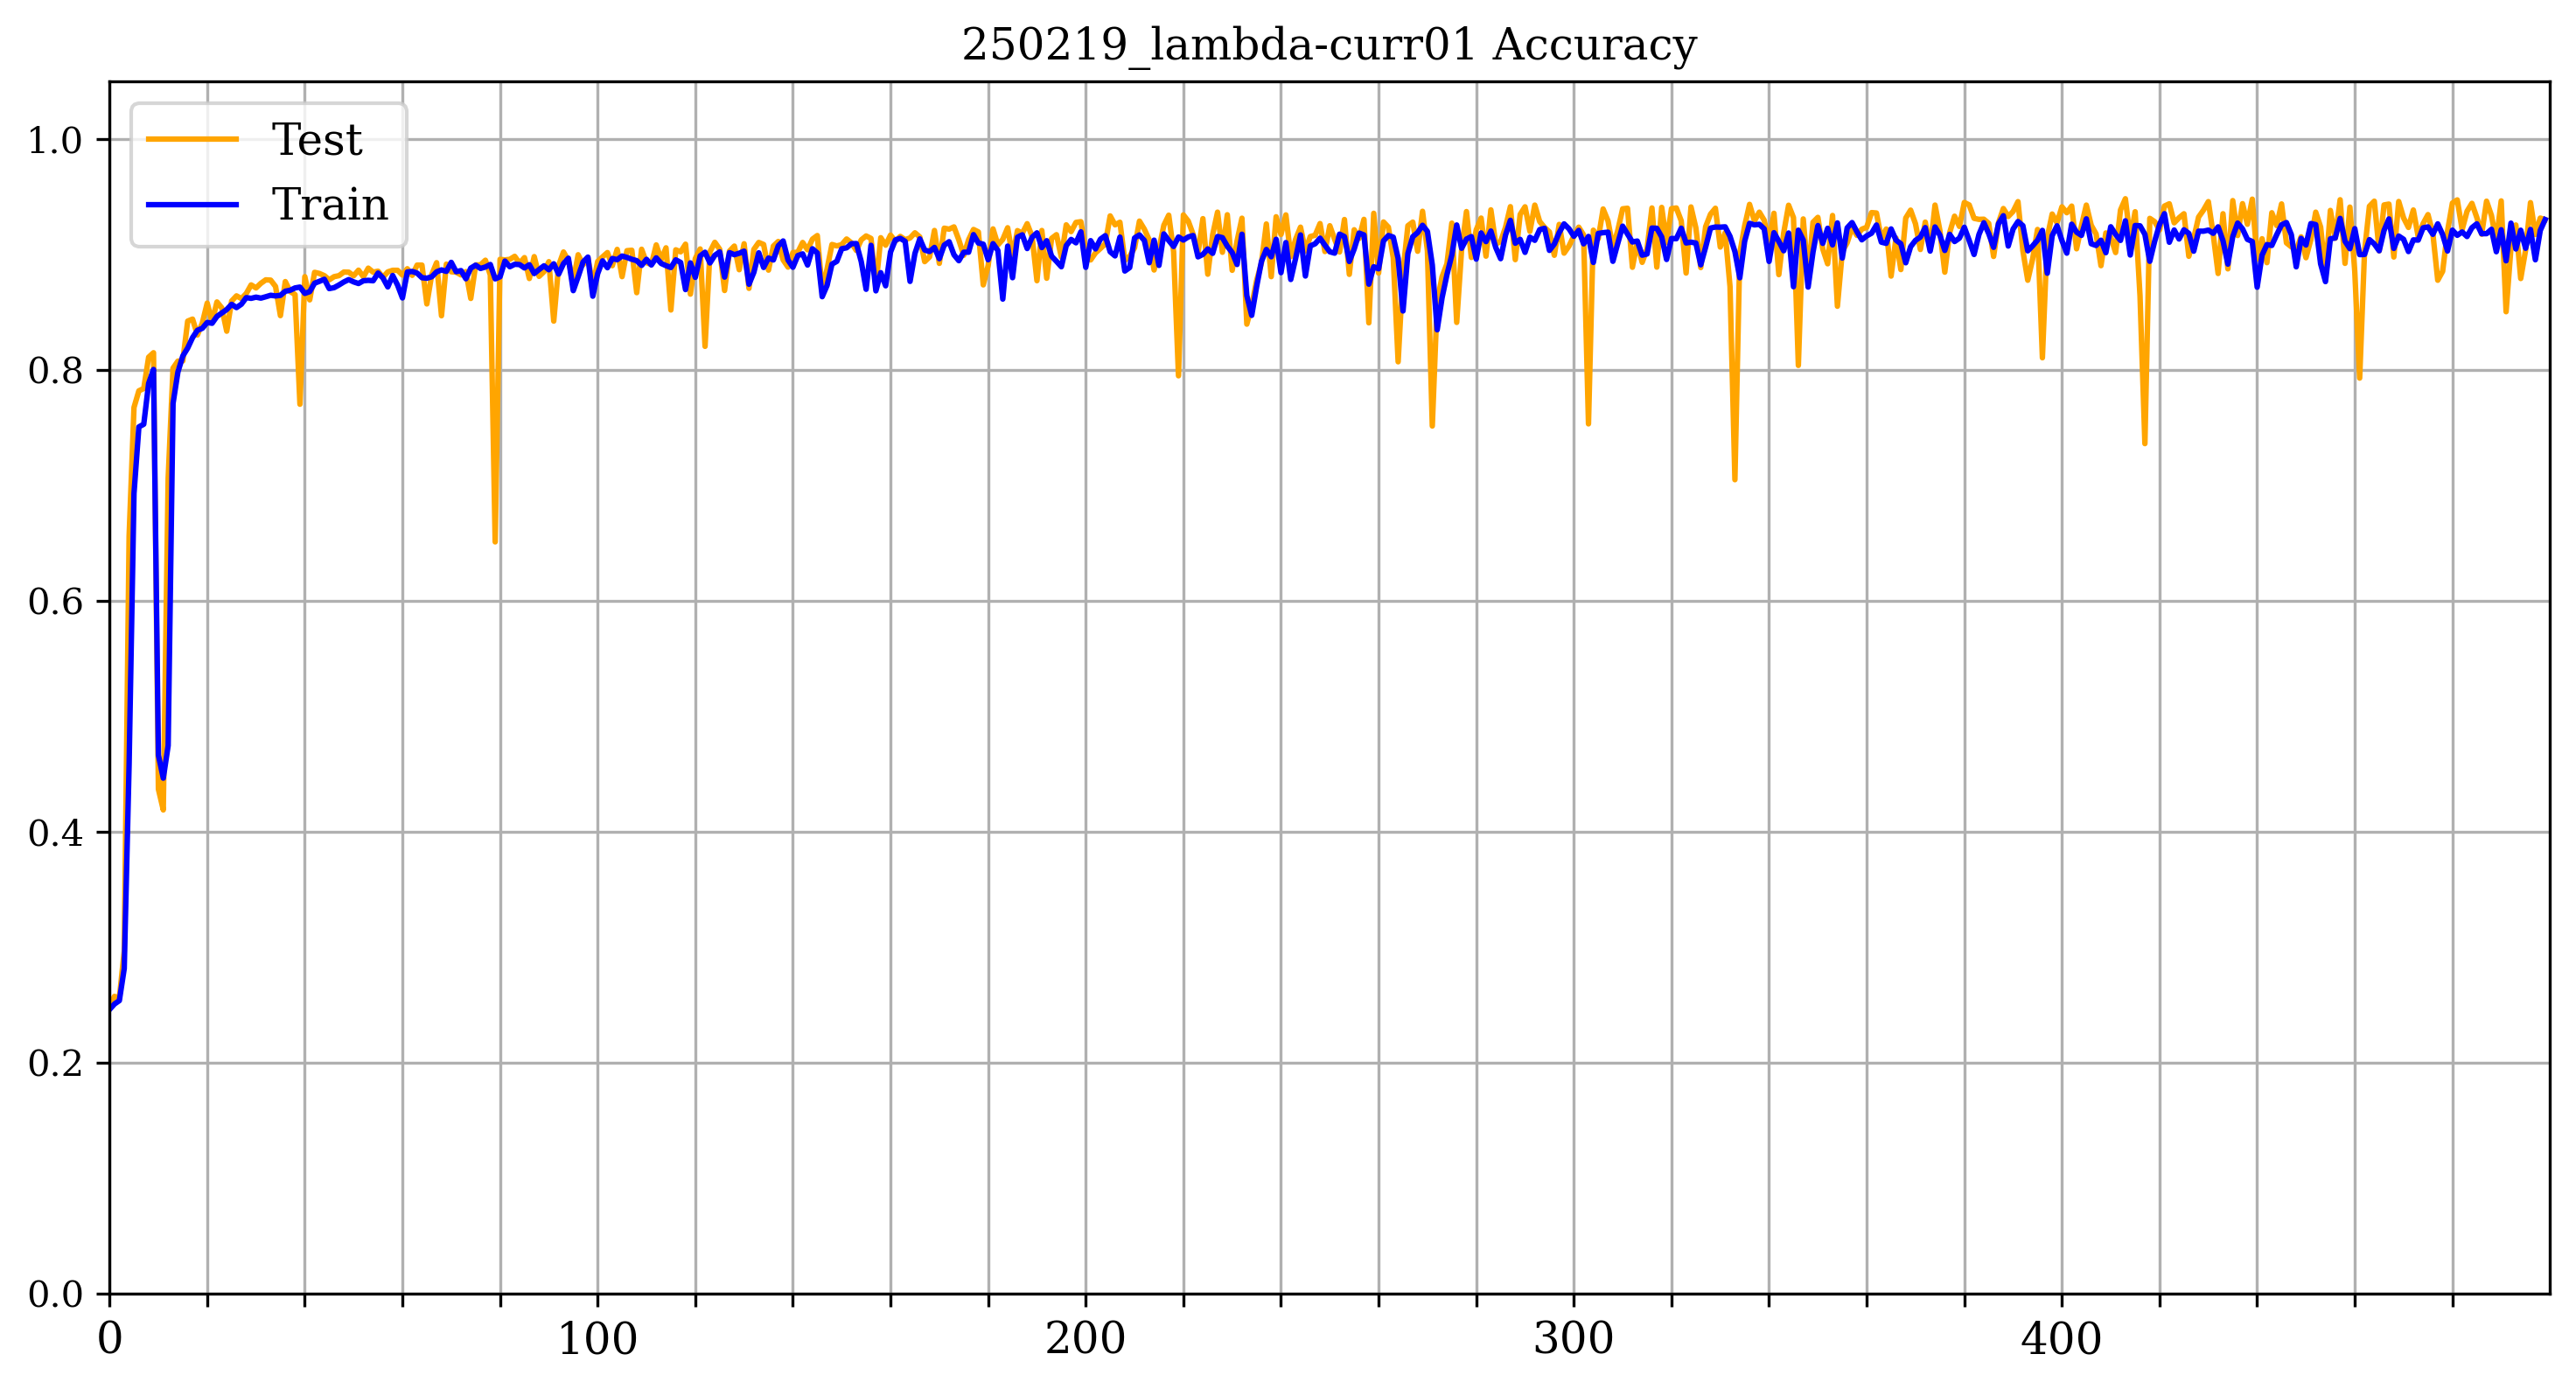

In [9]:
graph_accu(f'250219_lambda-curr{curriculum:02d}', save_fig=True)

Curriculum:01 Batchsize:{batchsize}
last epoch: 500
Training Loss: 0.13%
Testing Loss: 0.12%


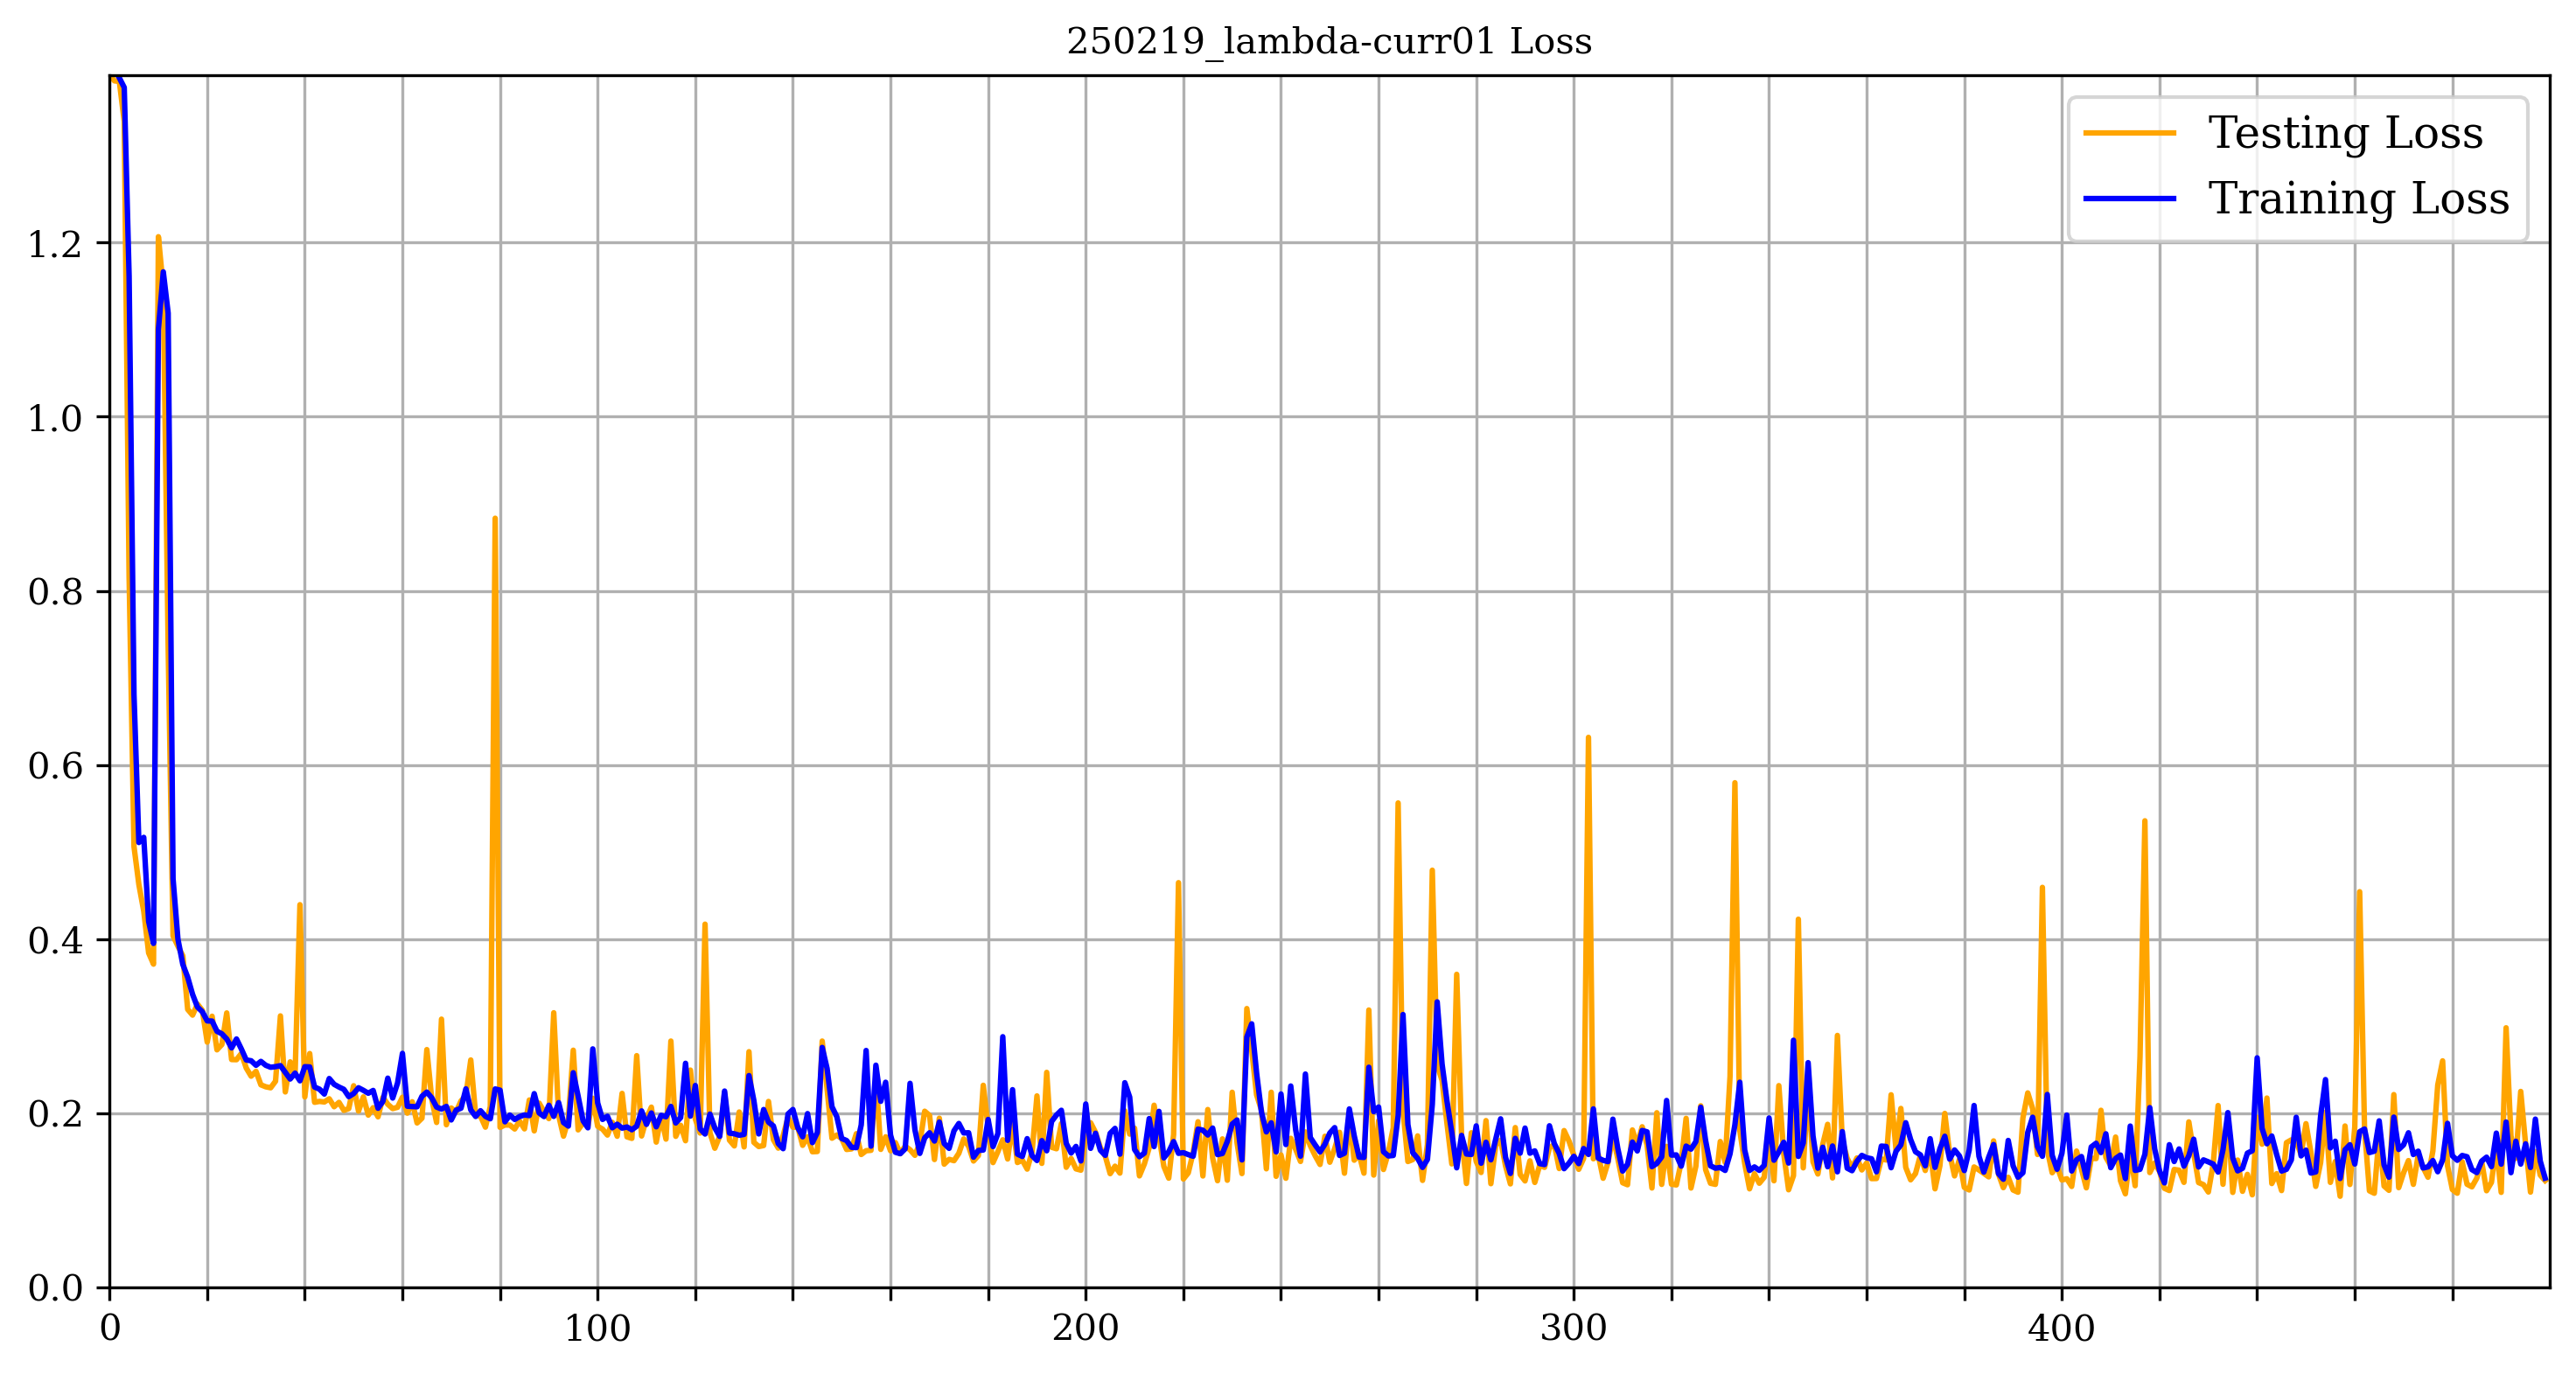

In [10]:
graph_loss(f'250219_lambda-curr{curriculum:02d}', save_fig=True)

# HADRON2025 Training


In [ ]:
curriculum = 16
directory = f"lambda1405full_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 16

model = CNN2DF()
#model = MLP1L()
#model = CNN2D()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 0 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 2000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'CNN2D-13_Adam-0_25-01-15_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'CNN2D-13_Adam-0_25-01-15_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'CNN2D-13_Adam-0_25-01-15_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer)
#train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.565000 sec. Training Accu: 7.51
Epoch:000002 done. Time elapsed:1.049999 sec. Training Accu: 7.39
Epoch:000003 done. Time elapsed:1.541999 sec. Training Accu: 7.40
Epoch:000004 done. Time elapsed:2.030002 sec. Training Accu: 7.65
Epoch:000005 done. Time elapsed:2.538998 sec. Training Accu: 7.94
Epoch:000006 done. Time elapsed:3.091146 sec. Training Accu: 7.67
Epoch:000007 done. Time elapsed:3.618898 sec. Training Accu: 7.69
Epoch:000008 done. Time elapsed:4.149900 sec. Training Accu: 7.69
Epoch:000009 done. Time elapsed:4.691899 sec. Training Accu: 7.69
Epoch:000010 done. Time elapsed:5.218897 sec. Training Accu: 7.69
Epoch:000011 done. Time elapsed:5.870655 sec. Training Accu: 7.69
Epoch:000012 done. Time elapsed:6.399655 sec. Training Accu: 7.69
Epoch:000013 done. Time elapsed:6.903658 sec. Training Accu: 7.50
Epoch:000014 done. Time elapsed:7.435658 sec. Training Accu: 7.41
Epoch:000015 done. Time elapsed:8.124659 sec. Training Accu: 7.60
Epoch:0000

KeyboardInterrupt: 

Curriculum:16 Batchsize:{batchsize}
last epoch: 2000
Training Accuracy: 75.68%
Testing Accuracy: 73.25%


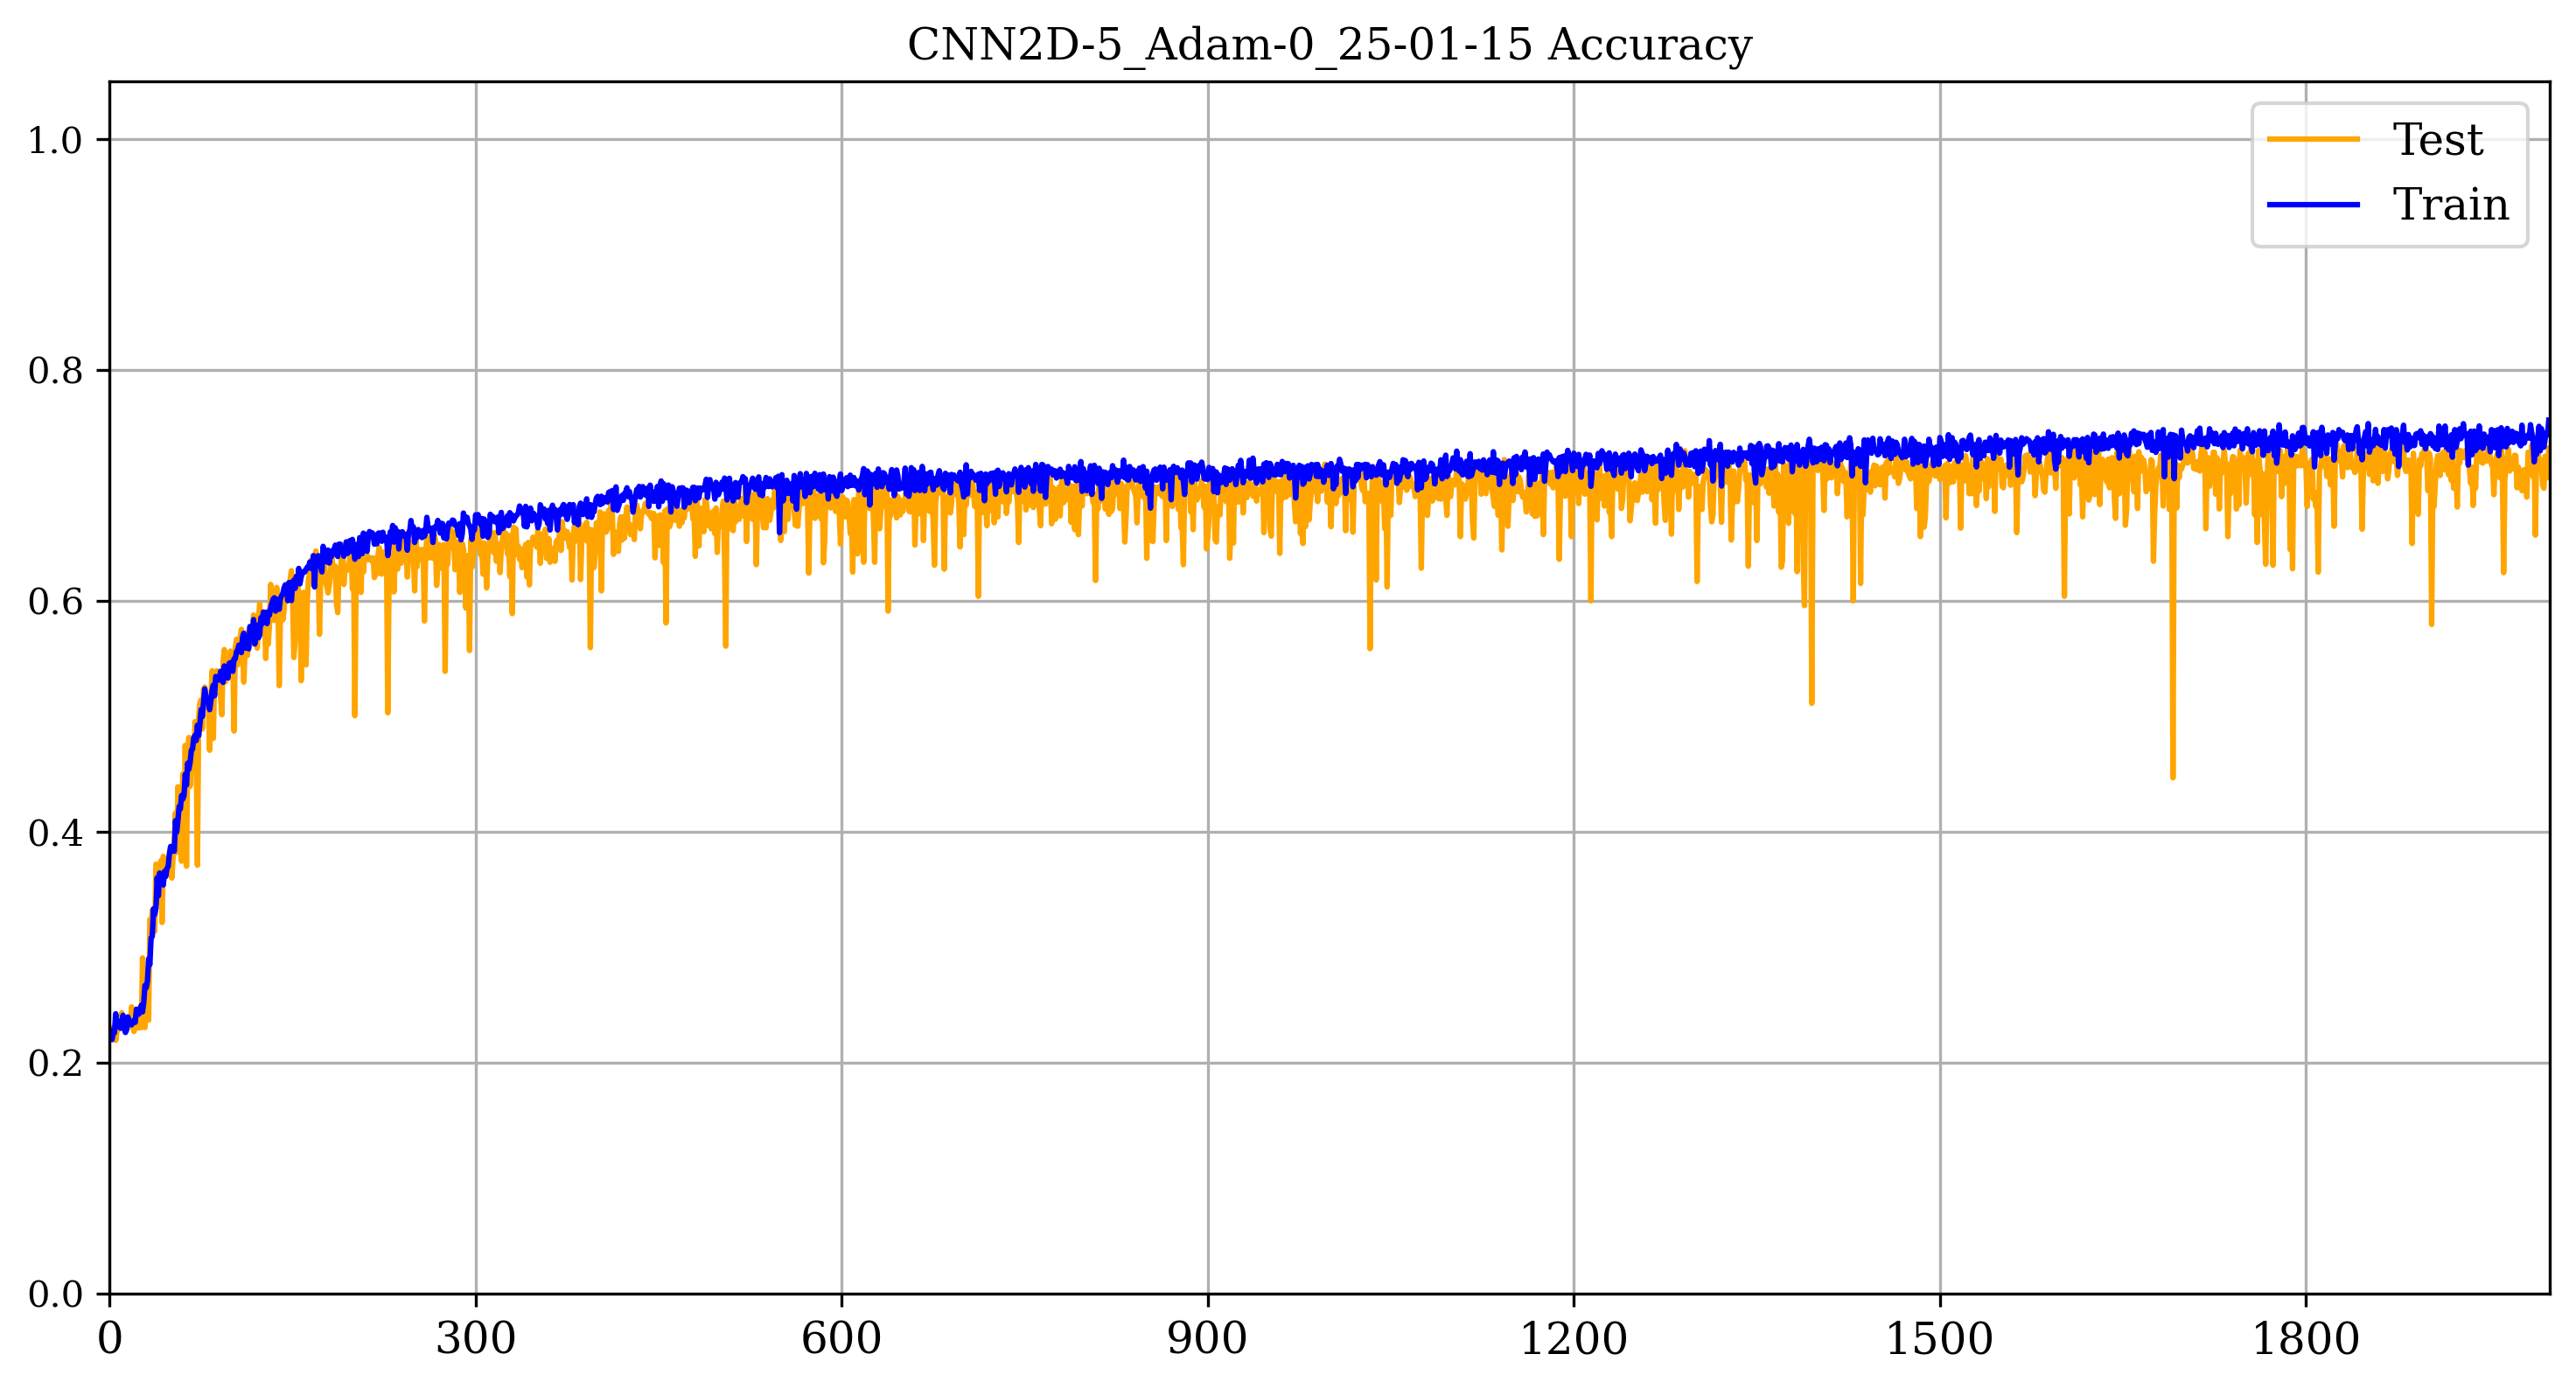

In [ ]:
out = f'CNN2D-5_Adam-0_25-01-15_full'
graph_accu('CNN2D-5_Adam-0_25-01-15', save_fig=True)

Curriculum:16 Batchsize:{batchsize}
last epoch: 2000
Training Loss: 59.30%
Testing Loss: 67.04%


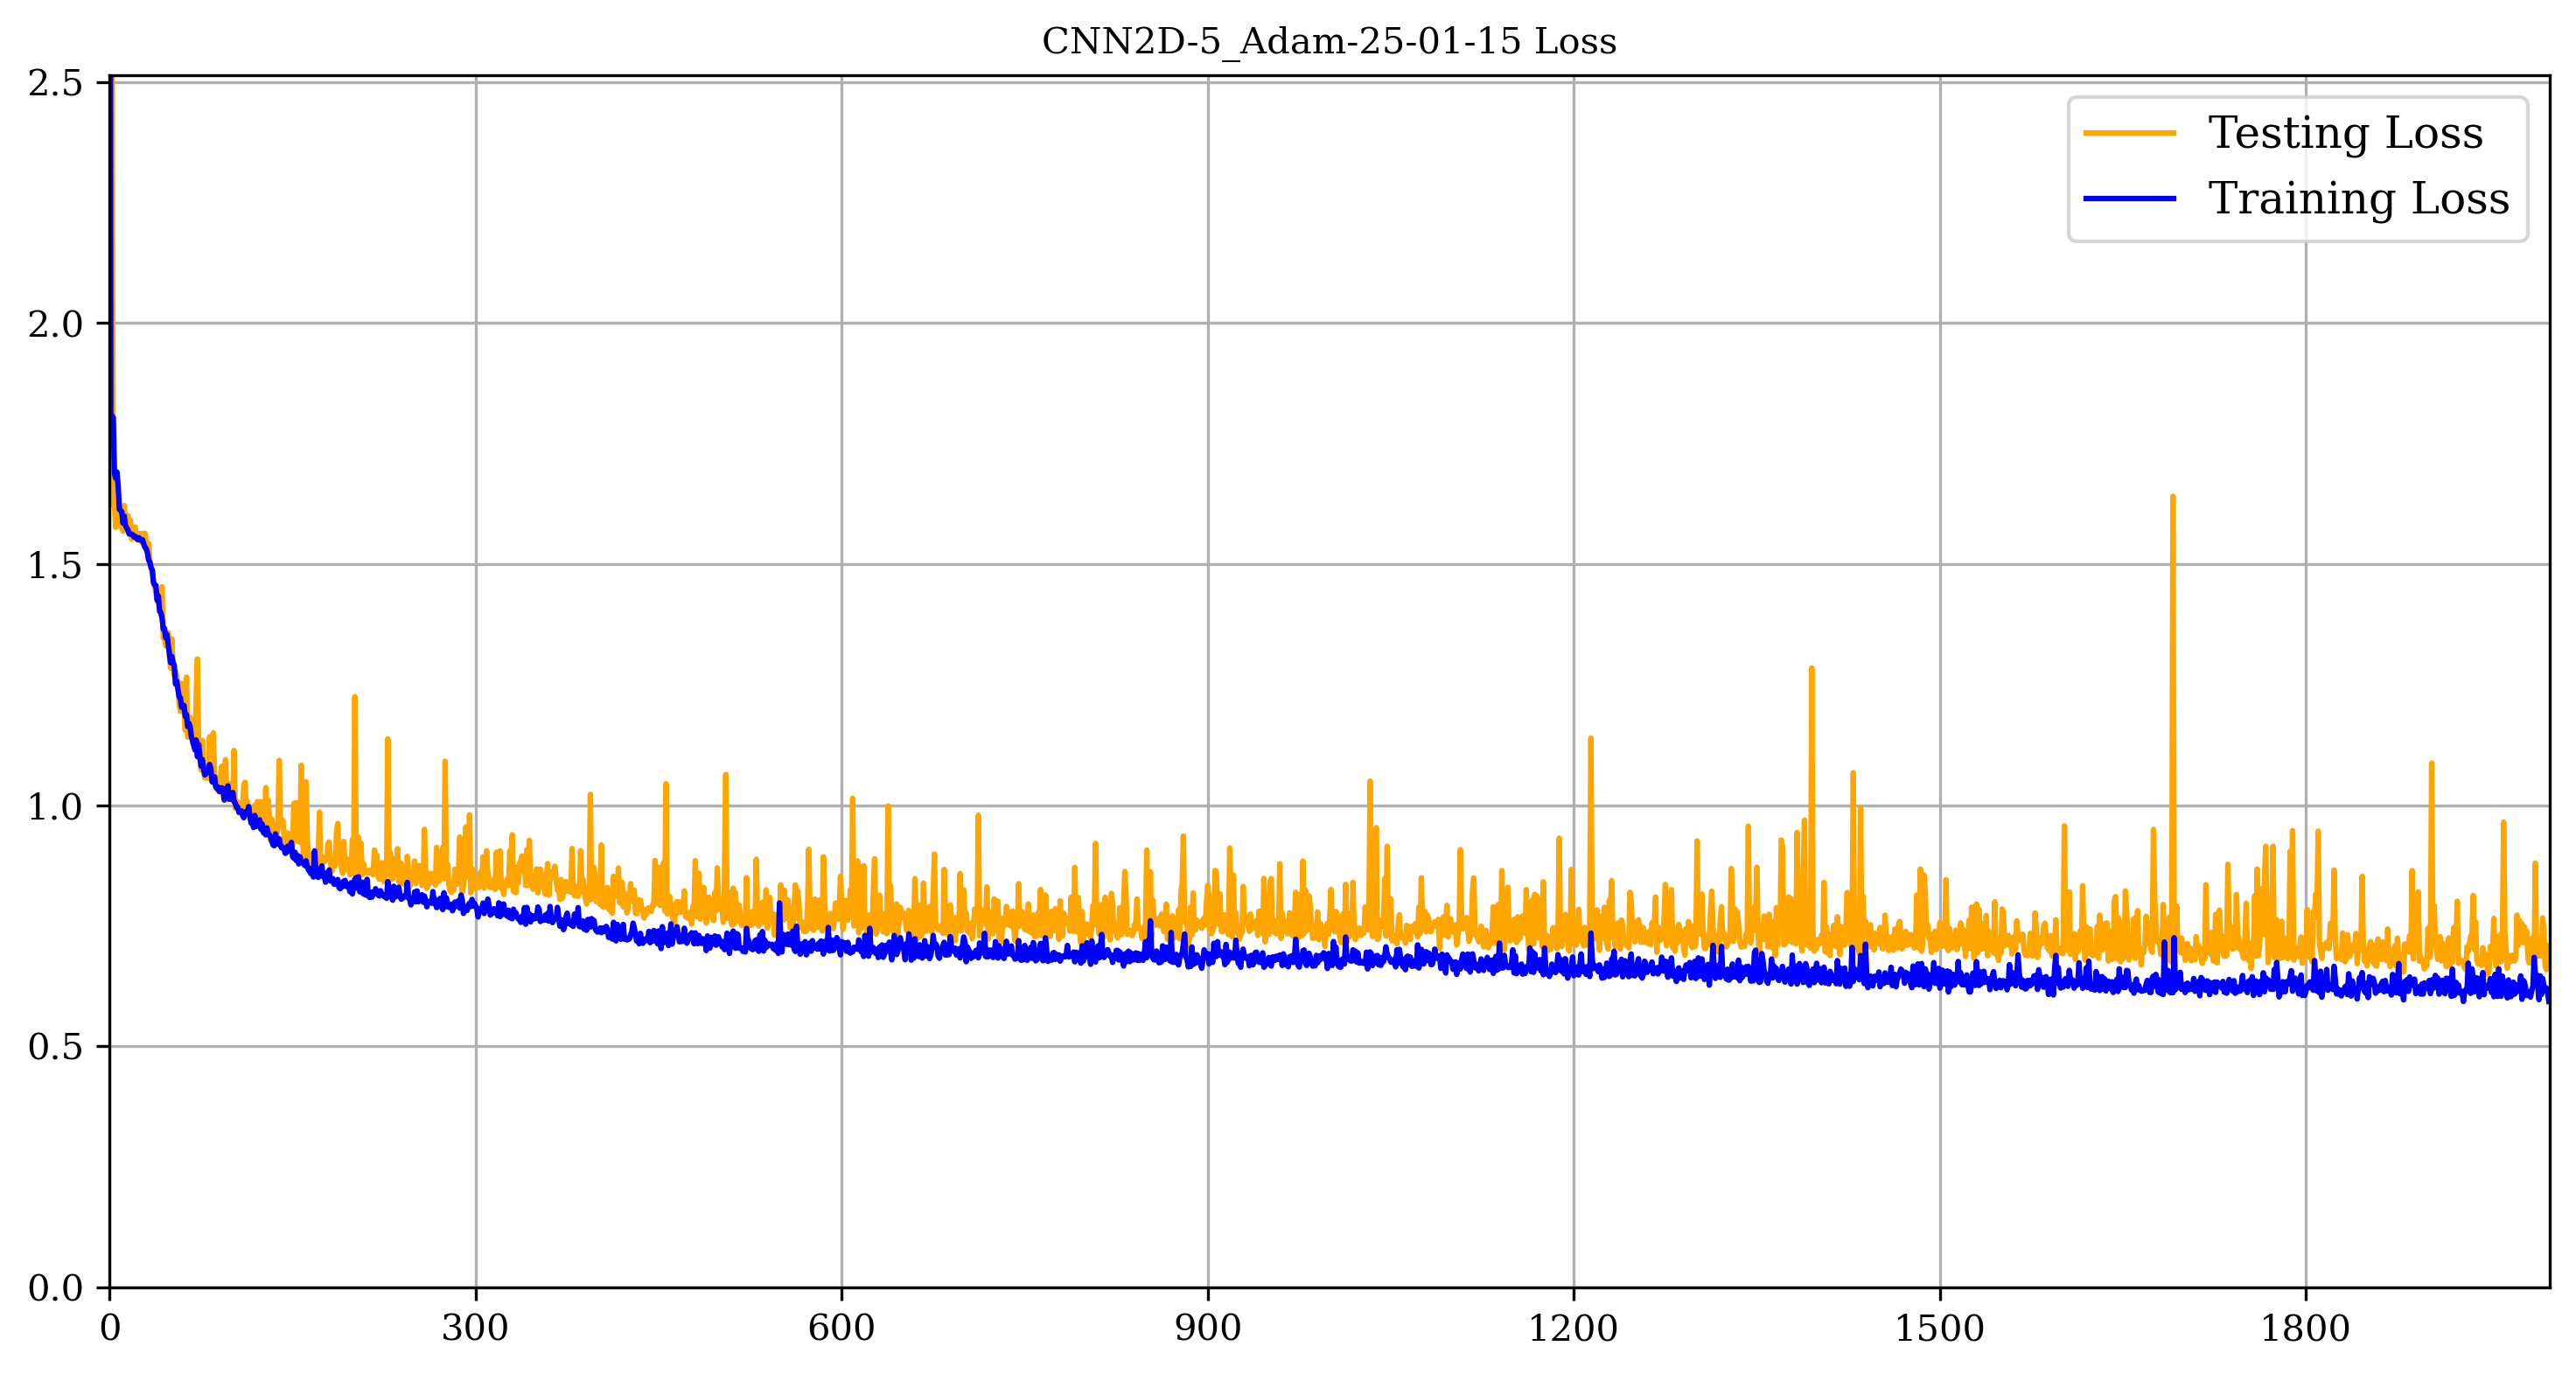

In [ ]:
out = f'CNN2D-5_Adam-0_25-01-15_full'
graph_loss('CNN2D-5_Adam-25-01-15')

Now, this is the training for datasets with random phase and strengths

In [ ]:
curriculum = 12
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 12

#model = CNN2DF()
#model = MLP1L()
model = CNN2D()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 0 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 1000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'CNN2D-5_Adam-1_24-12-22_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'CNN2D-5_Adam-1_24-12-22_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'CNN2D-5_Adam-1_24-12-22_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer)
#train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.629005 sec. Training Accu: 22.92
Epoch:000002 done. Time elapsed:1.219000 sec. Training Accu: 23.04
Epoch:000003 done. Time elapsed:1.800000 sec. Training Accu: 22.97
Epoch:000004 done. Time elapsed:2.379999 sec. Training Accu: 22.41
Epoch:000005 done. Time elapsed:3.041001 sec. Training Accu: 22.75
Epoch:000006 done. Time elapsed:3.639999 sec. Training Accu: 23.15
Epoch:000007 done. Time elapsed:4.182999 sec. Training Accu: 23.29
Epoch:000008 done. Time elapsed:4.716002 sec. Training Accu: 22.92
Epoch:000009 done. Time elapsed:5.258001 sec. Training Accu: 23.17
Epoch:000010 done. Time elapsed:5.769001 sec. Training Accu: 23.04
Epoch:000011 done. Time elapsed:6.408001 sec. Training Accu: 22.66
Epoch:000012 done. Time elapsed:6.991001 sec. Training Accu: 23.48
Epoch:000013 done. Time elapsed:7.541999 sec. Training Accu: 23.63
Epoch:000014 done. Time elapsed:8.109006 sec. Training Accu: 23.09
Epoch:000015 done. Time elapsed:8.648000 sec. Training Accu: 2

Curriculum:12 Batchsize:{batchsize}
last epoch: 1000
Training Accuracy: 22.39%
Testing Accuracy: 23.08%


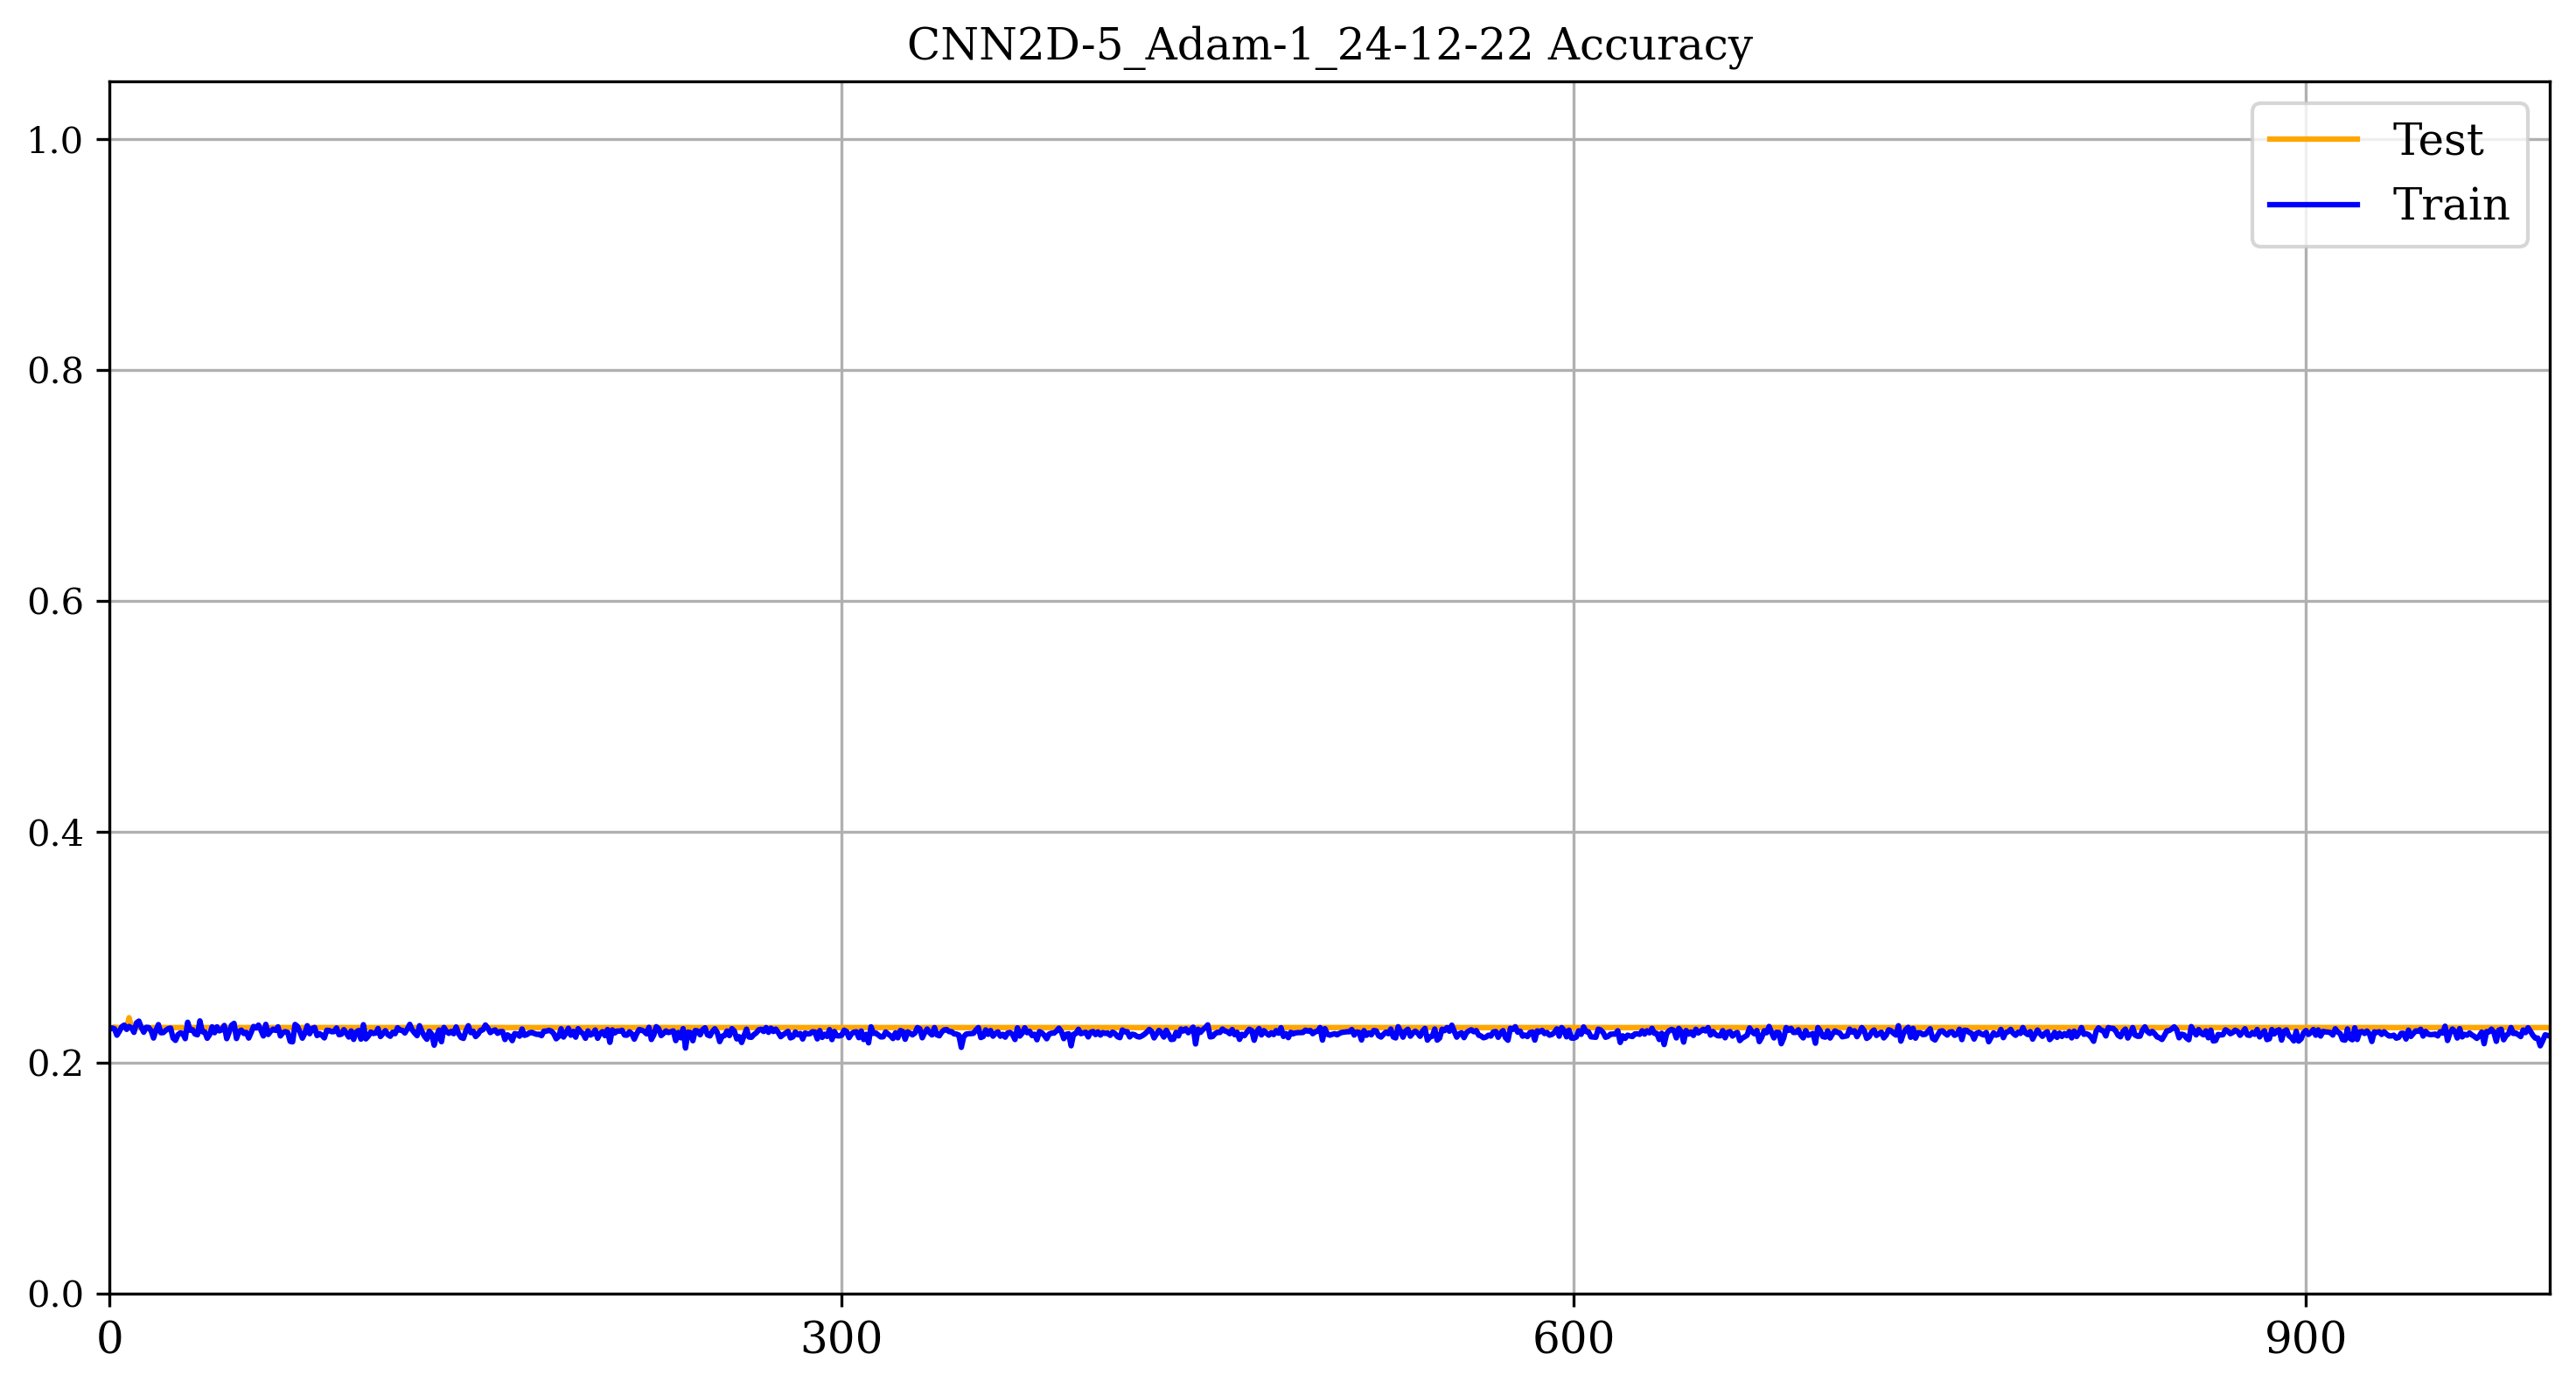

In [ ]:
graph_accu('CNN2D-5_Adam-1_24-12-22')

Curriculum:12 Batchsize:{batchsize}
last epoch: 1000
Training Loss: 155.05%
Testing Loss: 155.02%


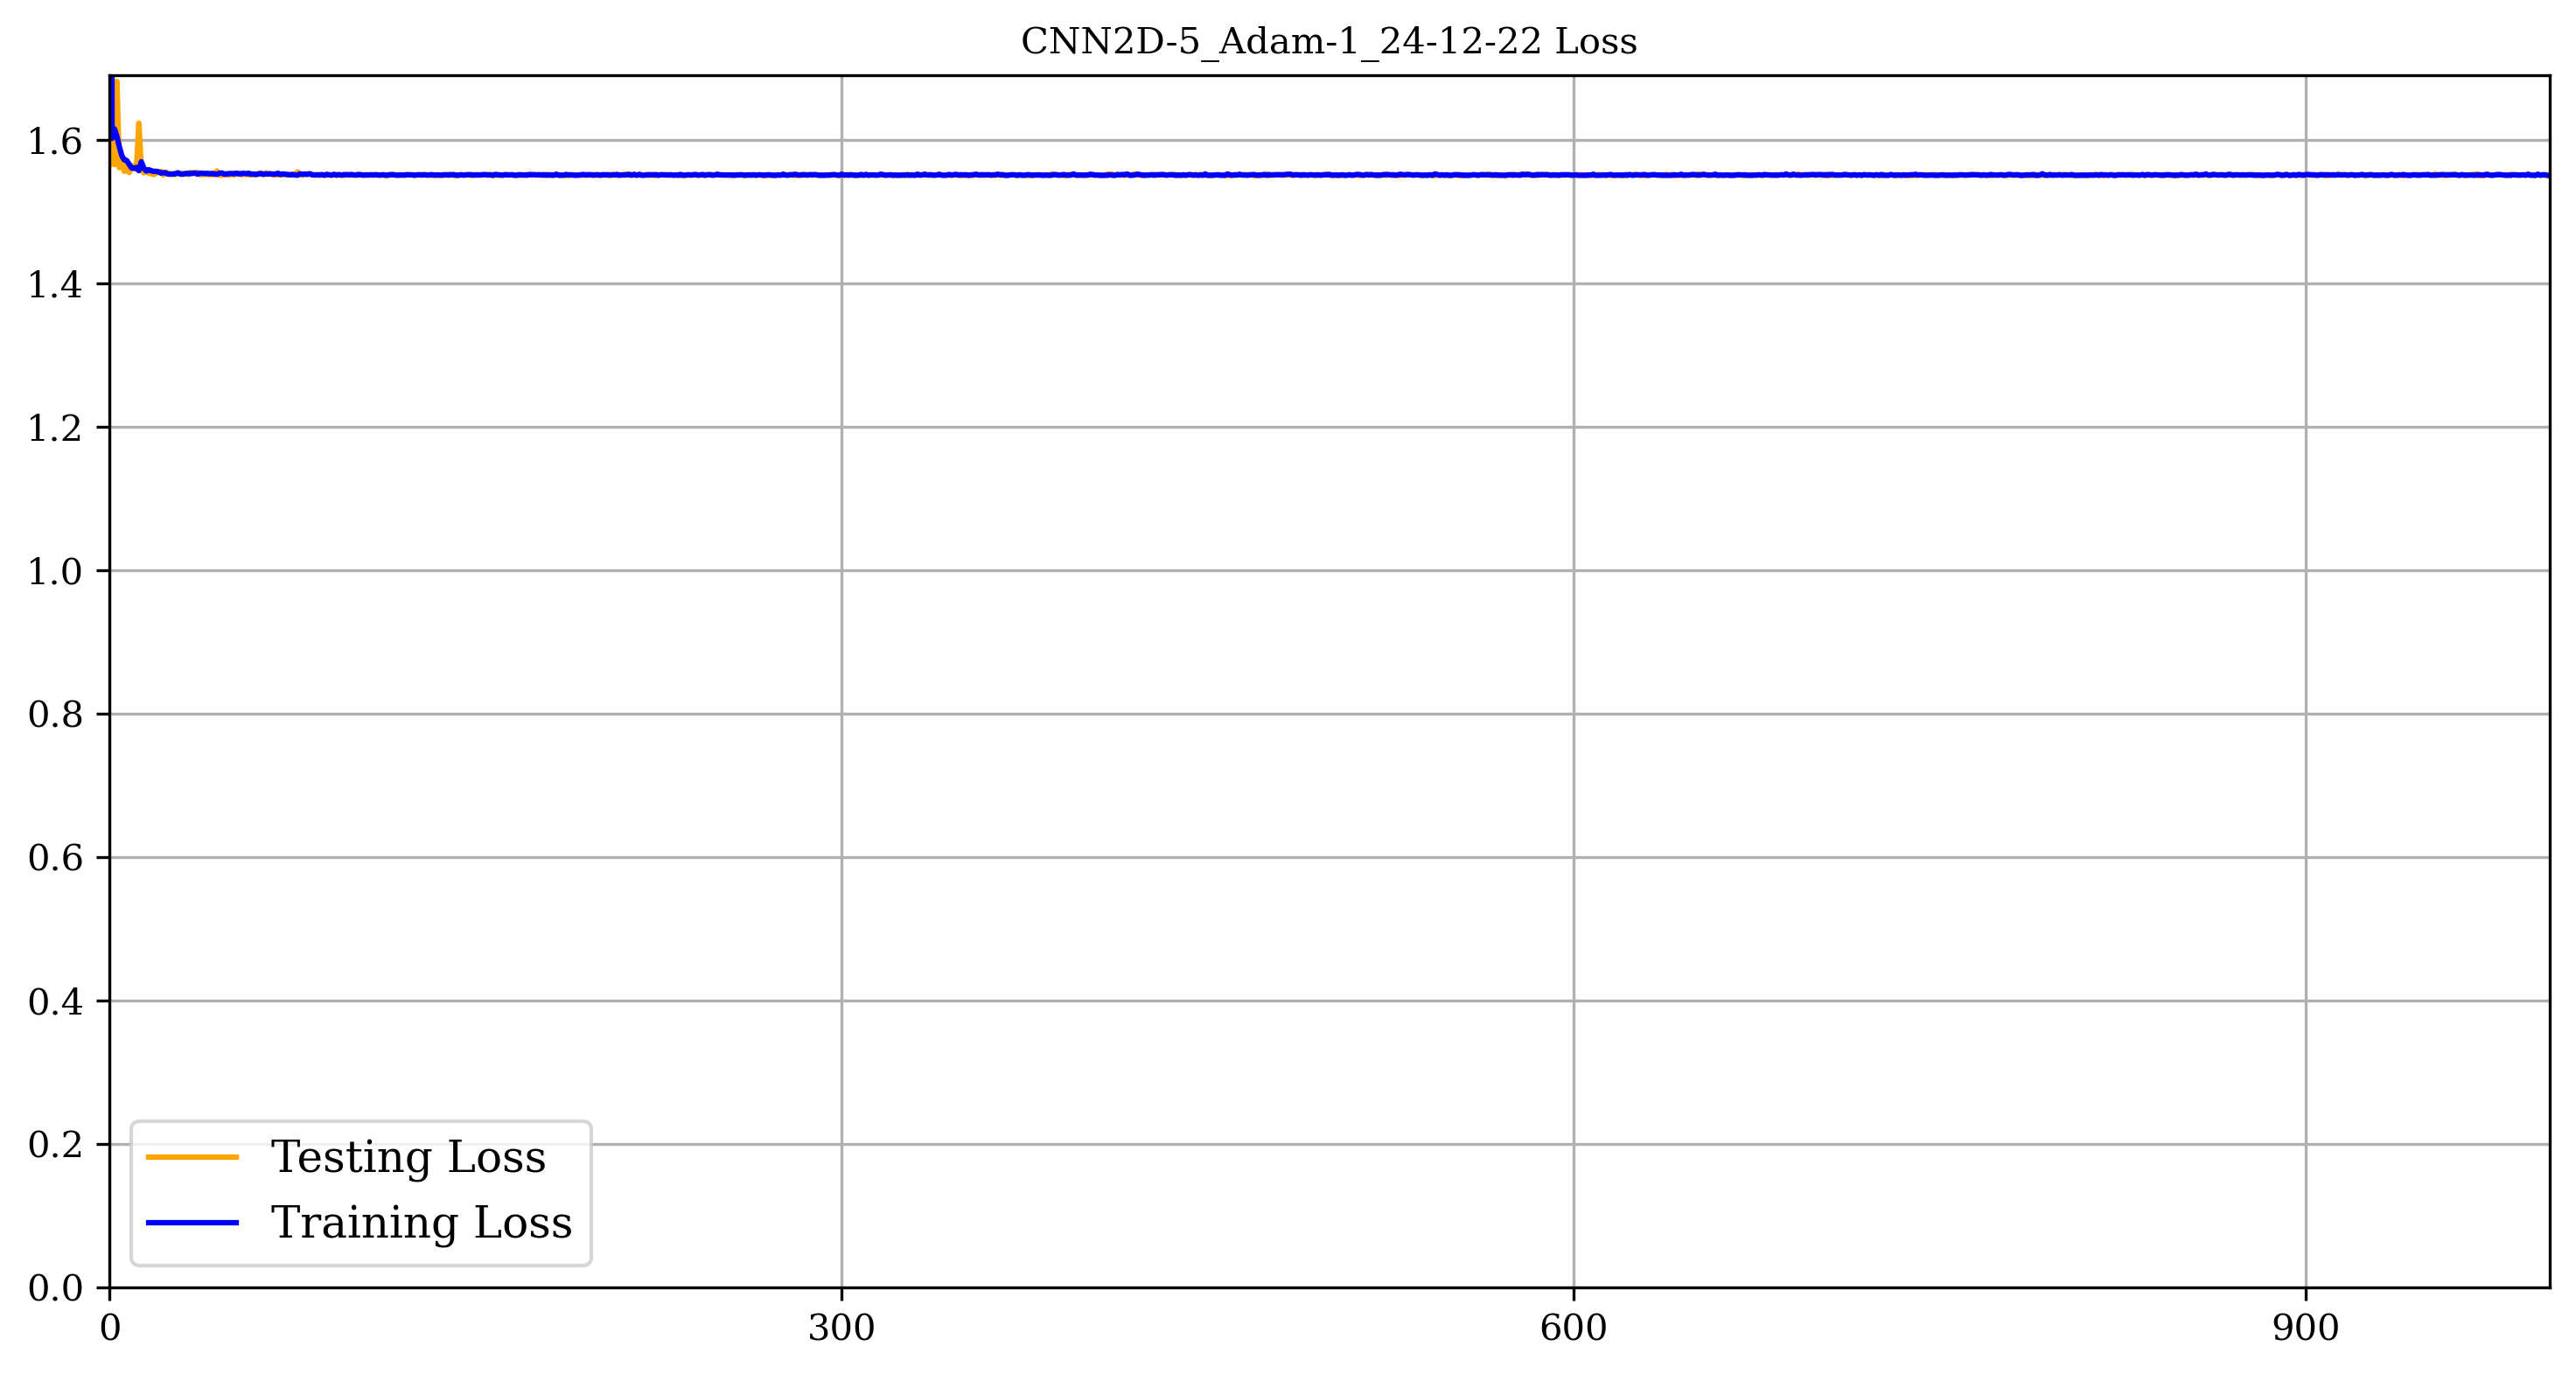

In [ ]:
graph_loss('CNN2D-5_Adam-1_24-12-22')

Try normalizing

In [ ]:
curriculum = 13
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 13

#model = CNN2DF()
#model = MLP1L()
model = CNN2D()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 0 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 1000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'CNN2D-5_Adam-0N_24-12-29_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'CNN2D-5_Adam-0N_24-12-29_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'CNN2D-5_Adam-0N_24-12-29_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer)
#train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.767403 sec. Training Accu: 22.66
Epoch:000002 done. Time elapsed:1.399402 sec. Training Accu: 23.73
Epoch:000003 done. Time elapsed:2.137403 sec. Training Accu: 23.64
Epoch:000004 done. Time elapsed:2.757403 sec. Training Accu: 22.95
Epoch:000005 done. Time elapsed:3.474403 sec. Training Accu: 22.75
Epoch:000006 done. Time elapsed:4.178405 sec. Training Accu: 22.93
Epoch:000007 done. Time elapsed:4.751401 sec. Training Accu: 23.11
Epoch:000008 done. Time elapsed:5.467402 sec. Training Accu: 23.47
Epoch:000009 done. Time elapsed:6.196405 sec. Training Accu: 22.86
Epoch:000010 done. Time elapsed:6.794403 sec. Training Accu: 23.47
Epoch:000011 done. Time elapsed:7.443402 sec. Training Accu: 23.17
Epoch:000012 done. Time elapsed:8.023405 sec. Training Accu: 23.49
Epoch:000013 done. Time elapsed:8.669402 sec. Training Accu: 22.18
Epoch:000014 done. Time elapsed:9.271402 sec. Training Accu: 22.34
Epoch:000015 done. Time elapsed:9.854405 sec. Training Accu: 2

Curriculum:13 Batchsize:{batchsize}
last epoch: 1000
Training Accuracy: 22.78%
Testing Accuracy: 23.08%


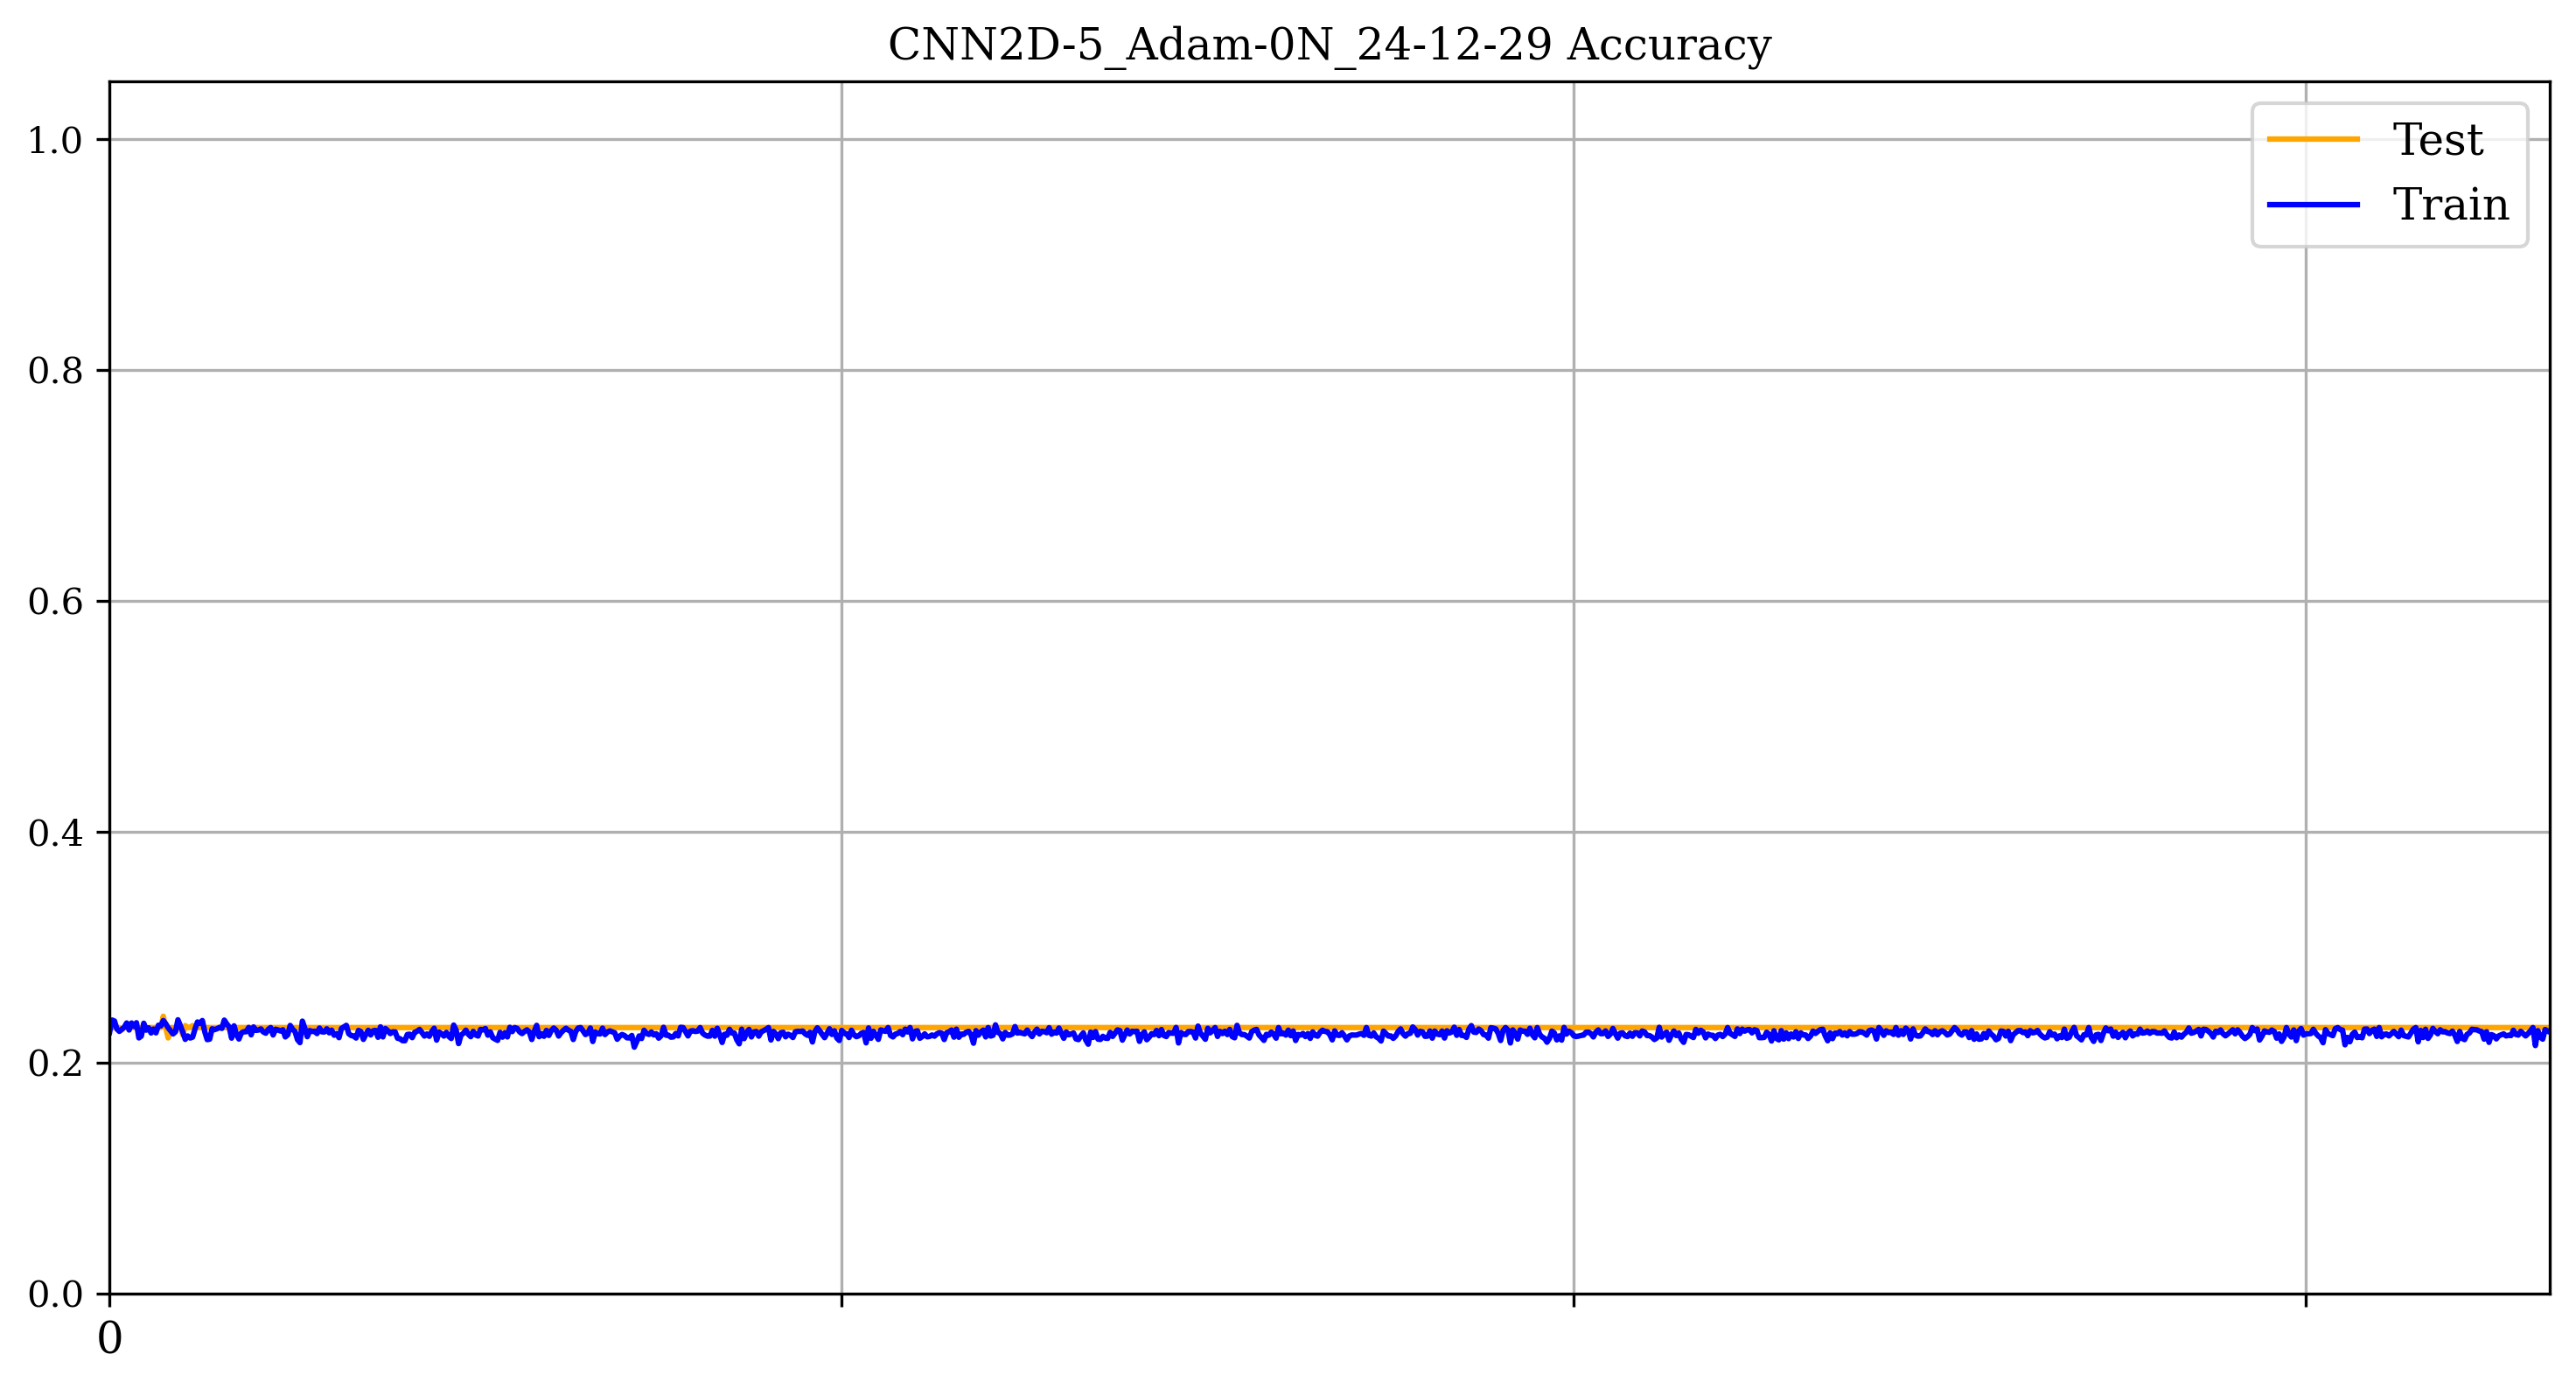

In [ ]:
graph_accu('CNN2D-5_Adam-0N_24-12-29')

Curriculum:13 Batchsize:{batchsize}
last epoch: 1000
Training Loss: 155.05%
Testing Loss: 155.09%


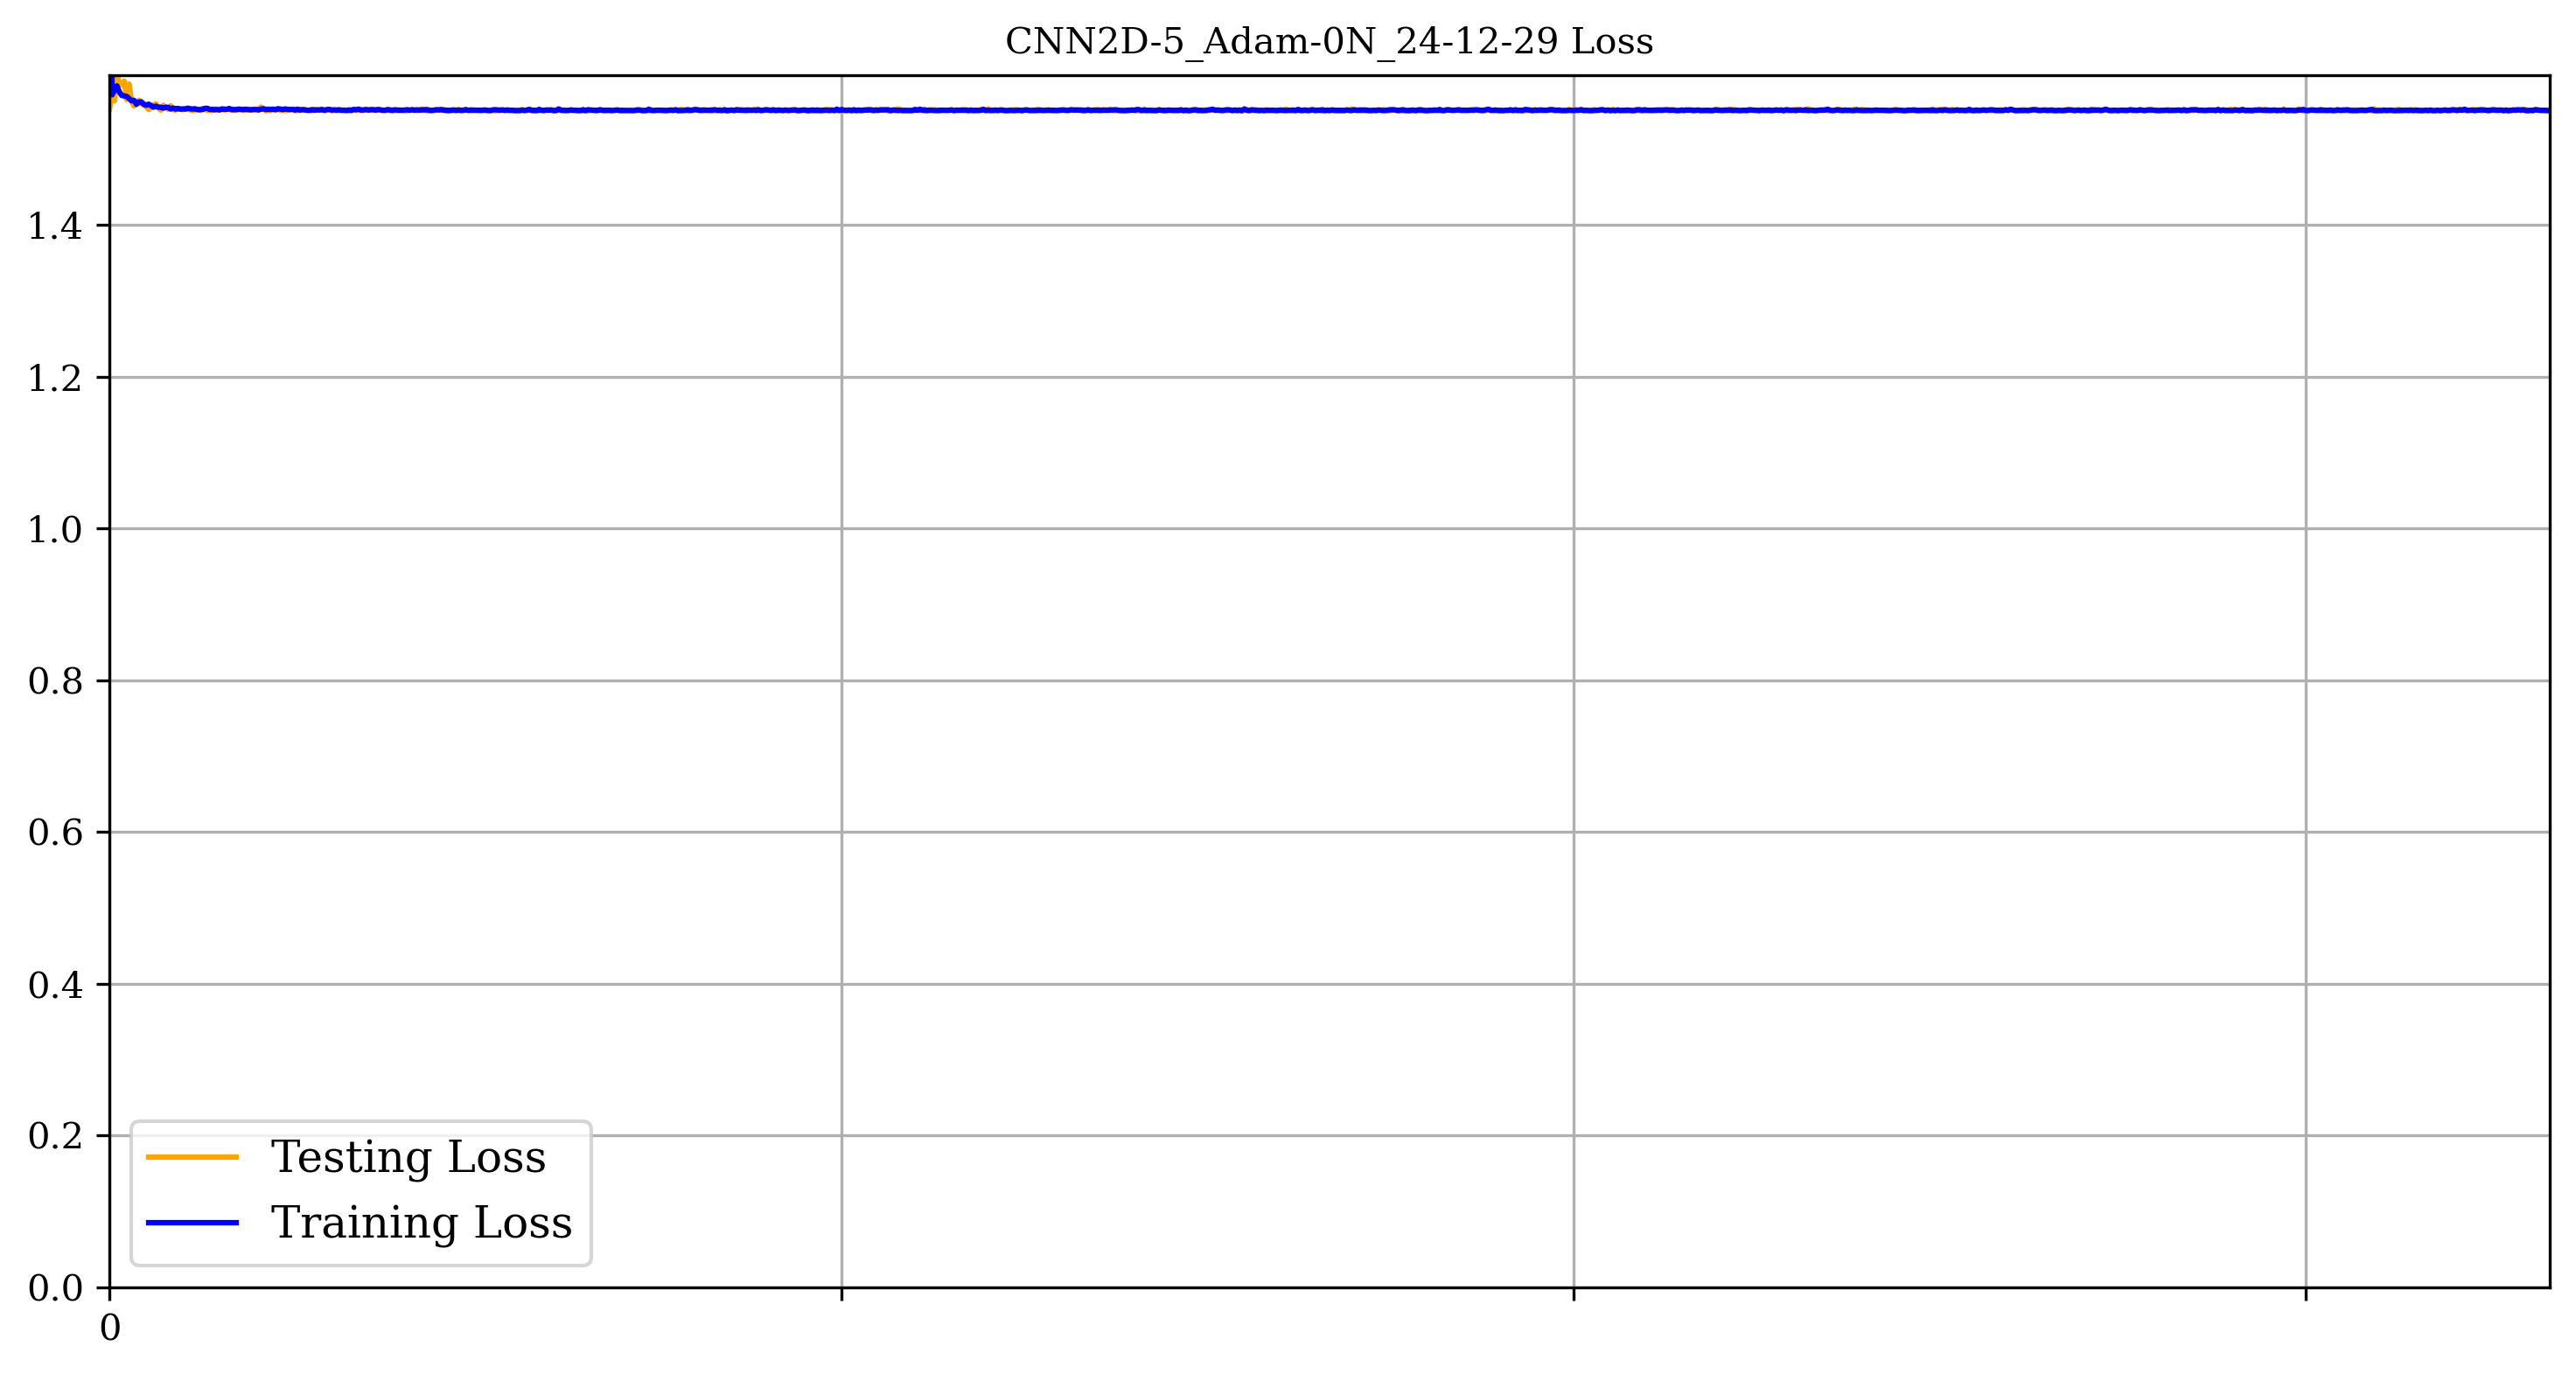

In [ ]:
graph_loss('CNN2D-5_Adam-0N_24-12-29')

In [ ]:
curriculum = 14
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 14

#model = CNN2DF()
#model = MLP1L()
model = CNN2D()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 0 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 1000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'CNN2D-5_Adam-1N_24-12-29_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'CNN2D-5_Adam-1N_24-12-29_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'CNN2D-5_Adam-1N_24-12-29_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer)
#train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.689996 sec. Training Accu: 21.84
Epoch:000002 done. Time elapsed:1.220996 sec. Training Accu: 21.58
Epoch:000003 done. Time elapsed:1.778999 sec. Training Accu: 23.01
Epoch:000004 done. Time elapsed:2.480996 sec. Training Accu: 23.12
Epoch:000005 done. Time elapsed:3.116997 sec. Training Accu: 23.32
Epoch:000006 done. Time elapsed:3.730999 sec. Training Accu: 23.17
Epoch:000007 done. Time elapsed:4.453996 sec. Training Accu: 22.54
Epoch:000008 done. Time elapsed:4.992996 sec. Training Accu: 22.75
Epoch:000009 done. Time elapsed:5.533998 sec. Training Accu: 23.41
Epoch:000010 done. Time elapsed:6.048996 sec. Training Accu: 22.55
Epoch:000011 done. Time elapsed:6.715996 sec. Training Accu: 23.27
Epoch:000012 done. Time elapsed:7.311018 sec. Training Accu: 22.71
Epoch:000013 done. Time elapsed:7.890995 sec. Training Accu: 23.73
Epoch:000014 done. Time elapsed:8.464998 sec. Training Accu: 23.30
Epoch:000015 done. Time elapsed:8.976998 sec. Training Accu: 2

Curriculum:14 Batchsize:{batchsize}
last epoch: 1000
Training Accuracy: 79.15%
Testing Accuracy: 72.65%


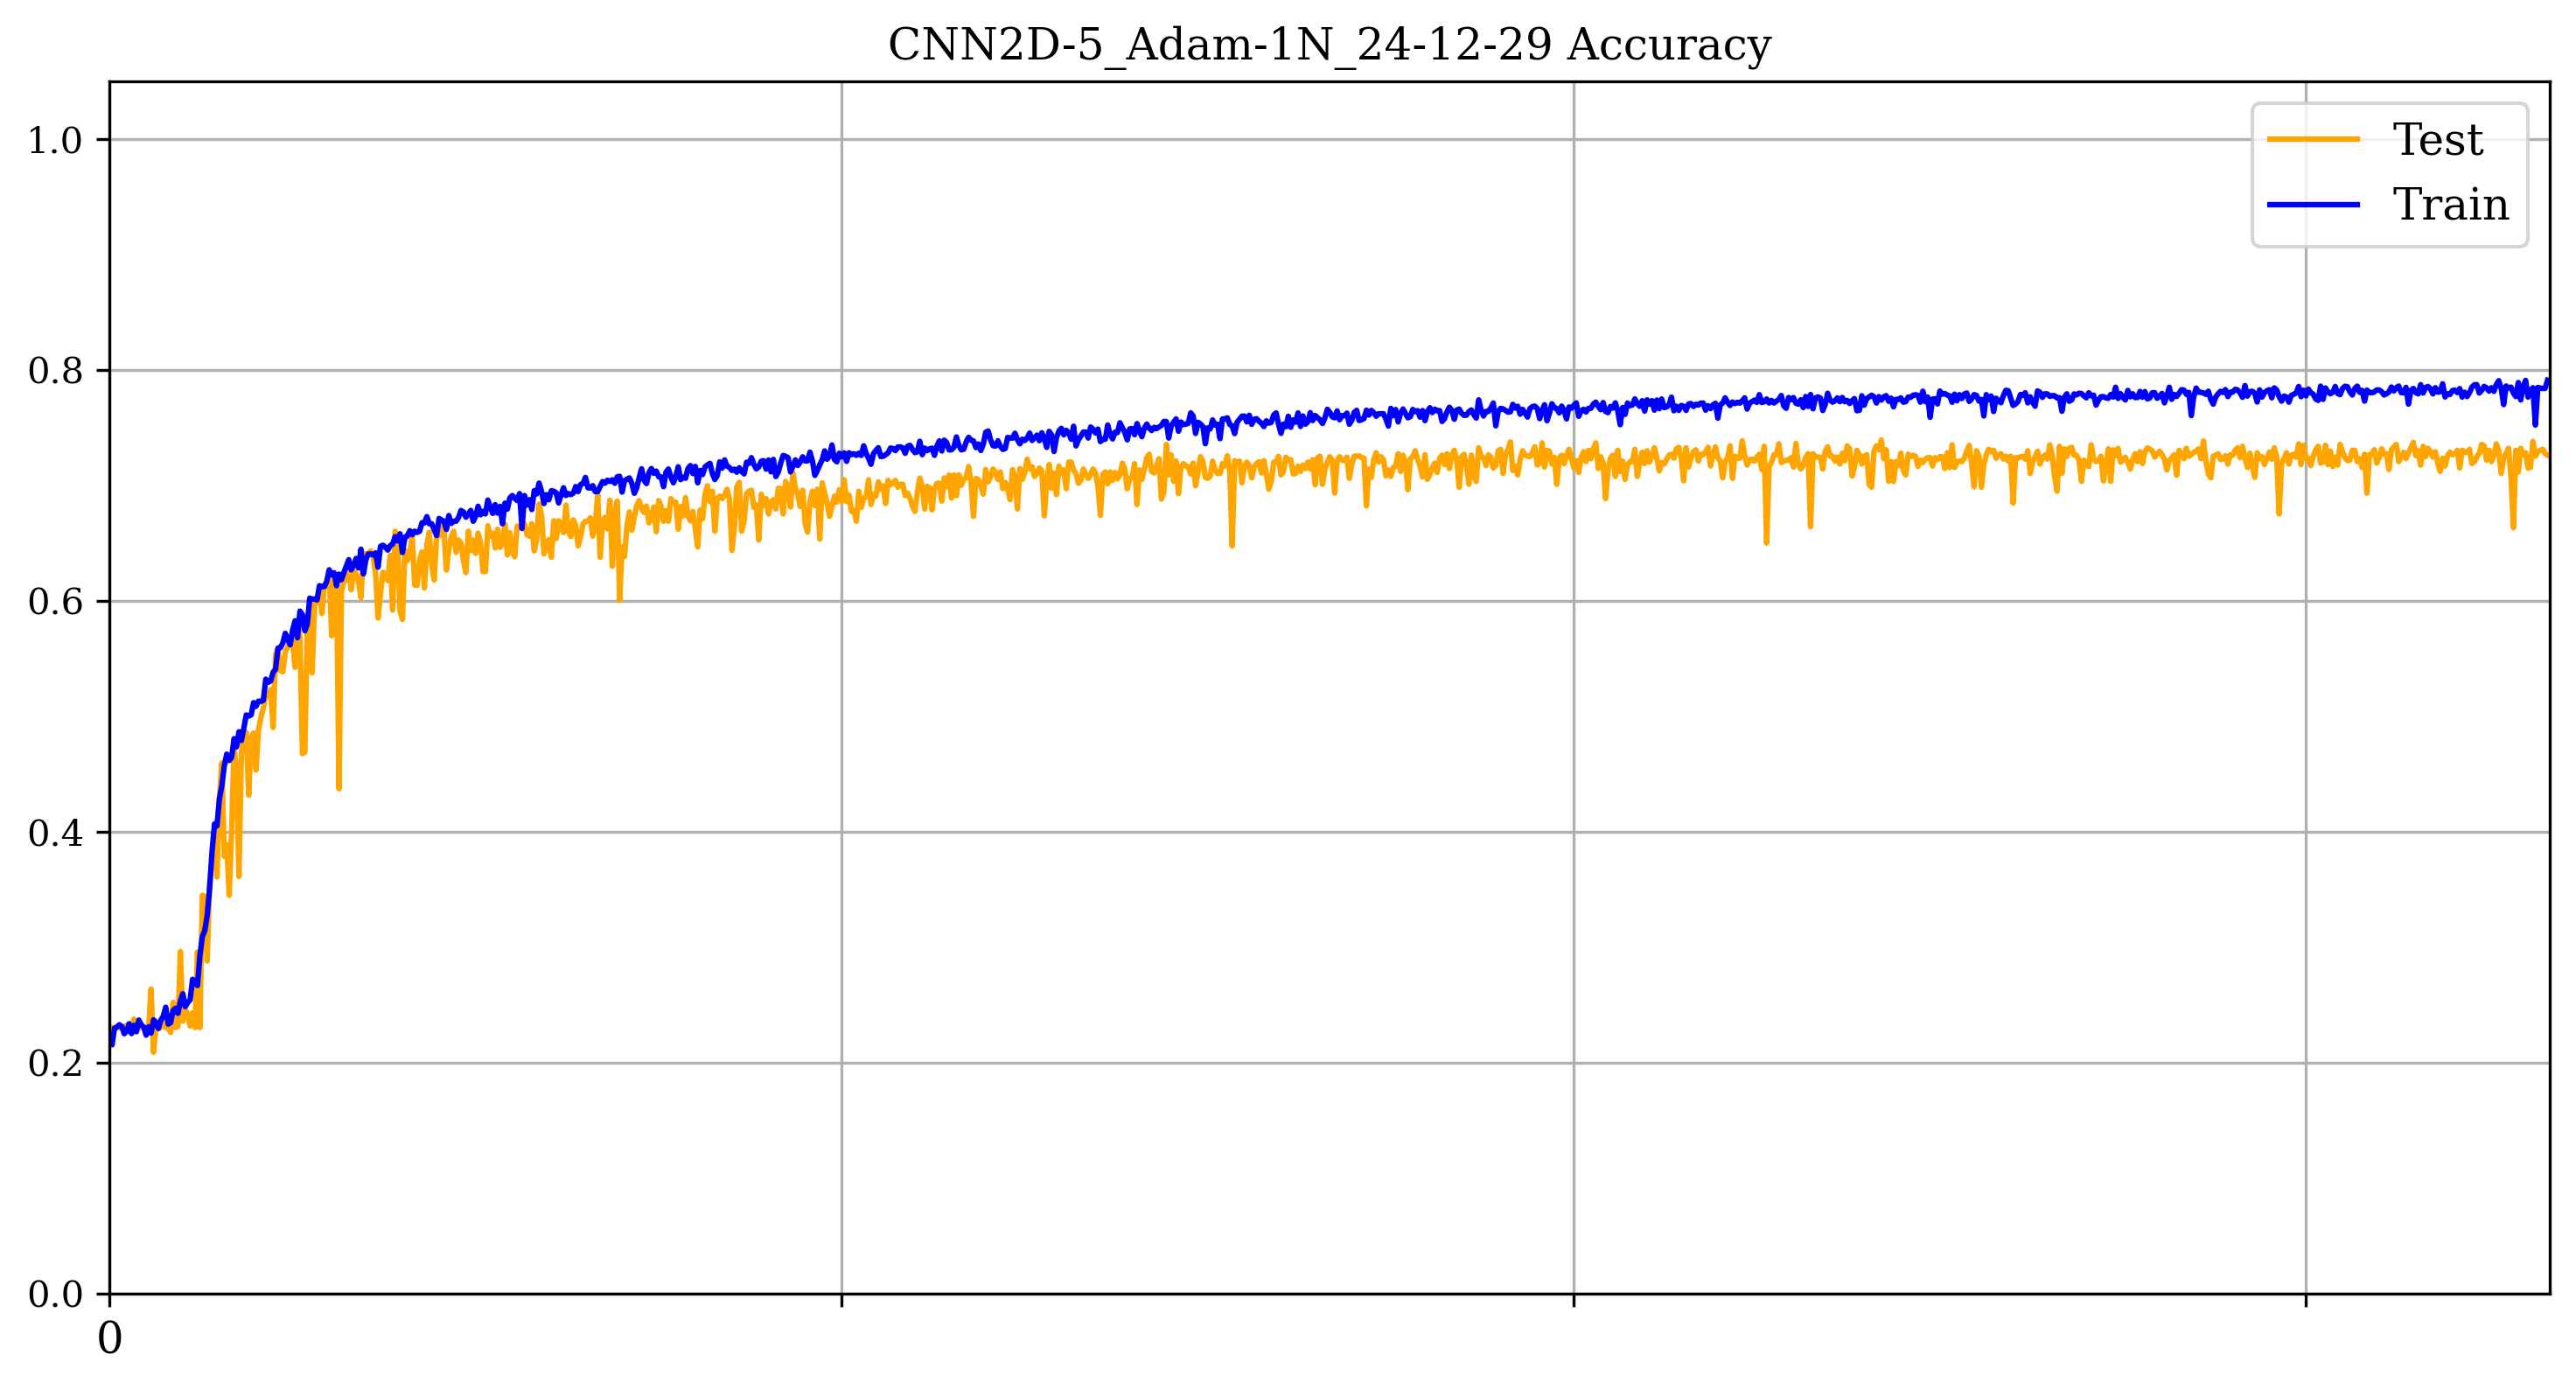

In [ ]:
graph_accu('CNN2D-5_Adam-1N_24-12-29')

Curriculum:14 Batchsize:{batchsize}
last epoch: 1000
Training Loss: 50.35%
Testing Loss: 71.40%


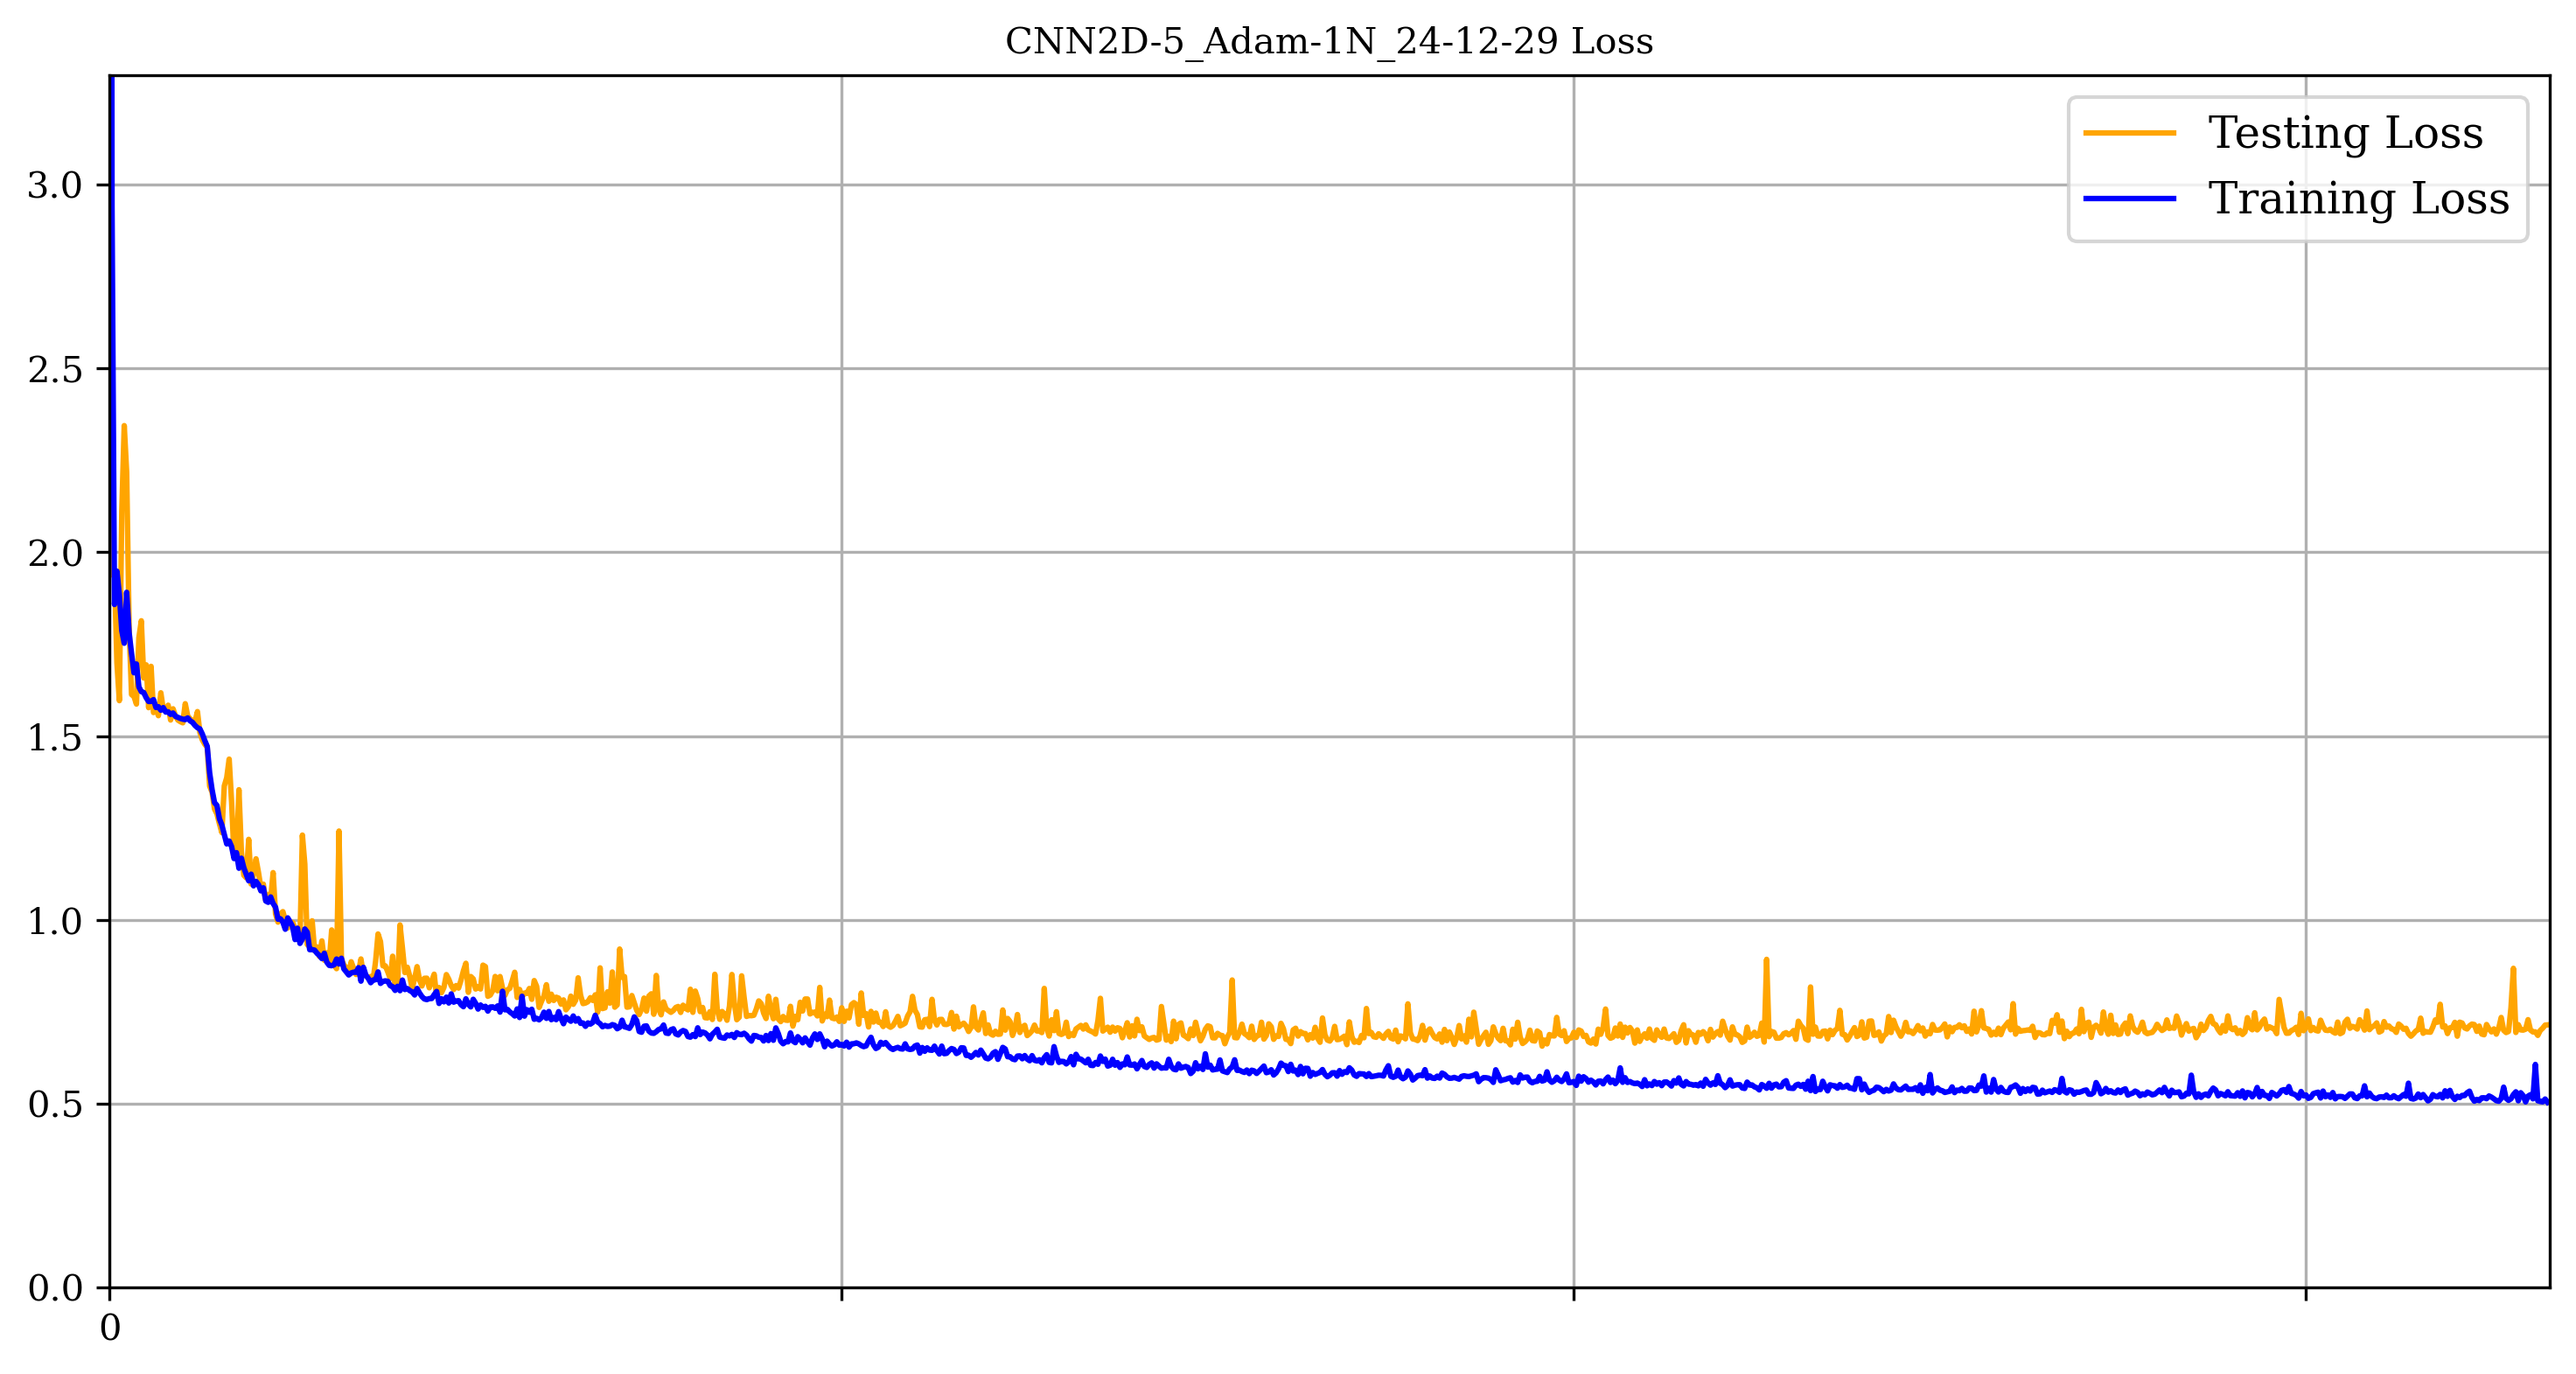

In [ ]:
graph_loss('CNN2D-5_Adam-1N_24-12-29')

## Regression Training

In [ ]:
curriculum = 15
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.float).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.float).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 15

model = CNN2DR()
#model = MLP1L()
#model = CNN2D()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 0 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 1000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'CNN2DR-5_Adam-0_24-12-29_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'CNN2DR-5_Adam-0_24-12-29_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'CNN2DR-5_Adam-0_24-12-29_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

#train_dnn_classification(train_dataloader, test_dataloader, model, loss_fn, optimizer)
train_dnn_regression(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.672865 sec. Training loss: 1624.05
Epoch:000002 done. Time elapsed:1.192854 sec. Training loss: 60.86
Epoch:000003 done. Time elapsed:1.690854 sec. Training loss: 50.88
Epoch:000004 done. Time elapsed:2.194852 sec. Training loss: 51.19
Epoch:000005 done. Time elapsed:2.714855 sec. Training loss: 49.72
Epoch:000006 done. Time elapsed:3.352878 sec. Training loss: 50.07
Epoch:000007 done. Time elapsed:3.970886 sec. Training loss: 49.26
Epoch:000008 done. Time elapsed:4.525876 sec. Training loss: 49.74
Epoch:000009 done. Time elapsed:5.042876 sec. Training loss: 49.61
Epoch:000010 done. Time elapsed:5.611879 sec. Training loss: 50.25
Epoch:000011 done. Time elapsed:6.290879 sec. Training loss: 50.06
Epoch:000012 done. Time elapsed:6.794876 sec. Training loss: 50.90
Epoch:000013 done. Time elapsed:7.327879 sec. Training loss: 51.54
Epoch:000014 done. Time elapsed:7.970392 sec. Training loss: 53.25
Epoch:000015 done. Time elapsed:8.618392 sec. Training loss:

Curriculum:15 Batchsize:{batchsize}
last epoch: 1000
Training Loss: 10.35%
Testing Loss: 11.45%


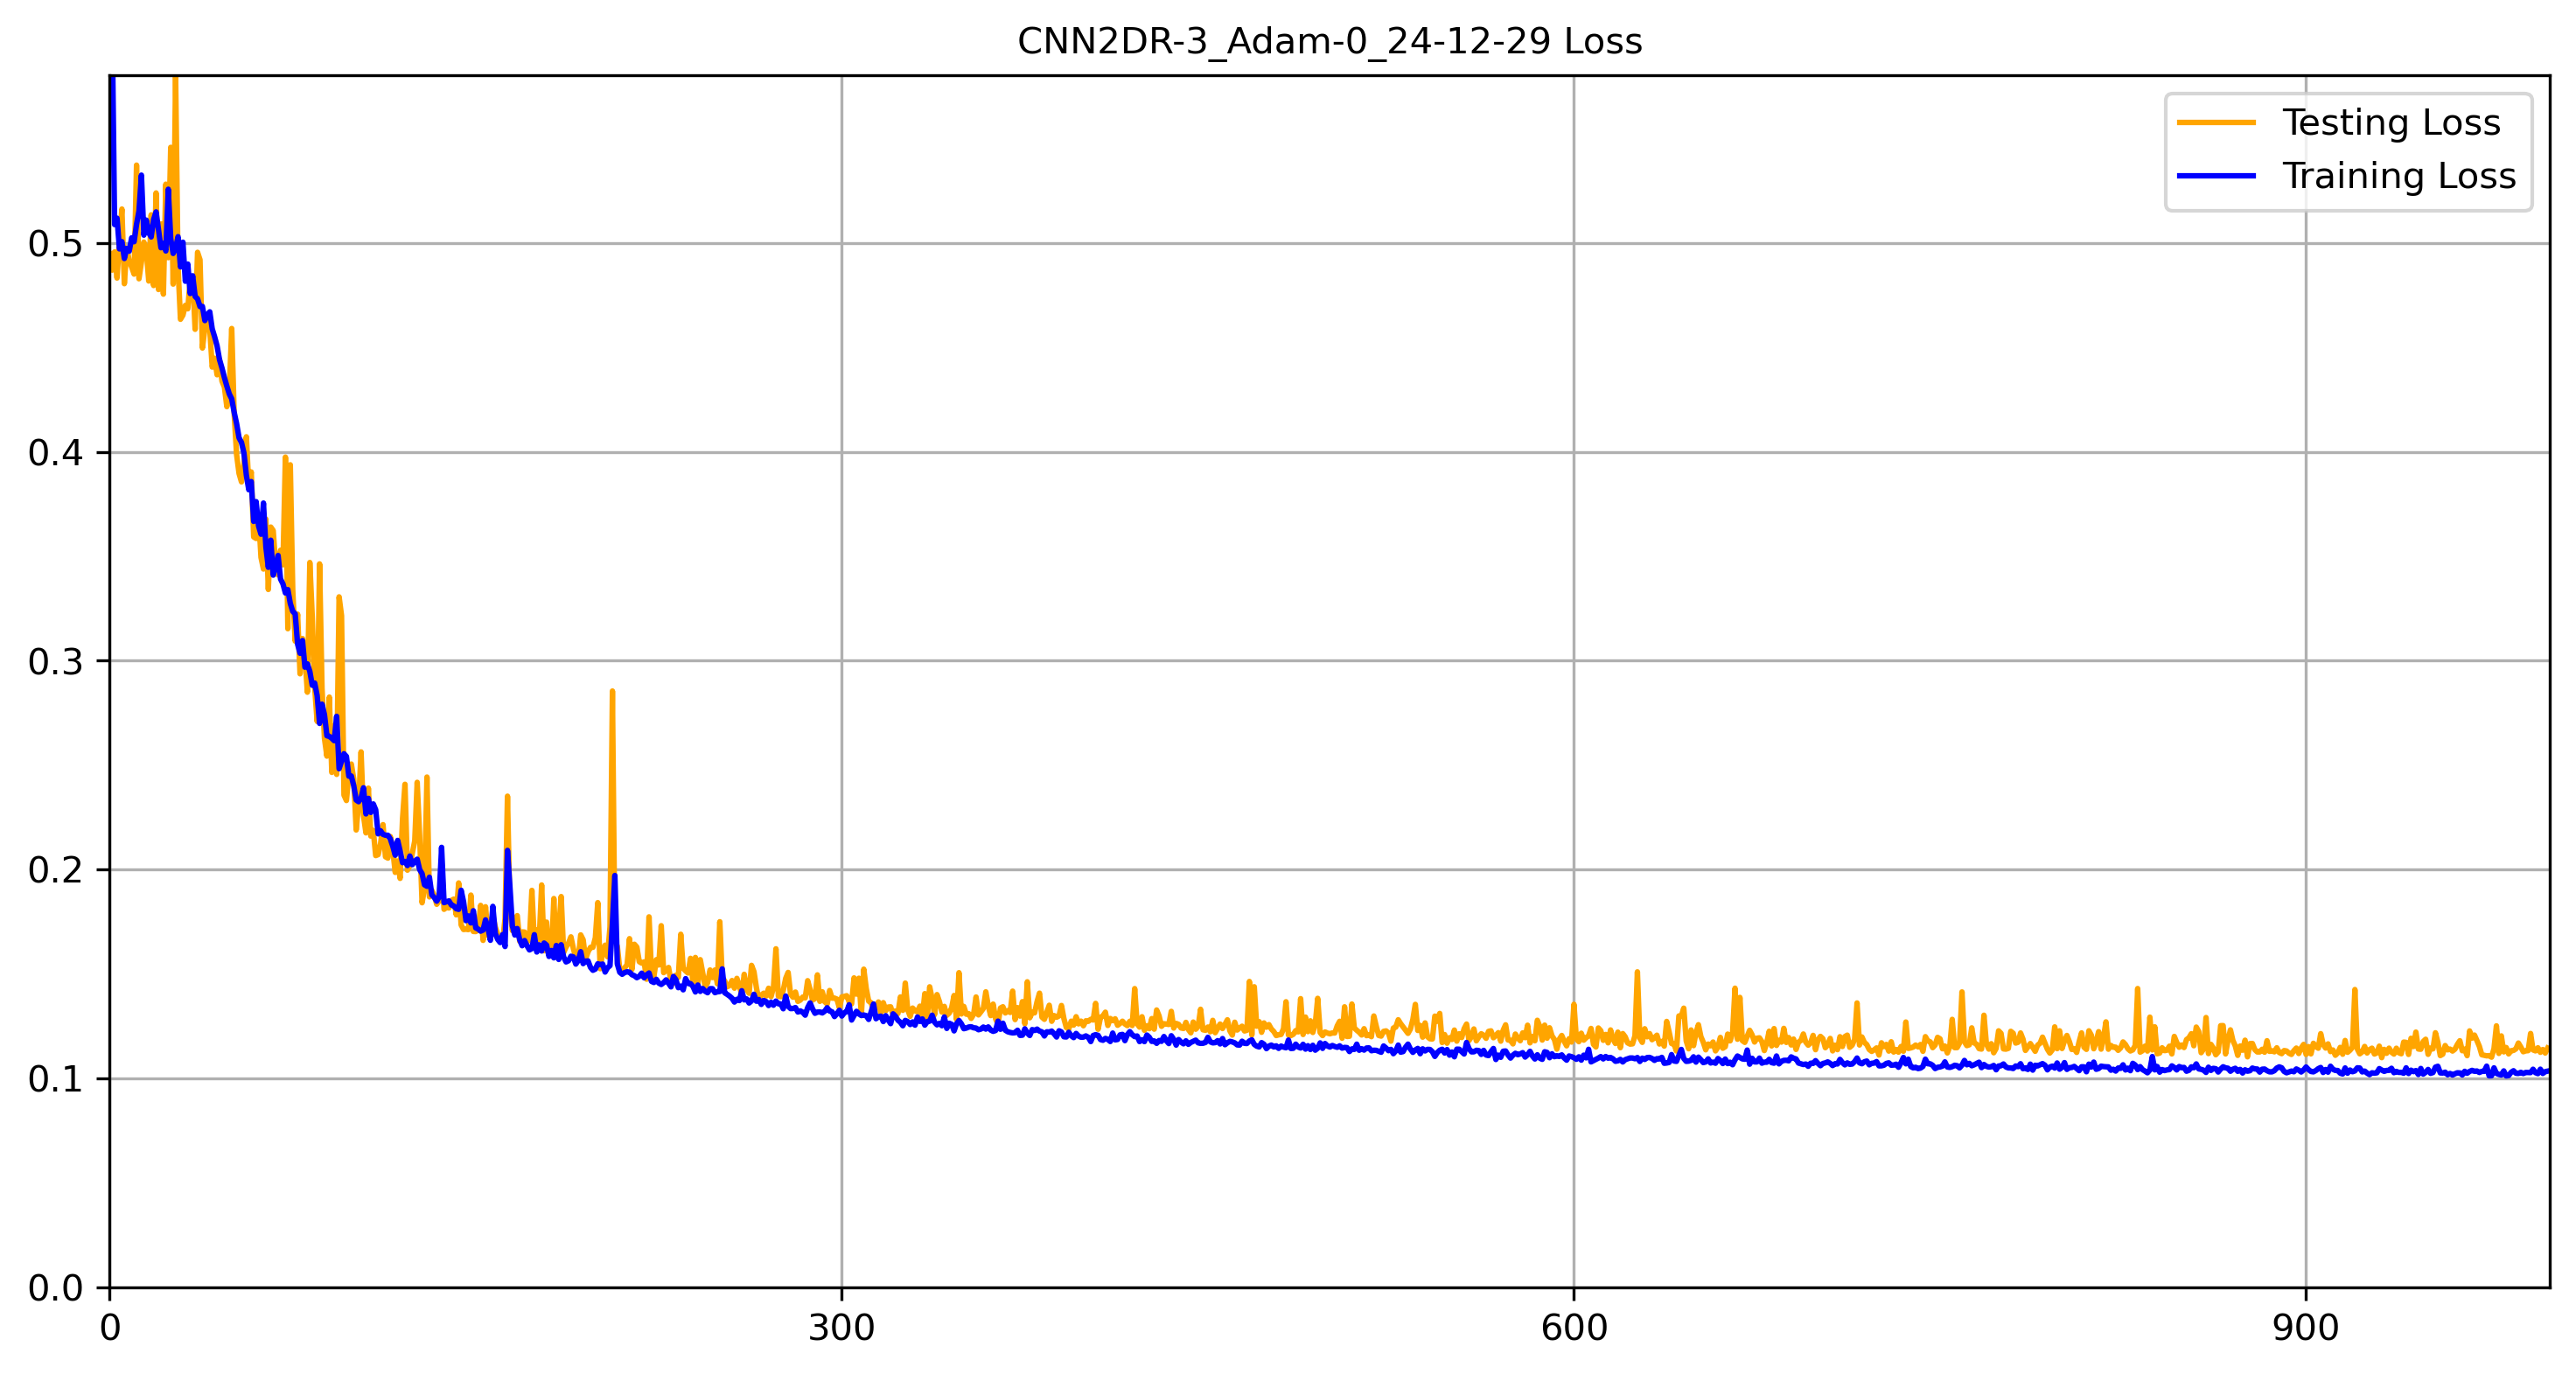

In [ ]:
graph_loss('CNN2DR-3_Adam-0_24-12-29')

## Curriculum Training

In [ ]:
curriculum = 1
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, 'train_plots_curr01.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, 'test_plots_curr01.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, 'train_labels_curr01.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, 'test_labels_curr01.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 1

model = MLP1L()
#model = CNN()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 150 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 300 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'Adam_binary_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'Adam_binary_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'Adam_binary_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:0.131873 sec.
Epoch:000002 done. Time elapsed:0.229168 sec.
Epoch:000003 done. Time elapsed:0.297133 sec.
Epoch:000004 done. Time elapsed:0.382043 sec.
Epoch:000005 done. Time elapsed:0.460209 sec.
Epoch:000006 done. Time elapsed:0.569583 sec.
Epoch:000007 done. Time elapsed:0.650514 sec.
Epoch:000008 done. Time elapsed:0.743946 sec.
Epoch:000009 done. Time elapsed:0.815526 sec.
Epoch:000010 done. Time elapsed:0.895634 sec.
Epoch:000011 done. Time elapsed:1.020638 sec.
Epoch:000012 done. Time elapsed:1.121091 sec.
Epoch:000013 done. Time elapsed:1.199946 sec.
Epoch:000014 done. Time elapsed:1.278416 sec.
Epoch:000015 done. Time elapsed:1.375712 sec.
Epoch:000016 done. Time elapsed:1.550219 sec.
Epoch:000017 done. Time elapsed:1.661662 sec.
Epoch:000018 done. Time elapsed:1.765481 sec.
Epoch:000019 done. Time elapsed:1.859263 sec.
Epoch:000020 done. Time elapsed:1.953418 sec.
Epoch:000021 done. Time elapsed:2.102919 sec.
Epoch:000022 done. Time elapsed:2.

Curriculum:01 Batchsize:{batchsize}
last epoch: 300
Training Accuracy: 92.50%
Testing Accuracy: 90.56%


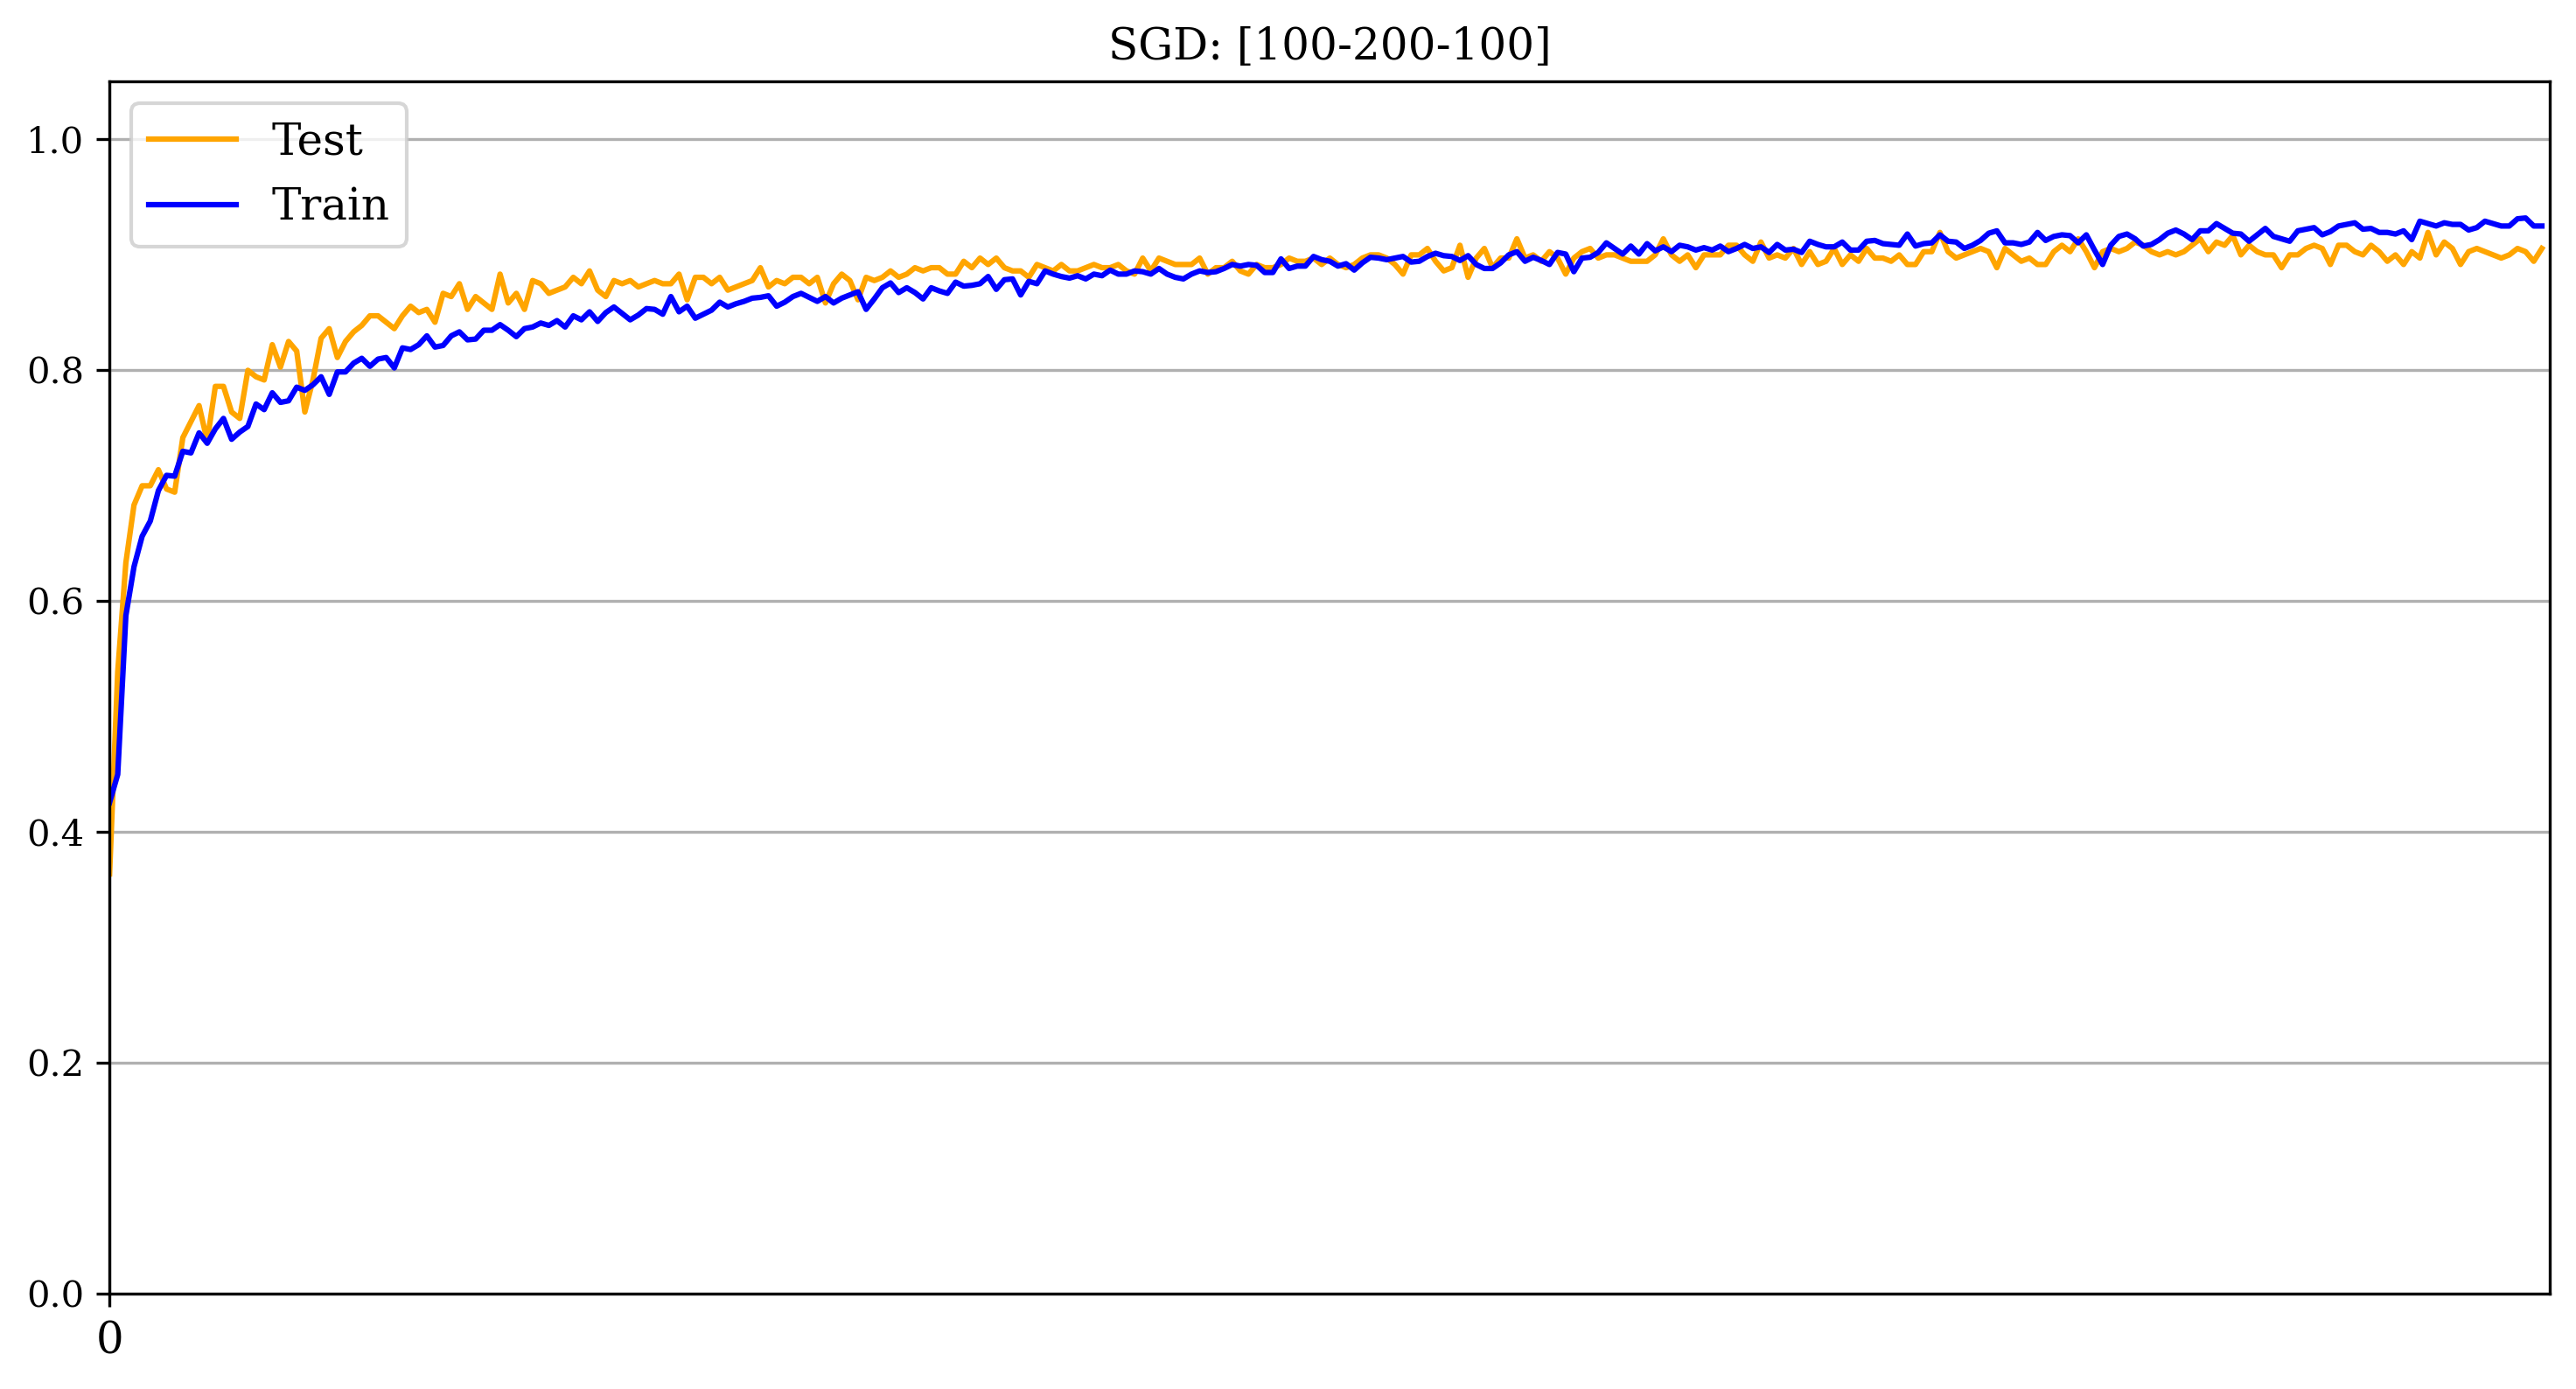

In [ ]:
graph_accu('SGD')

Curriculum:01 Batchsize:{batchsize}
last epoch: 300
Training Loss: 40.05%
Testing Loss: 52.95%


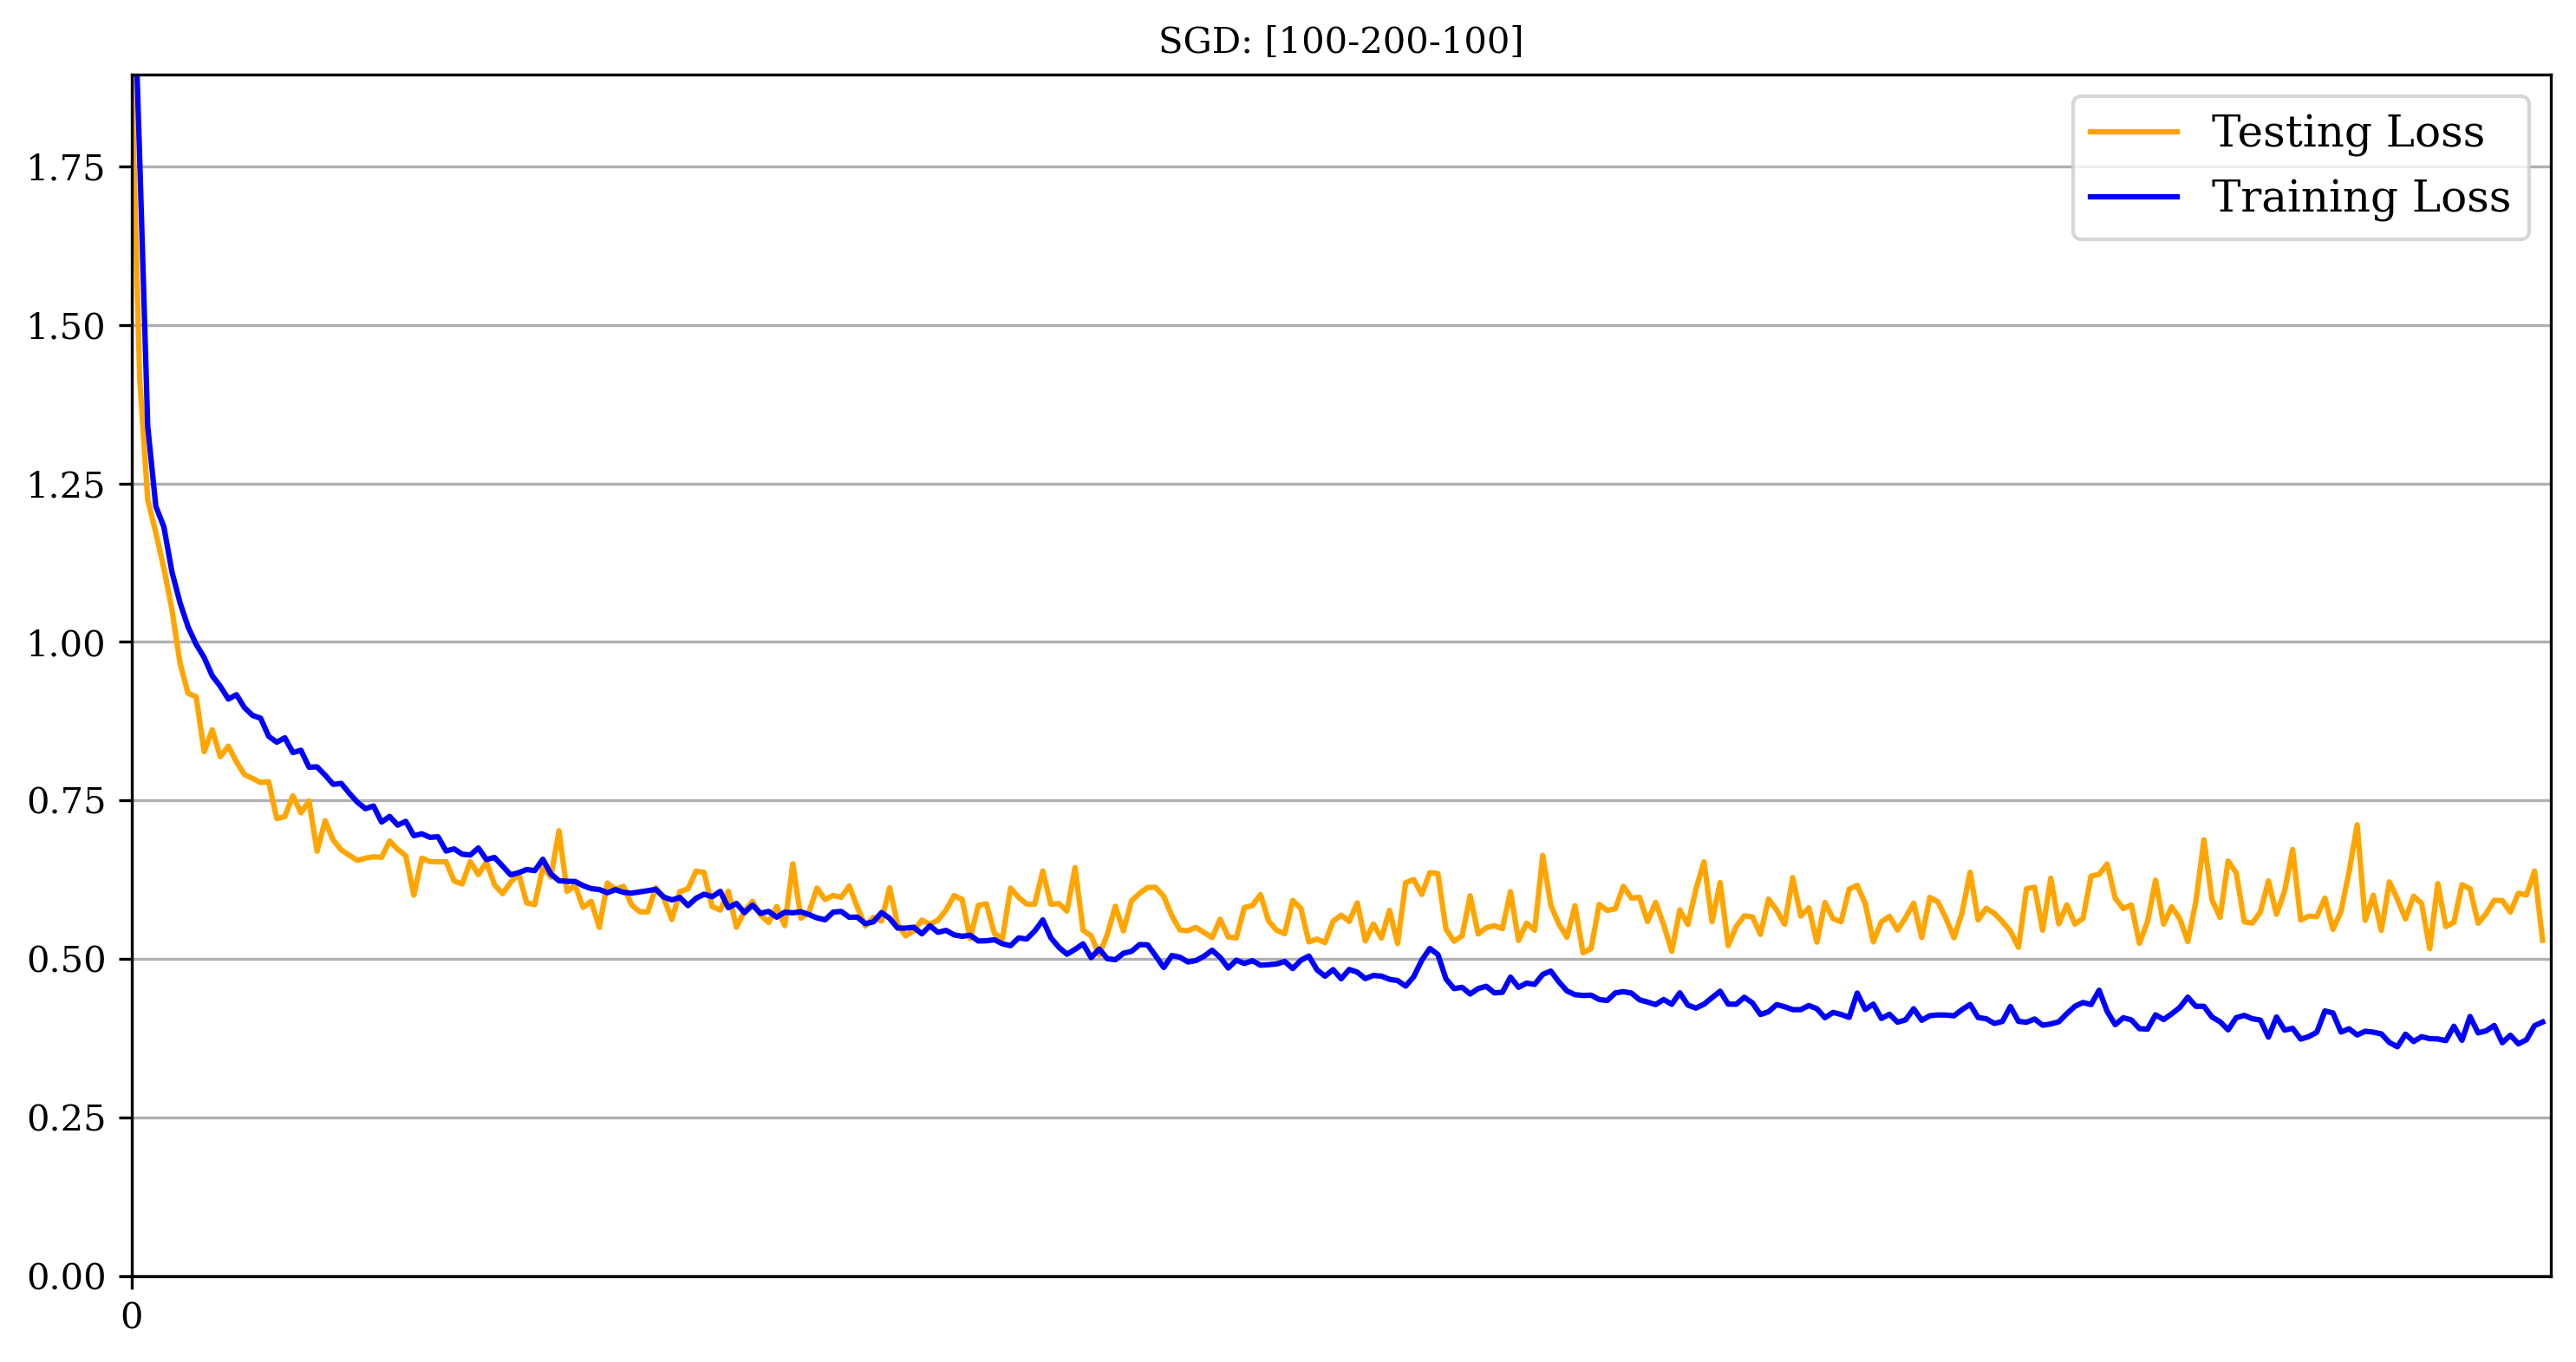

In [ ]:
graph_loss('SGD')

In [ ]:
curriculum = 2
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 2

#model = MLP1L()
model = CNN()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = False

resume1 = False
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 300 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 600 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
#mid_drop_tolerance = -0.05
min_drop_tolerance = -0.01 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'Adam_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'Adam_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'Adam_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000001 done. Time elapsed:1.521961 sec.
Epoch:000002 done. Time elapsed:1.662473 sec.
Epoch:000003 done. Time elapsed:1.785874 sec.
Epoch:000004 done. Time elapsed:1.923613 sec.
Epoch:000005 done. Time elapsed:2.062607 sec.
Epoch:000006 done. Time elapsed:2.232912 sec.
Epoch:000007 done. Time elapsed:2.361366 sec.
Epoch:000008 done. Time elapsed:2.485844 sec.
Epoch:000009 done. Time elapsed:2.676133 sec.
Epoch:000010 done. Time elapsed:2.801133 sec.
Epoch:000011 done. Time elapsed:2.971617 sec.
Epoch:000012 done. Time elapsed:3.131361 sec.
Epoch:000013 done. Time elapsed:3.263092 sec.
Epoch:000014 done. Time elapsed:3.392228 sec.
Epoch:000015 done. Time elapsed:3.527405 sec.
Epoch:000016 done. Time elapsed:3.717771 sec.
Epoch:000017 done. Time elapsed:3.844898 sec.
Epoch:000018 done. Time elapsed:3.970044 sec.
Epoch:000019 done. Time elapsed:4.099217 sec.
Epoch:000020 done. Time elapsed:4.222655 sec.
Epoch:000021 done. Time elapsed:4.397537 sec.
Epoch:000022 done. Time elapsed:4.

Curriculum:02 Batchsize:{batchsize}
last epoch: 600
Training Accuracy: 92.73%
Testing Accuracy: 88.89%


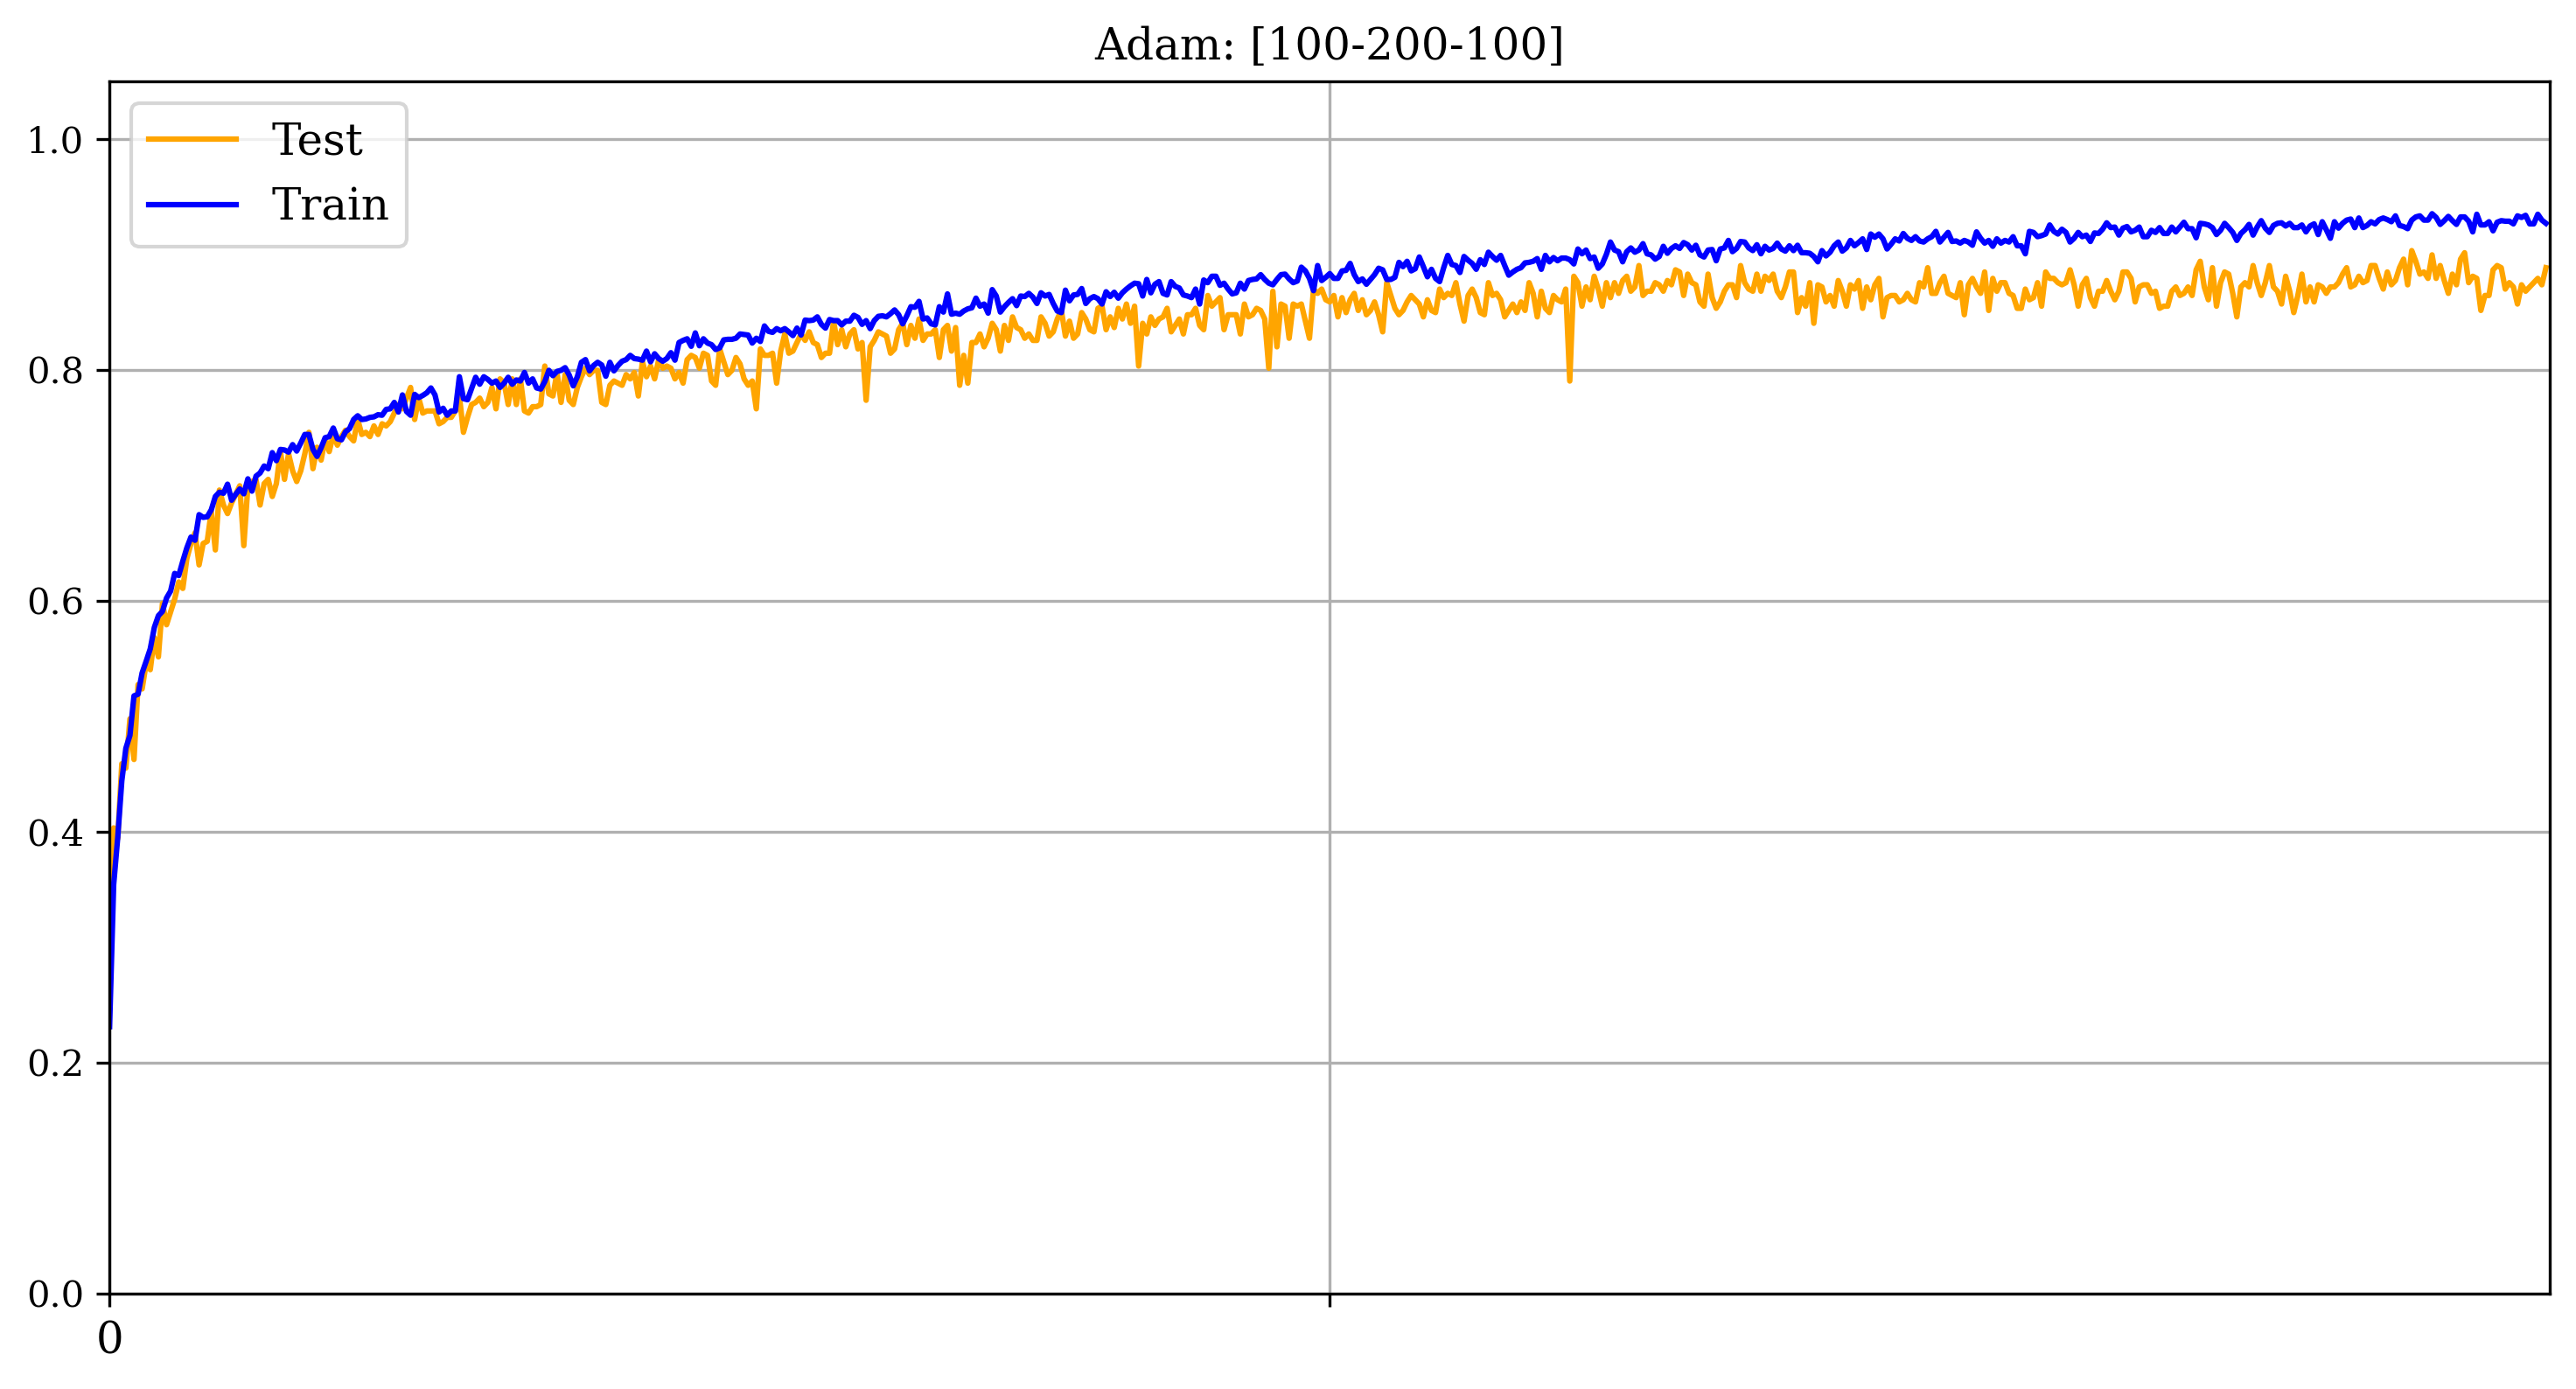

In [ ]:
graph_accu('Adam')

Curriculum:01 Batchsize:{batchsize}
last epoch: 500
Training Loss: 0.00%
Testing Loss: 0.00%


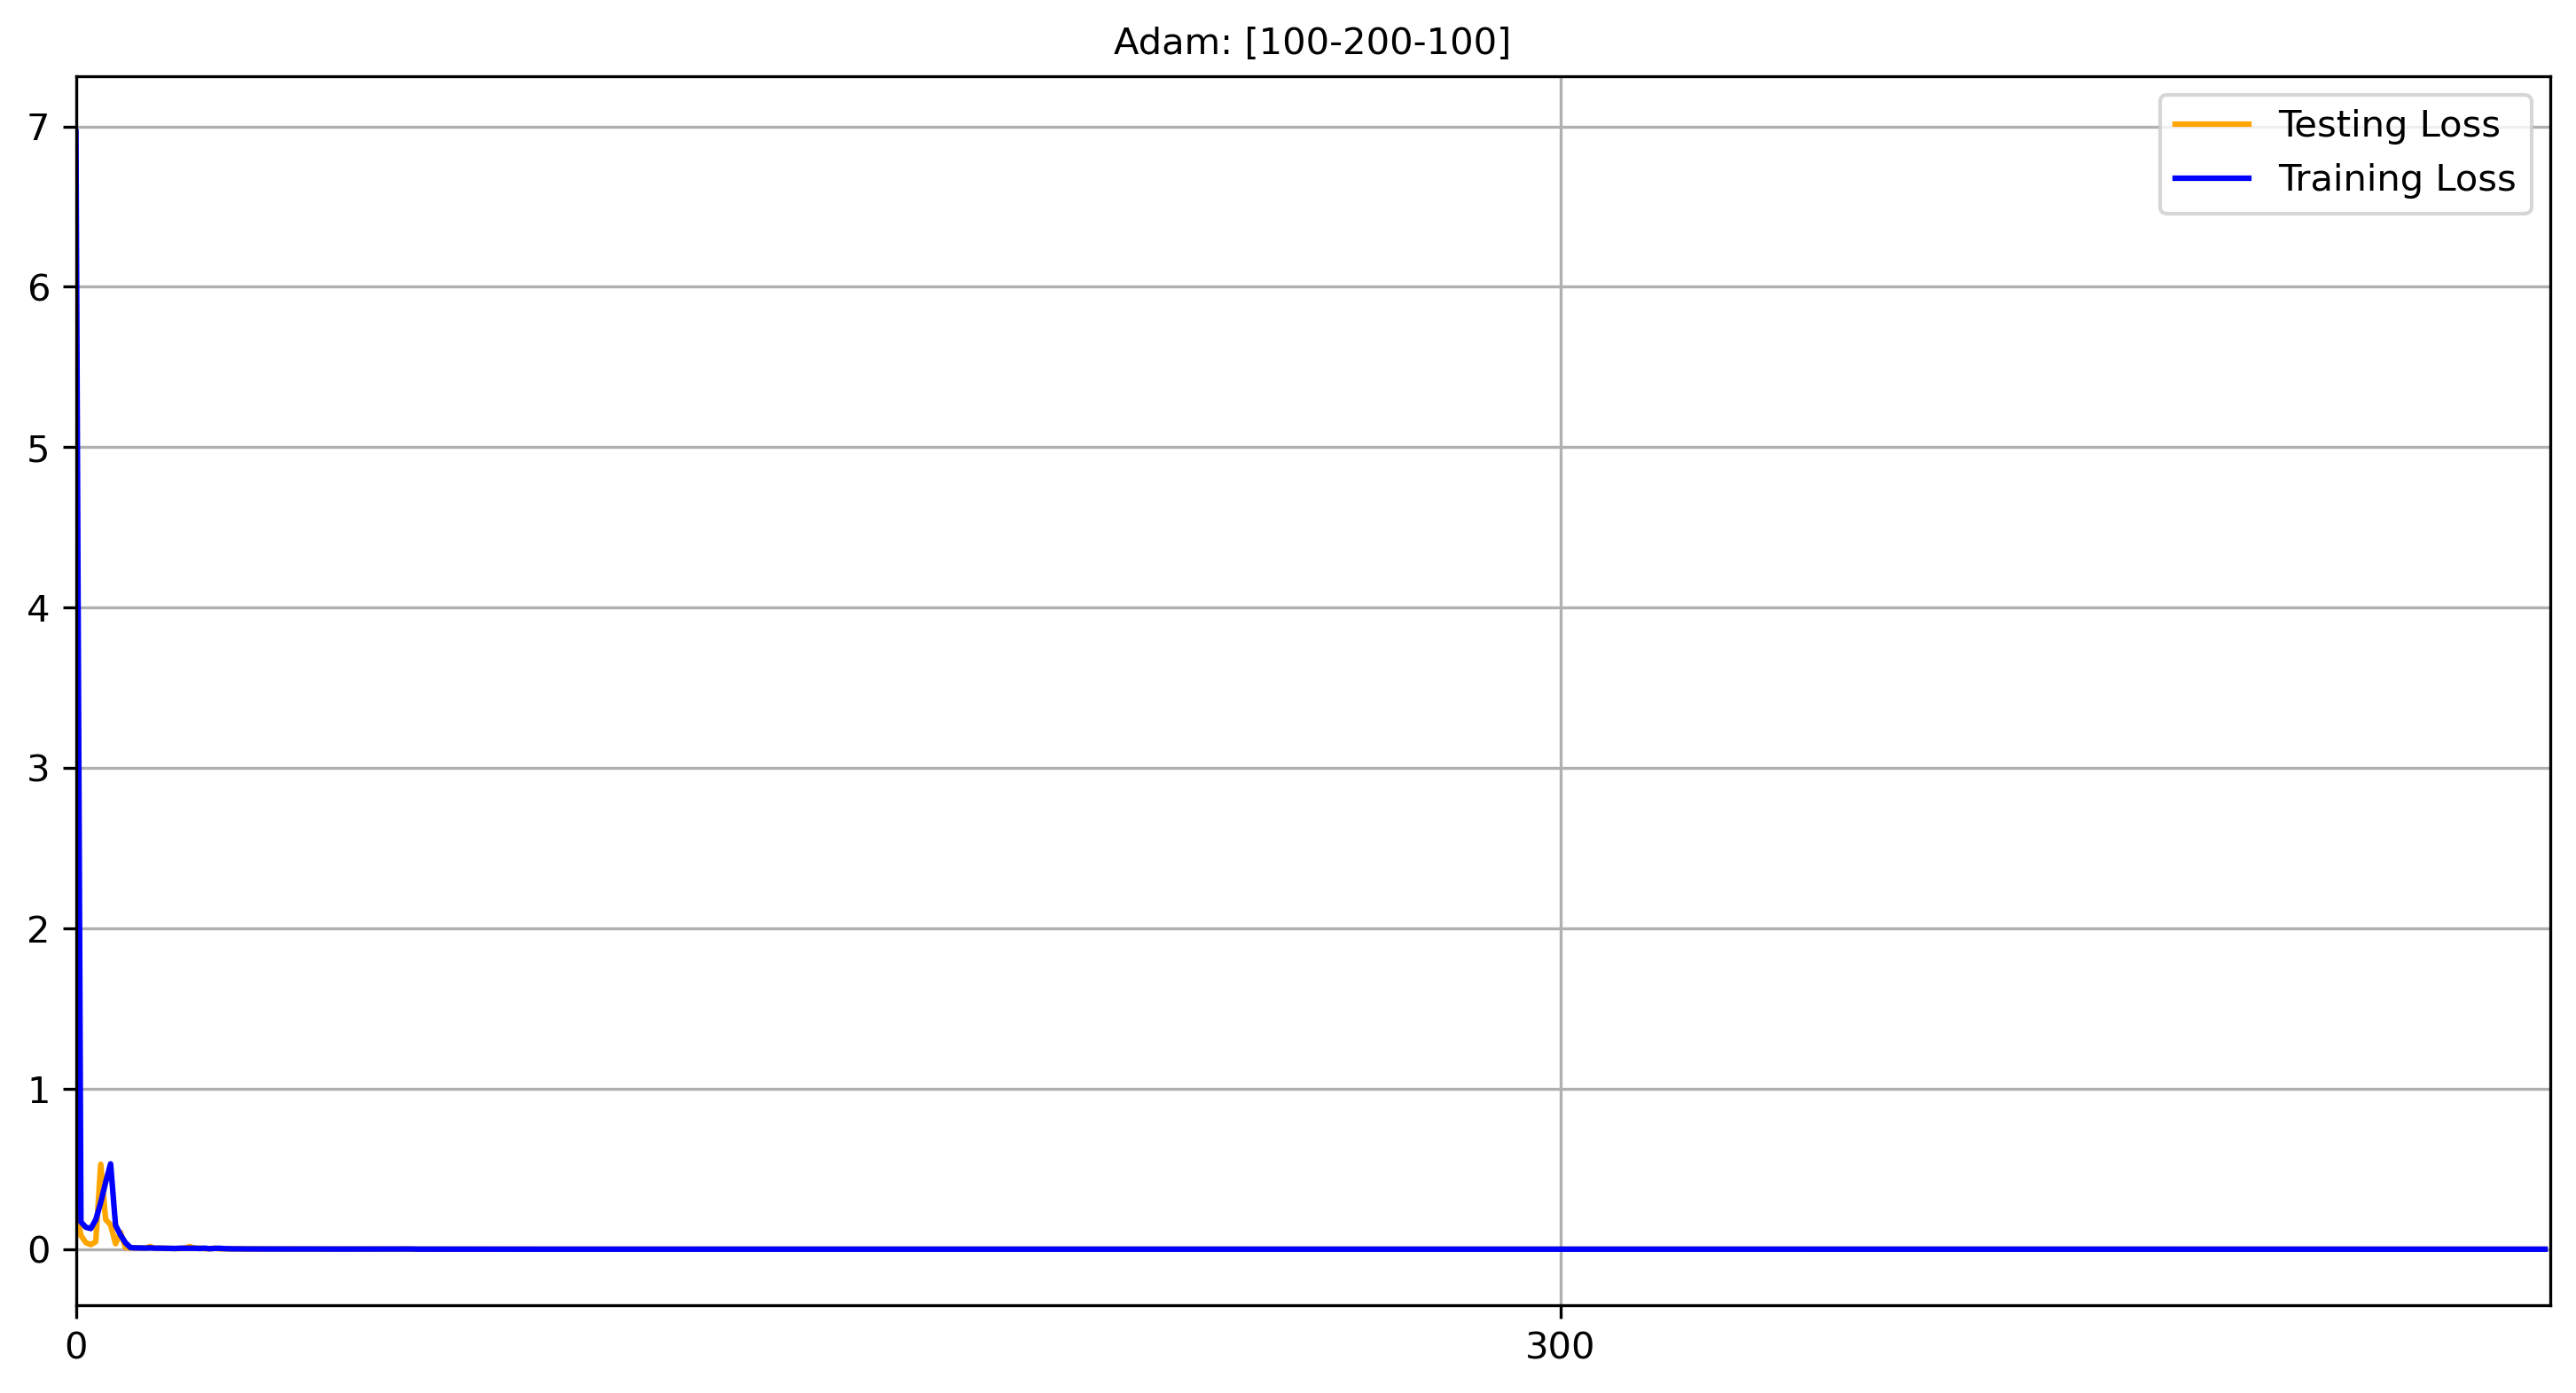

In [ ]:
graph_loss('Adam')

In [ ]:
curriculum = 2
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

In [ ]:
train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 2

model = MLP1L()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = True
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 300 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 600 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = 0.5
min_drop_tolerance = 0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'SGD_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'SGD_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'SGD_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

001: Restarting...
Epoch:000300 done. Time elapsed:0.144000 sec.
002: Restarting...
Epoch:000300 done. Time elapsed:0.286143 sec.
Epoch:000301 done. Time elapsed:0.431144 sec.
Epoch:000302 done. Time elapsed:0.550144 sec.
Epoch:000303 done. Time elapsed:0.681143 sec.
Epoch:000304 done. Time elapsed:0.815143 sec.
Epoch:000305 done. Time elapsed:0.930143 sec.
Epoch:000306 done. Time elapsed:1.090145 sec.
Epoch:000307 done. Time elapsed:1.226143 sec.
Epoch:000308 done. Time elapsed:1.344144 sec.
Epoch:000309 done. Time elapsed:1.464145 sec.
Epoch:000310 done. Time elapsed:1.579144 sec.
Epoch:000311 done. Time elapsed:1.746146 sec.
Epoch:000312 done. Time elapsed:1.892146 sec.
Epoch:000313 done. Time elapsed:2.049145 sec.
Epoch:000314 done. Time elapsed:2.176145 sec.
Epoch:000315 done. Time elapsed:2.306145 sec.
Epoch:000316 done. Time elapsed:2.483147 sec.
Epoch:000317 done. Time elapsed:2.605144 sec.
Epoch:000318 done. Time elapsed:2.720143 sec.
Epoch:000319 done. Time elapsed:2.859147 s

Curriculum:02 Batchsize:{batchsize}
last epoch: 600
Training Accuracy: 100.00%
Testing Accuracy: 99.84%


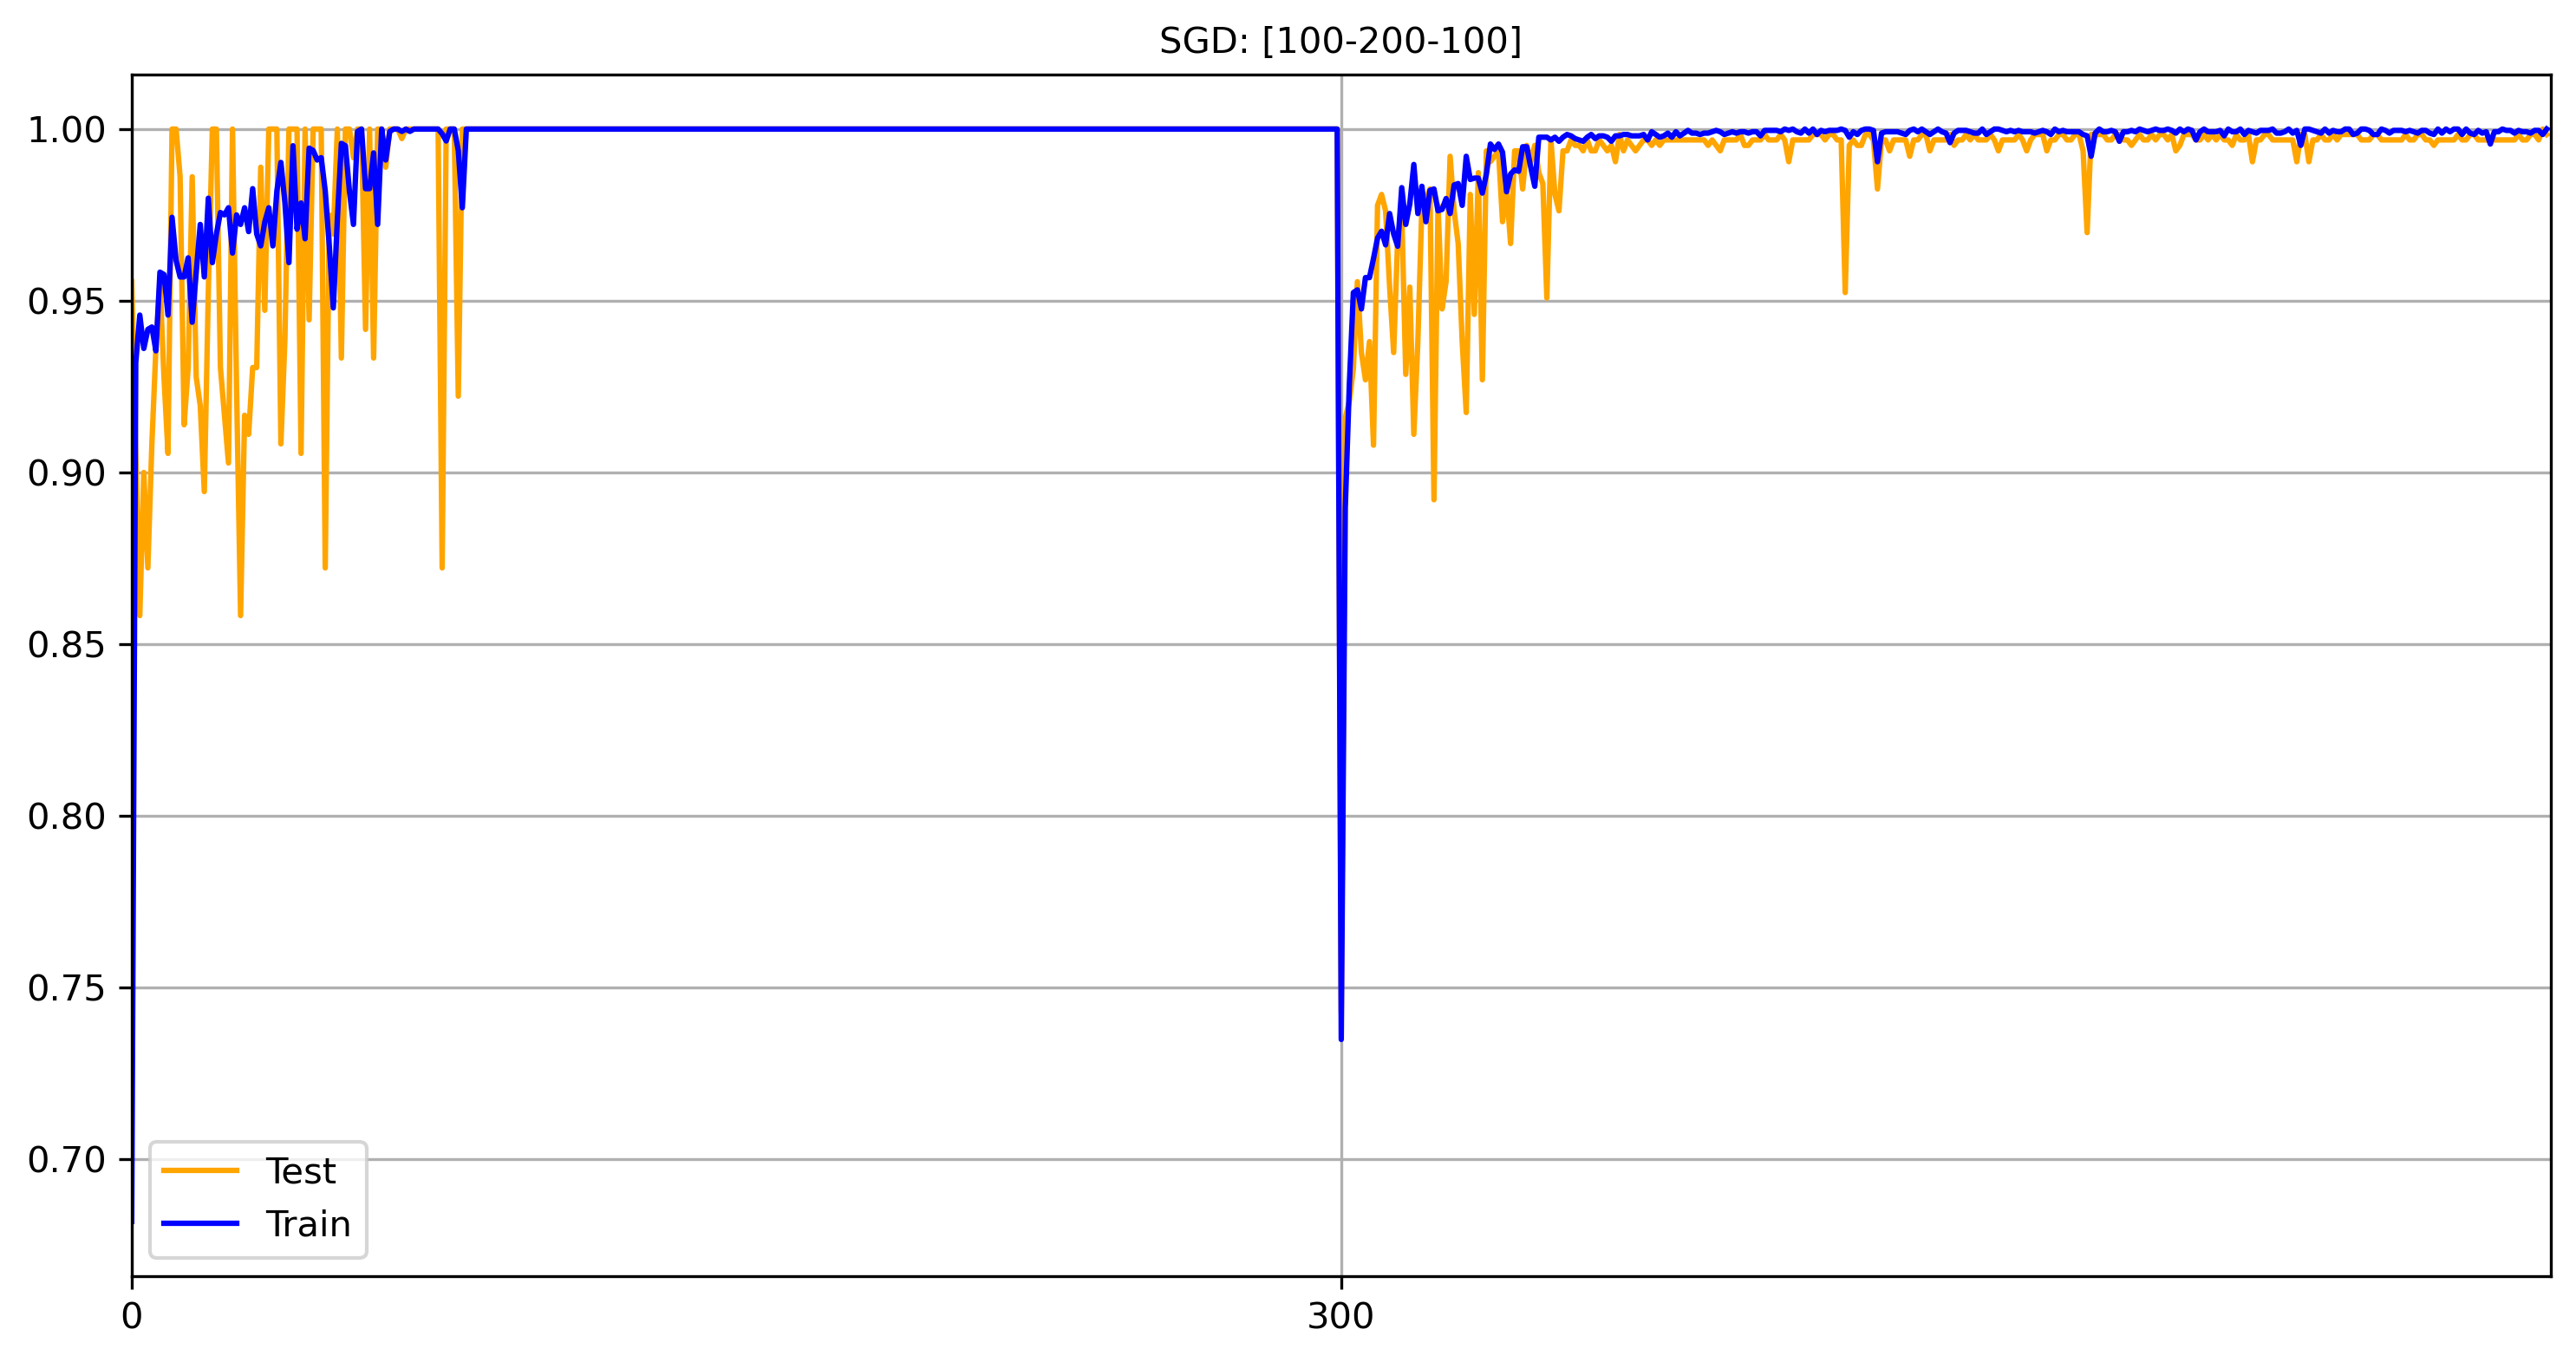

In [ ]:
graph_accu('SGD')

Curriculum:02 Batchsize:{batchsize}
last epoch: 600
Training Loss: 0.19%
Testing Loss: 0.82%


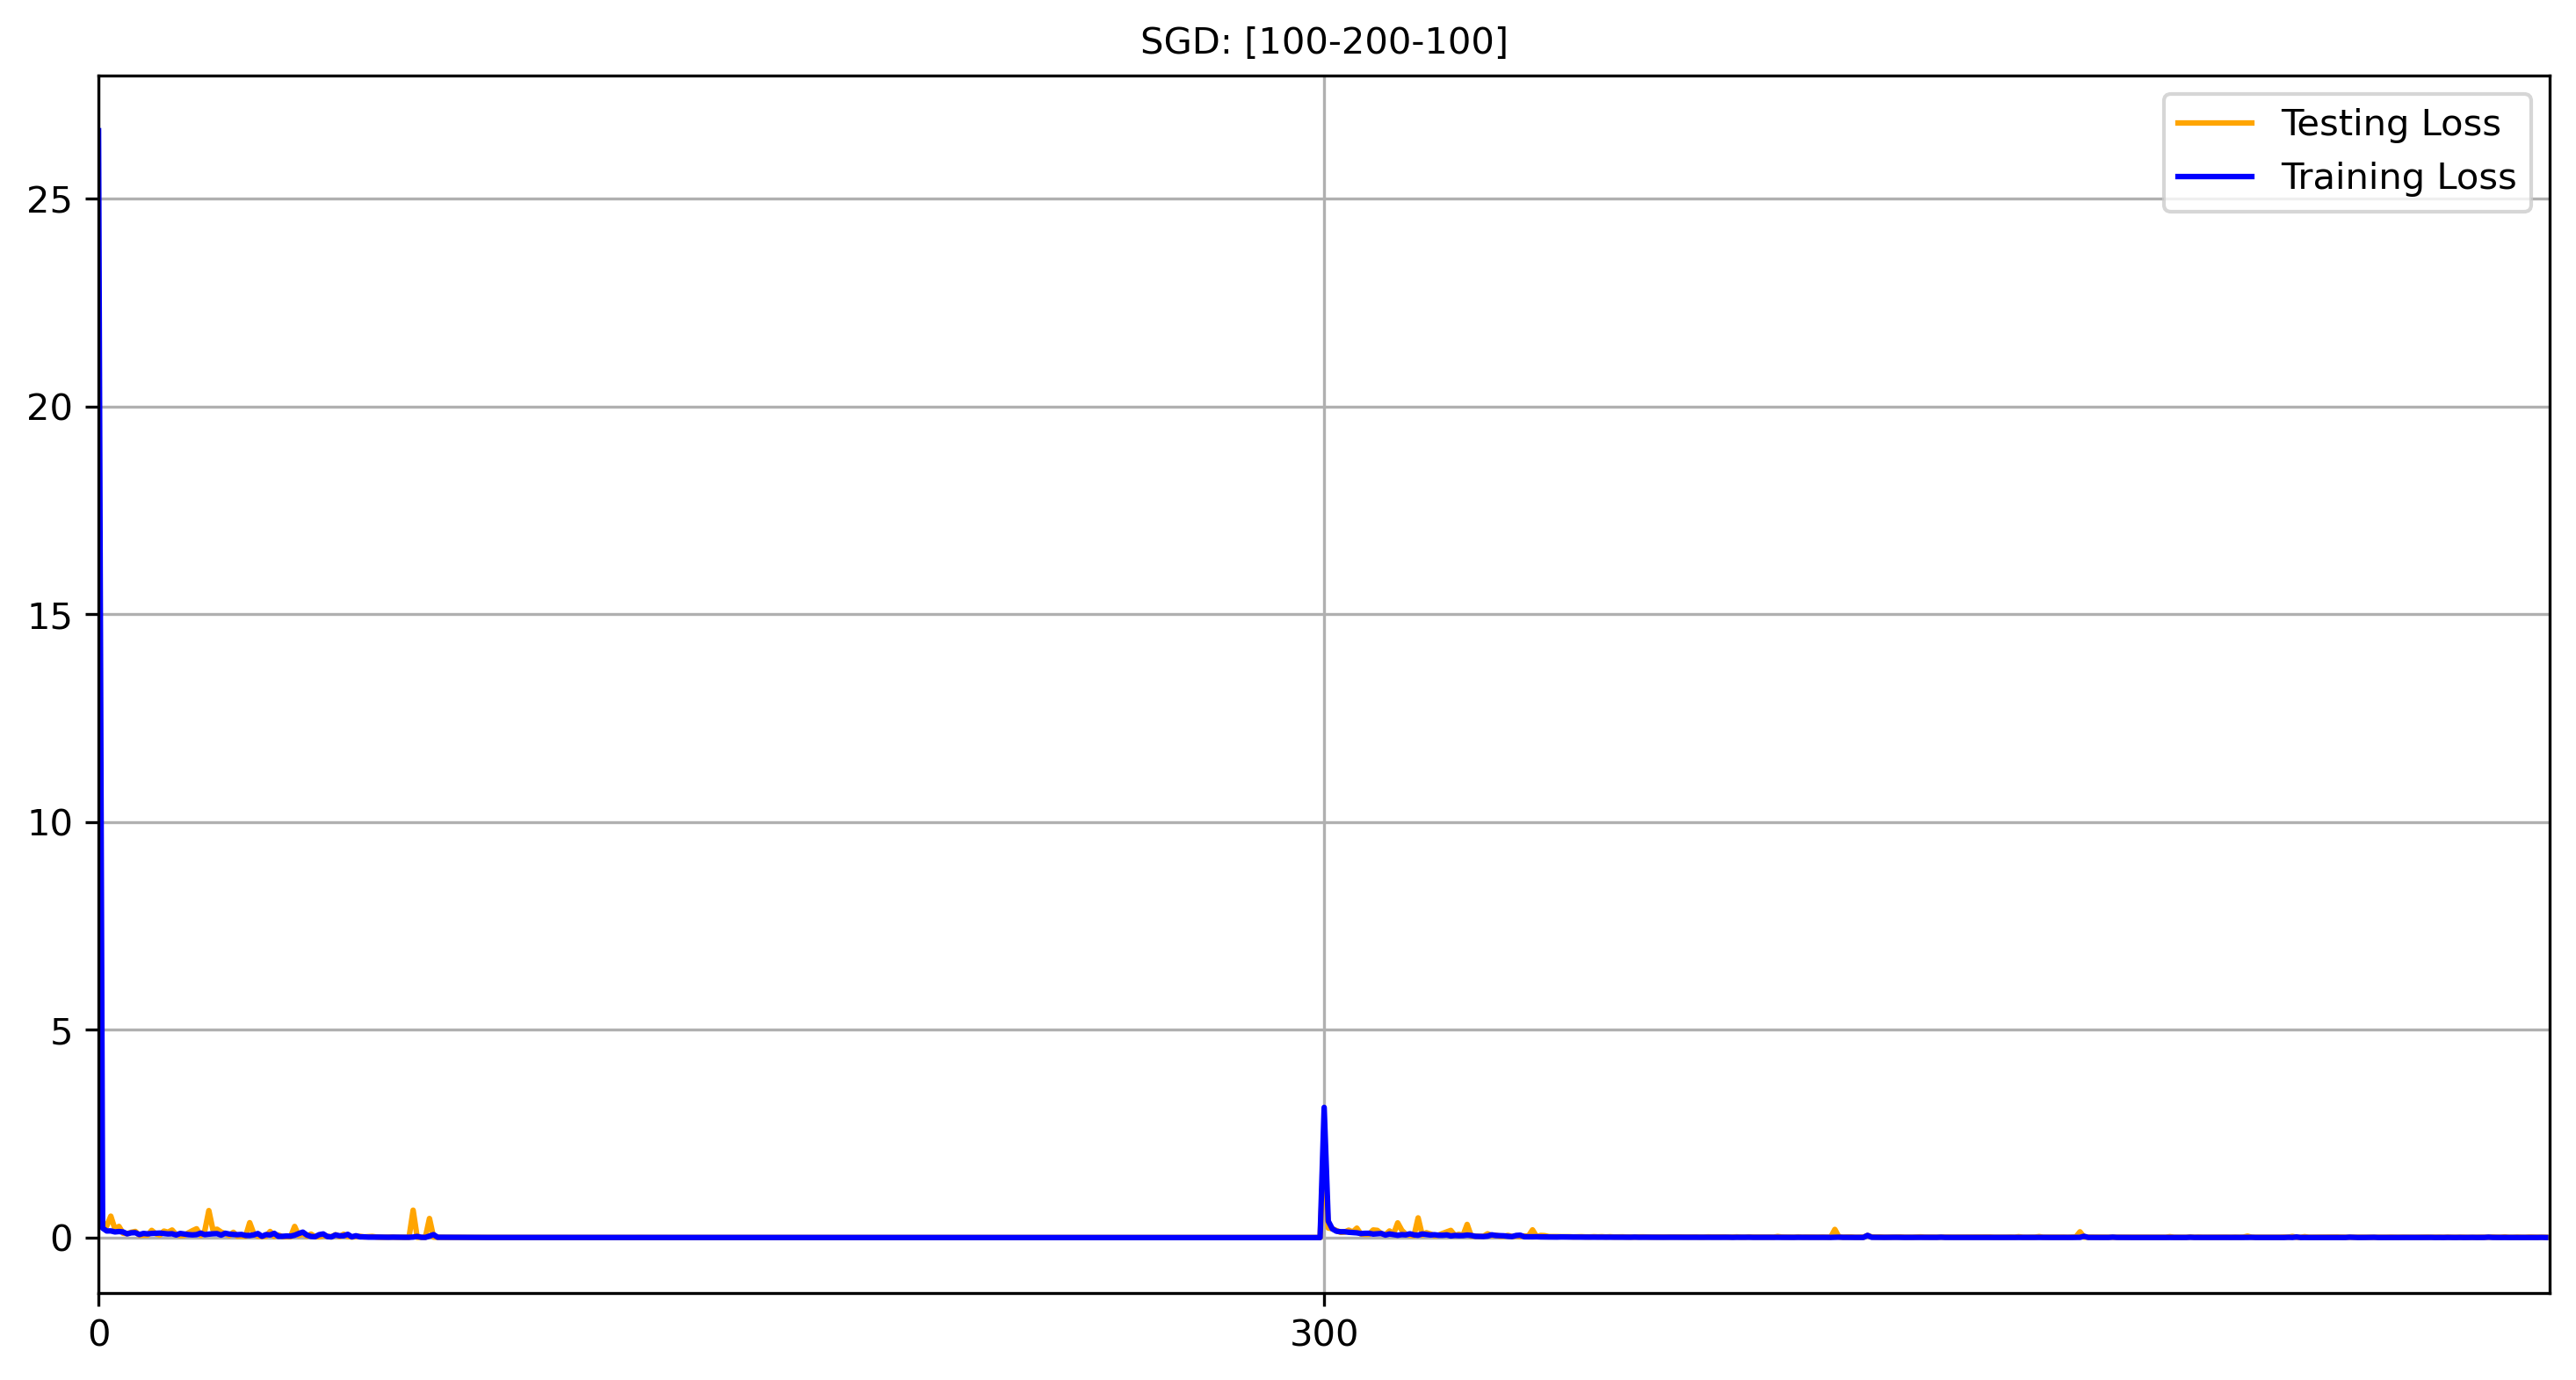

In [ ]:
graph_loss('SGD')

In [ ]:
#Choose curricululum to train
curriculum = 2

model = MLP1L()

#learning_rate = 1e-3
#Set minibatch size
#batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = True
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 300 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 600 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
#mid_drop_tolerance = 0.05
min_drop_tolerance = -0.01 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'Adam_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'Adam_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'Adam_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000301 done. Time elapsed:0.164229 sec.
Epoch:000302 done. Time elapsed:0.289242 sec.
Epoch:000303 done. Time elapsed:0.419498 sec.
Epoch:000304 done. Time elapsed:0.543510 sec.
Epoch:000305 done. Time elapsed:0.679612 sec.
Epoch:000306 done. Time elapsed:0.849609 sec.
Epoch:000307 done. Time elapsed:0.990610 sec.
Epoch:000308 done. Time elapsed:1.155606 sec.
Epoch:000309 done. Time elapsed:1.284607 sec.
Epoch:000310 done. Time elapsed:1.406607 sec.
Epoch:000311 done. Time elapsed:1.572833 sec.
Epoch:000312 done. Time elapsed:1.692854 sec.
Epoch:000313 done. Time elapsed:1.814832 sec.
Epoch:000314 done. Time elapsed:1.935833 sec.
001: Restarting...
Epoch:000314 done. Time elapsed:2.138832 sec.
Epoch:000315 done. Time elapsed:2.266833 sec.
Epoch:000316 done. Time elapsed:2.433833 sec.
Epoch:000317 done. Time elapsed:2.552834 sec.
Epoch:000318 done. Time elapsed:2.680831 sec.
001: Restarting...
Epoch:000318 done. Time elapsed:2.842918 sec.
002: Restarting...
Epoch:000318 done. Time

Curriculum:02 Batchsize:{batchsize}
last epoch: 600
Training Accuracy: 95.72%
Testing Accuracy: 92.78%


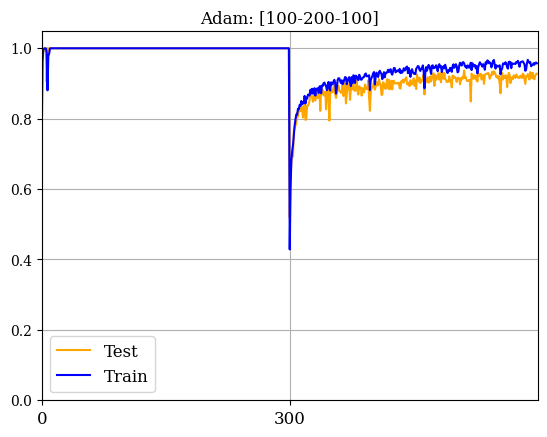

In [ ]:
graph_accu('Adam')

Curriculum:02 Batchsize:{batchsize}
last epoch: 600
Training Loss: 0.76%
Testing Loss: 1.10%


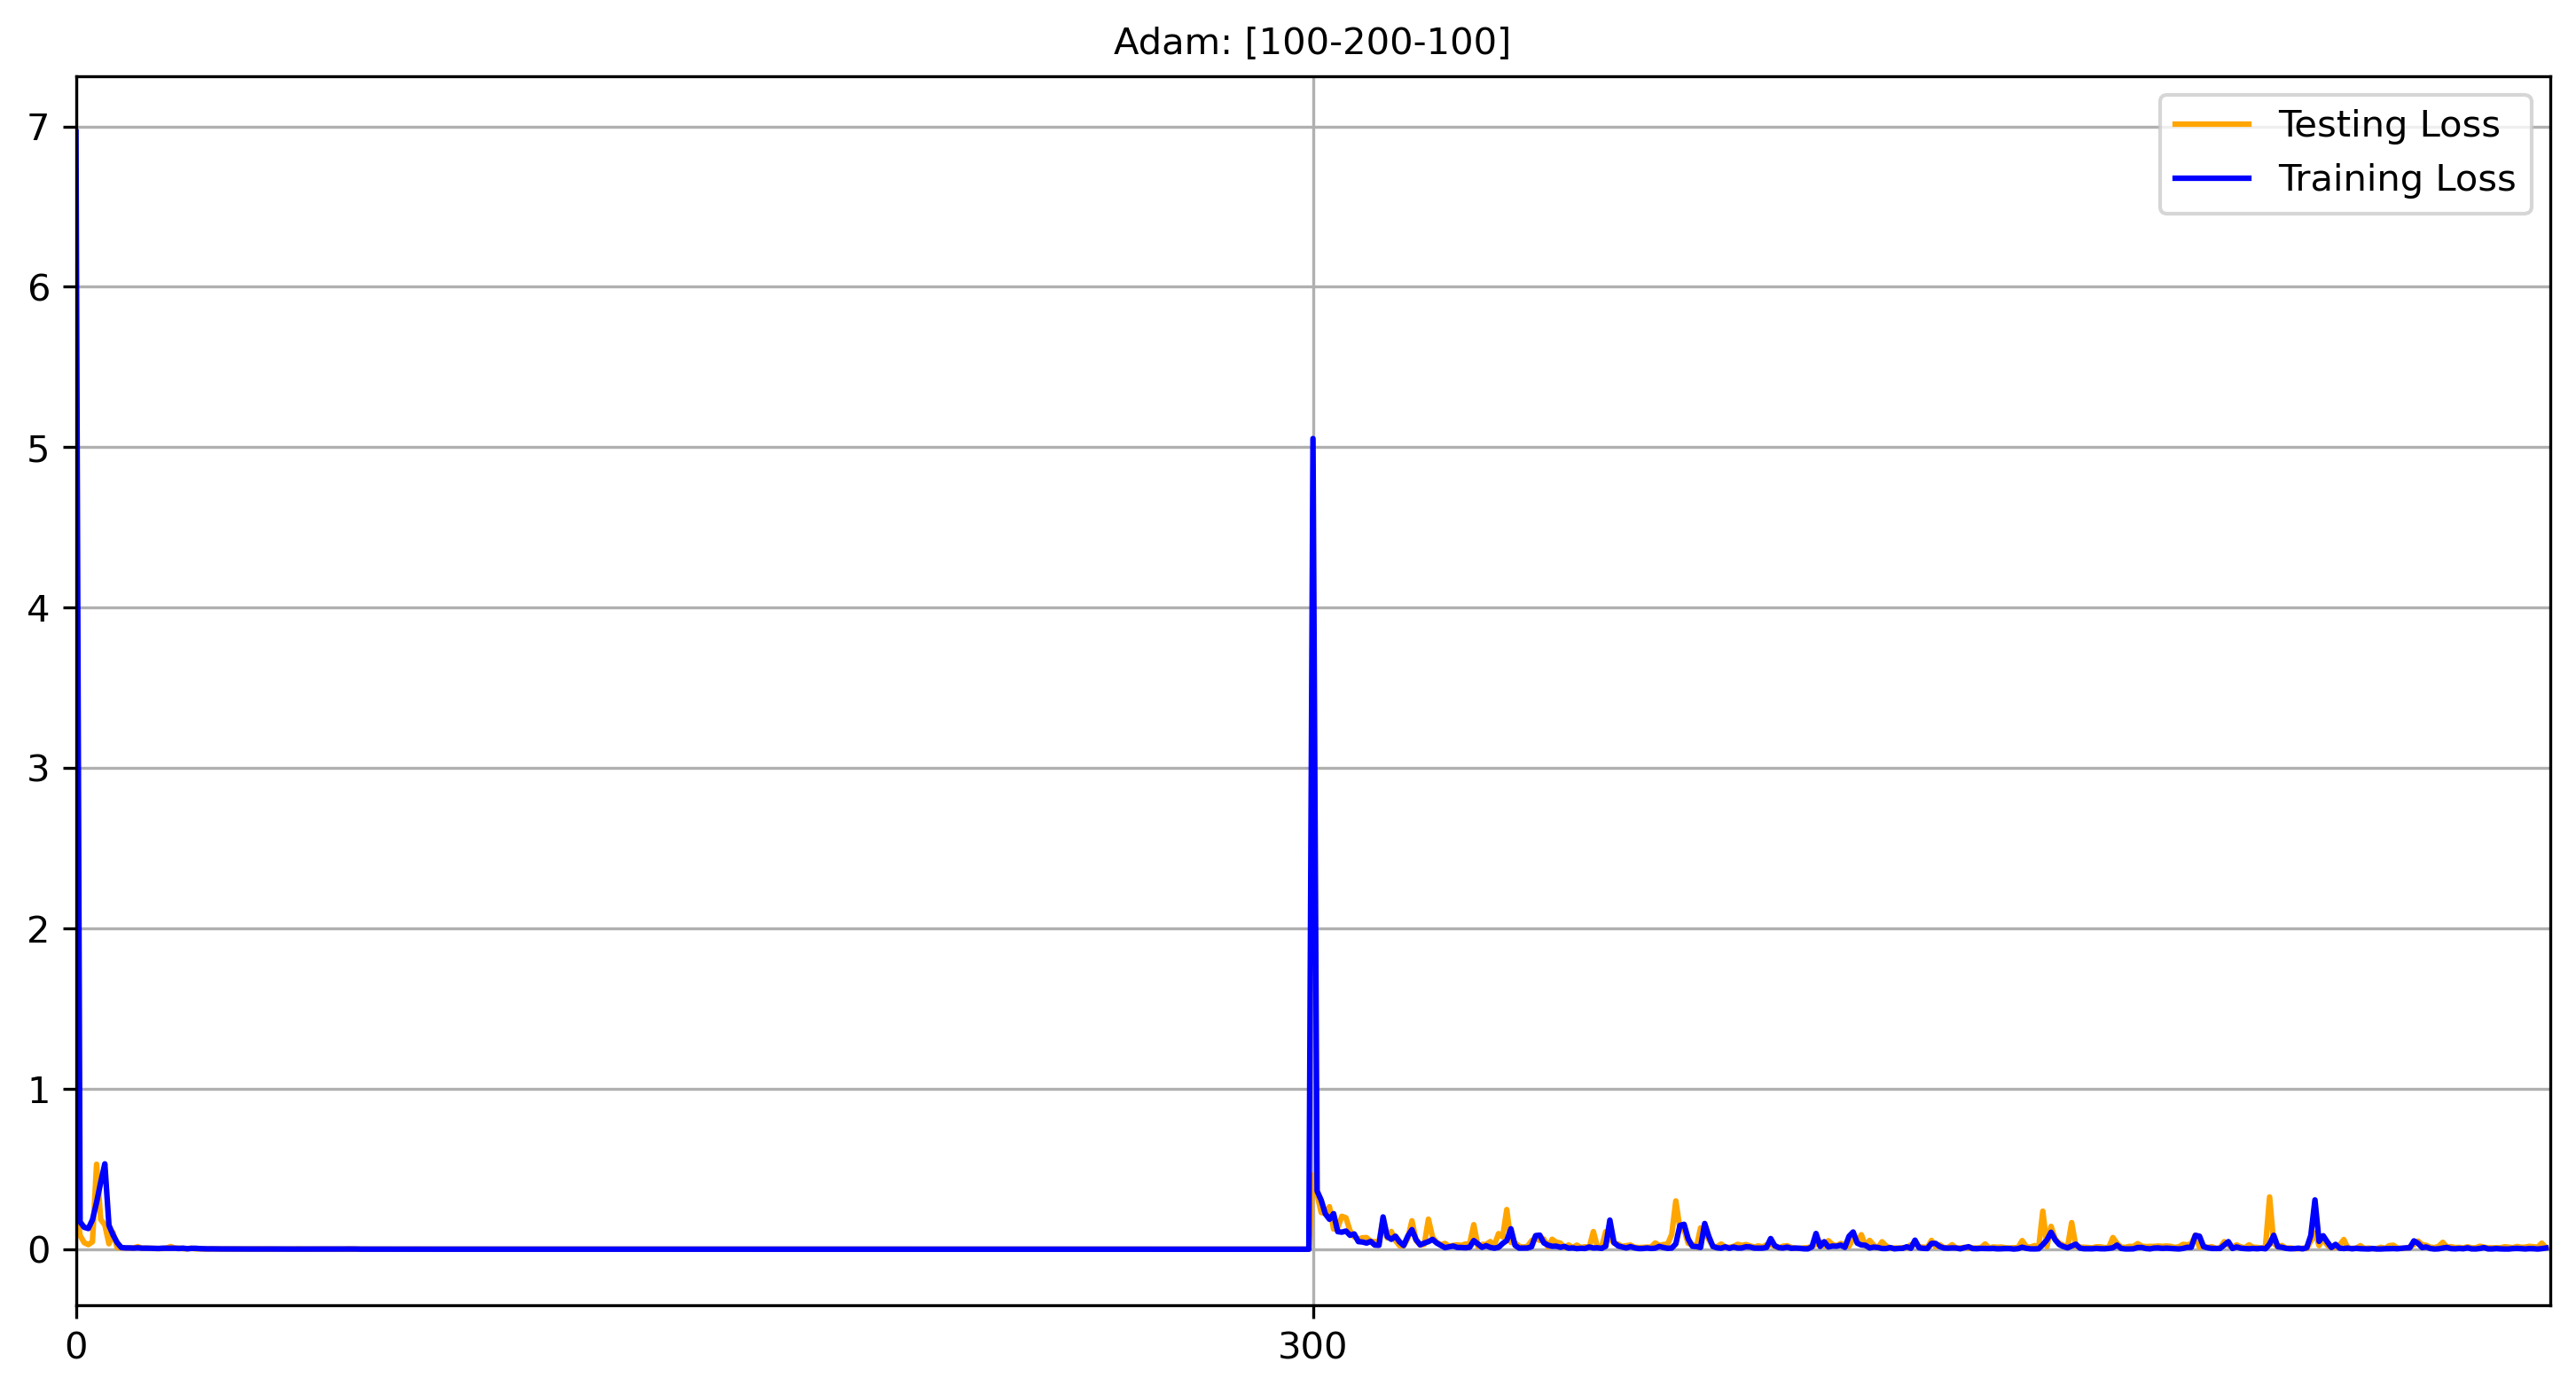

In [ ]:
graph_loss('Adam')

In [ ]:
curriculum = 3
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

In [ ]:
train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
curriculum = 3

model = MLP1L()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = True
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 600 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 1000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'SGD_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'SGD_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'SGD_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000601 done. Time elapsed:0.219000 sec.
Epoch:000602 done. Time elapsed:0.384004 sec.
Epoch:000603 done. Time elapsed:0.550999 sec.
Epoch:000604 done. Time elapsed:0.712003 sec.
001: Restarting...
Epoch:000604 done. Time elapsed:0.917000 sec.
Epoch:000605 done. Time elapsed:1.076999 sec.
Epoch:000606 done. Time elapsed:1.287000 sec.
Epoch:000607 done. Time elapsed:1.448001 sec.
Epoch:000608 done. Time elapsed:1.621000 sec.
Epoch:000609 done. Time elapsed:1.786002 sec.
Epoch:000610 done. Time elapsed:1.954000 sec.
Epoch:000611 done. Time elapsed:2.169003 sec.
Epoch:000612 done. Time elapsed:2.334000 sec.
Epoch:000613 done. Time elapsed:2.501999 sec.
Epoch:000614 done. Time elapsed:2.673000 sec.
Epoch:000615 done. Time elapsed:2.839003 sec.
Epoch:000616 done. Time elapsed:3.042000 sec.
Epoch:000617 done. Time elapsed:3.212003 sec.
Epoch:000618 done. Time elapsed:3.379000 sec.
Epoch:000619 done. Time elapsed:3.543000 sec.
Epoch:000620 done. Time elapsed:3.762002 sec.
Epoch:000621 do

Curriculum:03 Batchsize:{batchsize}
last epoch: 1000
Training Accuracy: 97.17%
Testing Accuracy: 90.56%


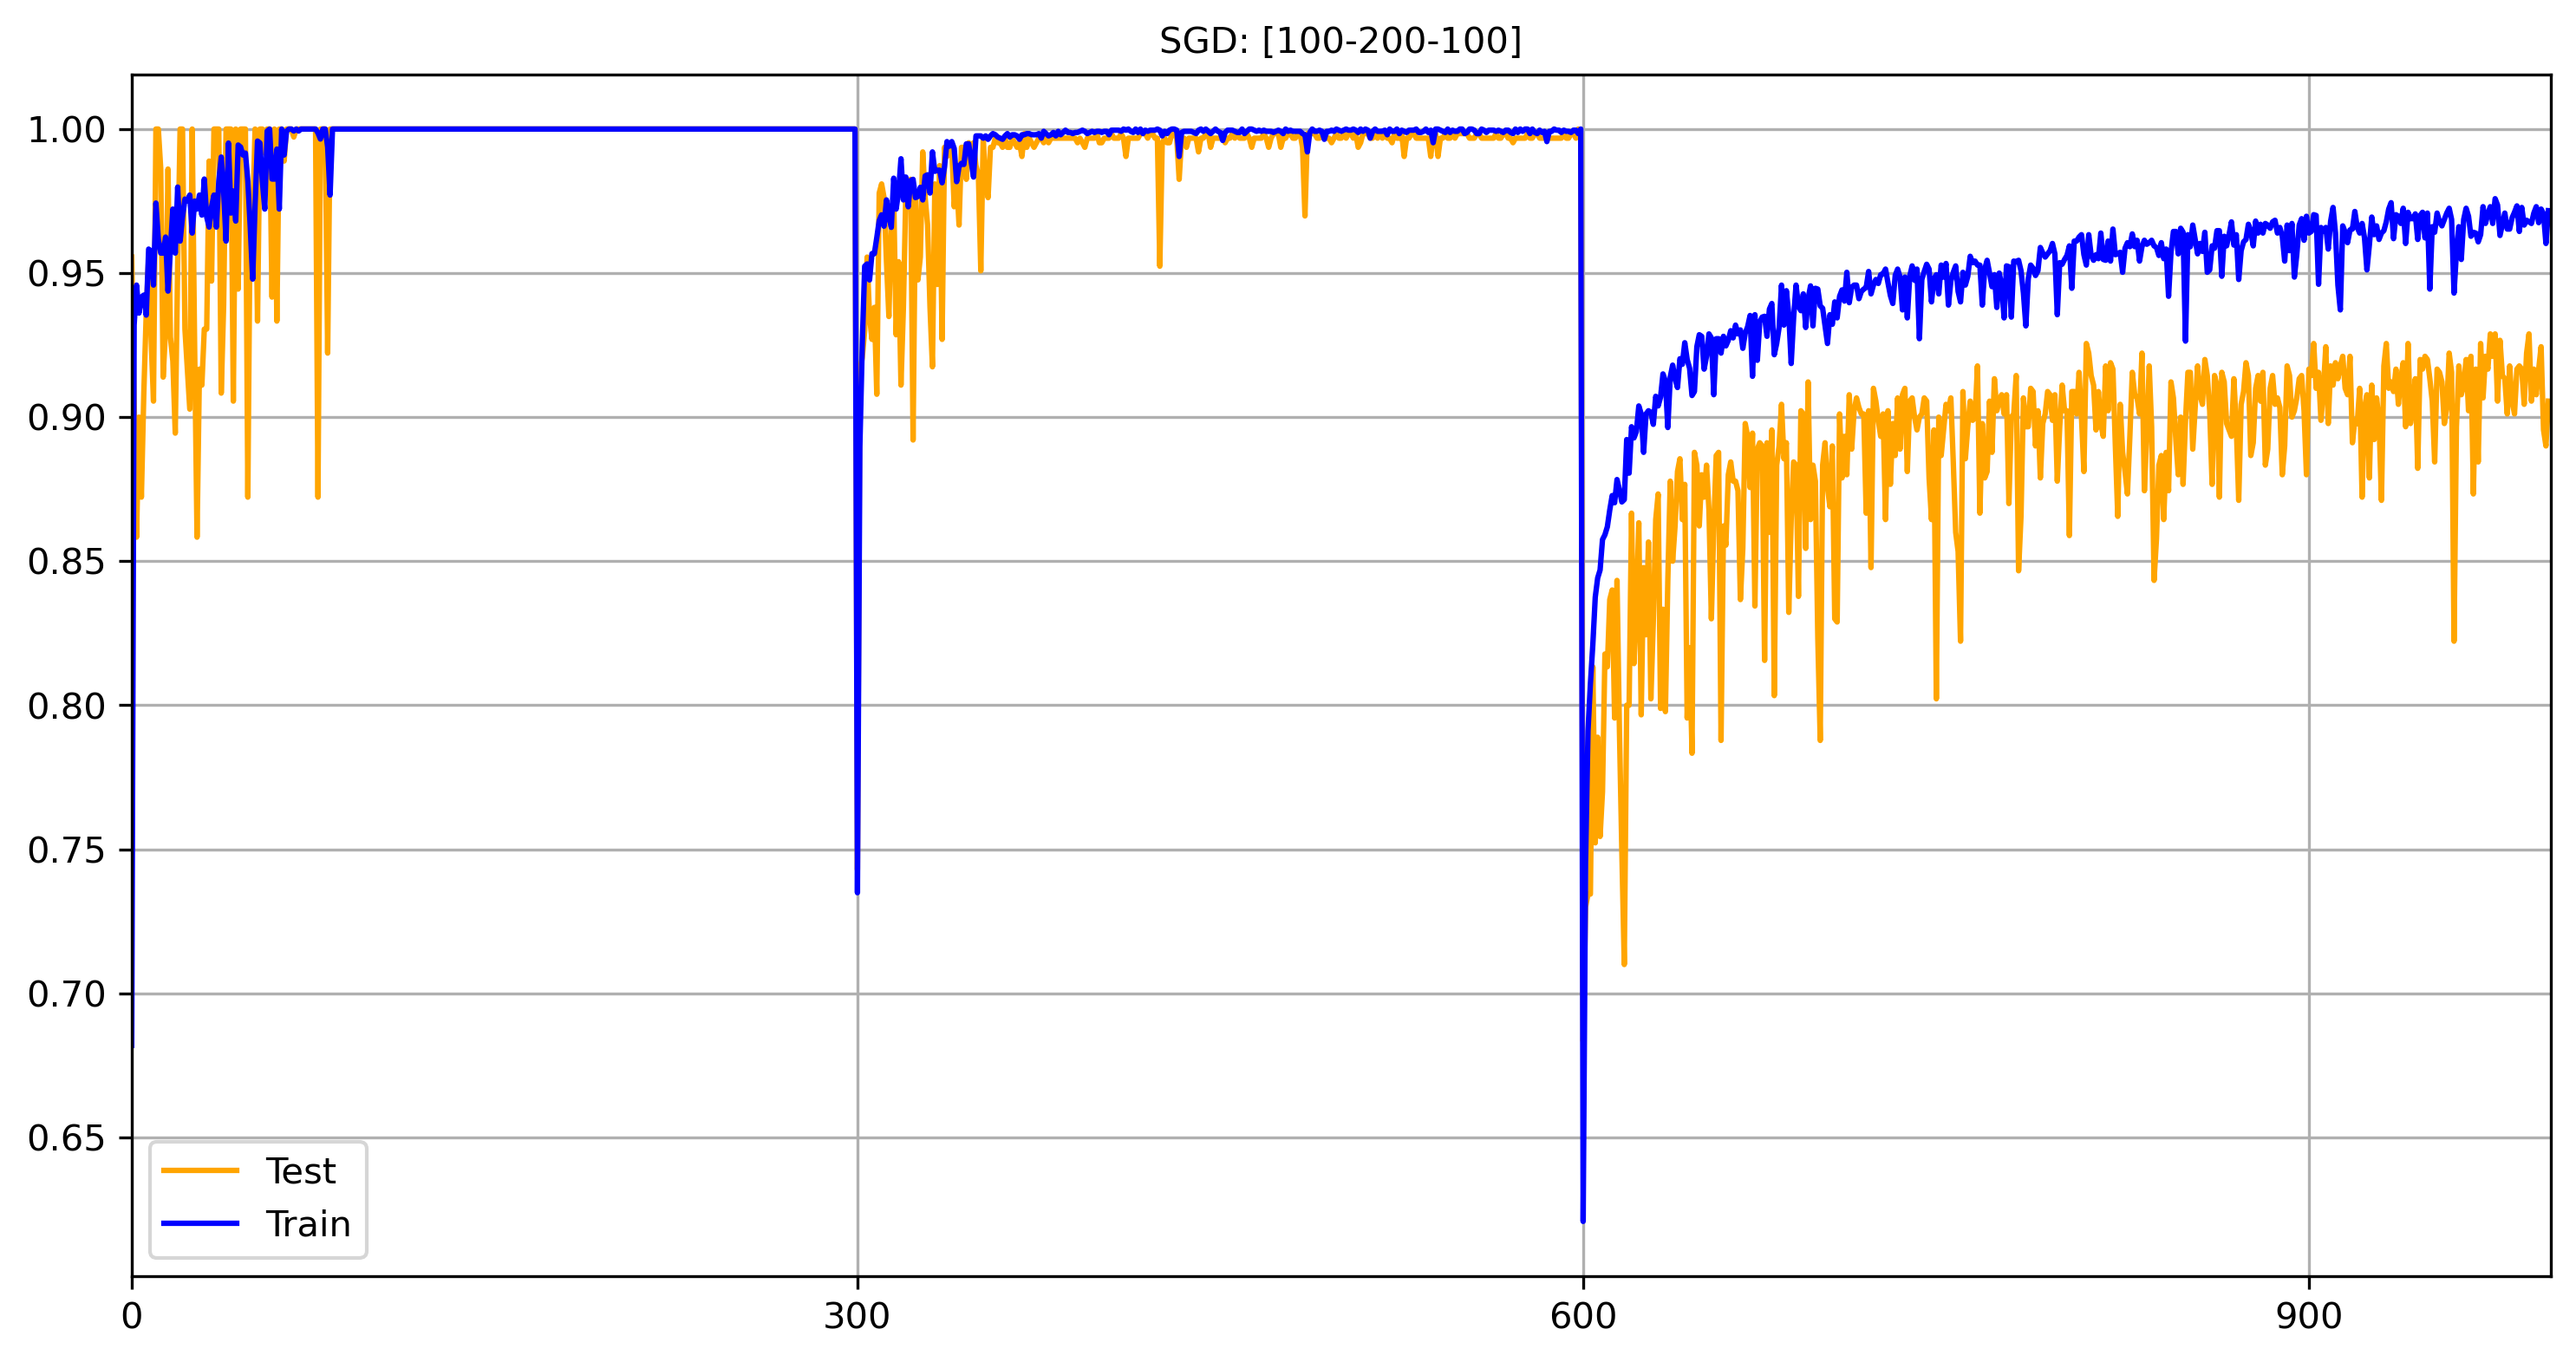

In [ ]:
graph_accu('SGD')

Curriculum:03 Batchsize:{batchsize}
last epoch: 1000
Training Loss: 7.52%
Testing Loss: 33.81%


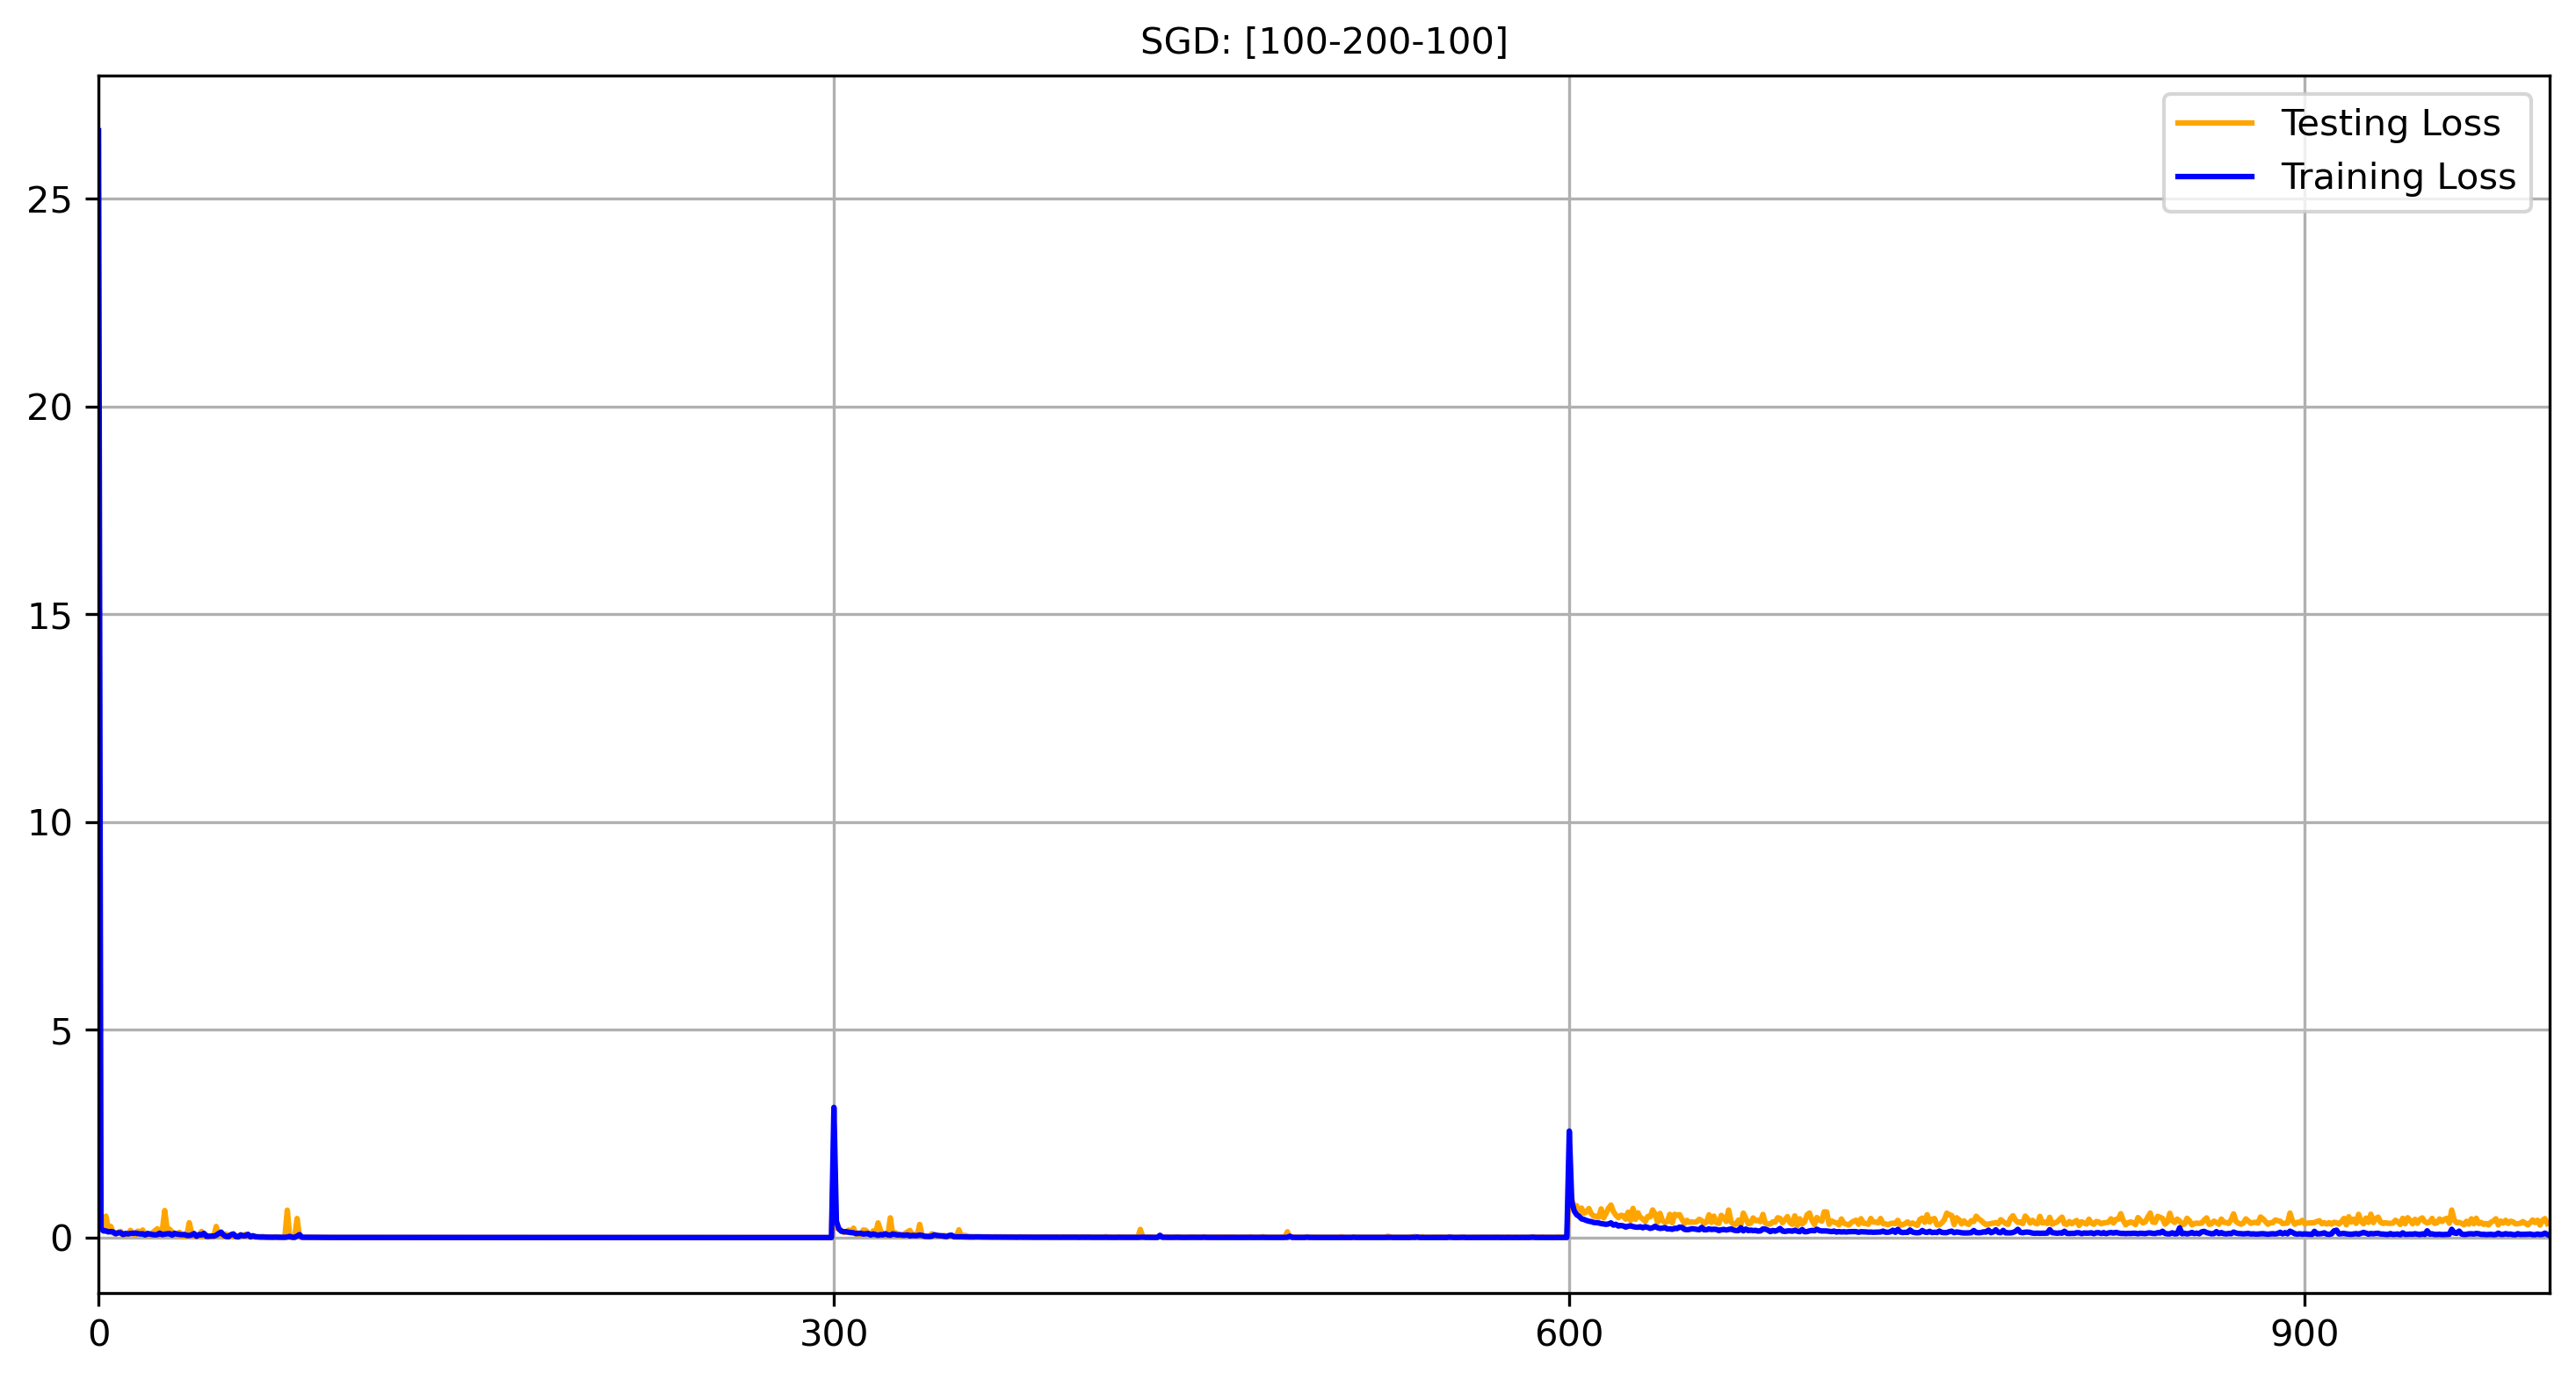

In [ ]:
graph_loss('SGD')

In [ ]:
#Choose curricululum to train
curriculum = 3

model = MLP1L()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = True
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 600 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 900 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
#mid_drop_tolerance = -0.05
min_drop_tolerance = -0.01 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'Adam_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'Adam_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'Adam_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:000601 done. Time elapsed:0.202000 sec.
Epoch:000602 done. Time elapsed:0.369999 sec.
Epoch:000603 done. Time elapsed:0.550001 sec.
Epoch:000604 done. Time elapsed:0.714998 sec.
Epoch:000605 done. Time elapsed:0.881999 sec.
Epoch:000606 done. Time elapsed:1.089001 sec.
Epoch:000607 done. Time elapsed:1.257999 sec.
Epoch:000608 done. Time elapsed:1.423999 sec.
Epoch:000609 done. Time elapsed:1.591000 sec.
Epoch:000610 done. Time elapsed:1.755999 sec.
Epoch:000611 done. Time elapsed:2.009786 sec.
Epoch:000612 done. Time elapsed:2.206832 sec.
Epoch:000613 done. Time elapsed:2.408825 sec.
Epoch:000614 done. Time elapsed:2.591825 sec.
Epoch:000615 done. Time elapsed:2.774826 sec.
Epoch:000616 done. Time elapsed:3.007843 sec.
Epoch:000617 done. Time elapsed:3.194879 sec.
001: Restarting...
Epoch:000617 done. Time elapsed:3.416879 sec.
002: Restarting...
Epoch:000617 done. Time elapsed:3.609879 sec.
Epoch:000618 done. Time elapsed:3.778879 sec.
Epoch:000619 done. Time elapsed:3.950879 s

In [ ]:
graph_accu('Adam')

Curriculum:03 Batchsize:{batchsize}
last epoch: 908
Training Loss: 10.11%
Testing Loss: 49.37%


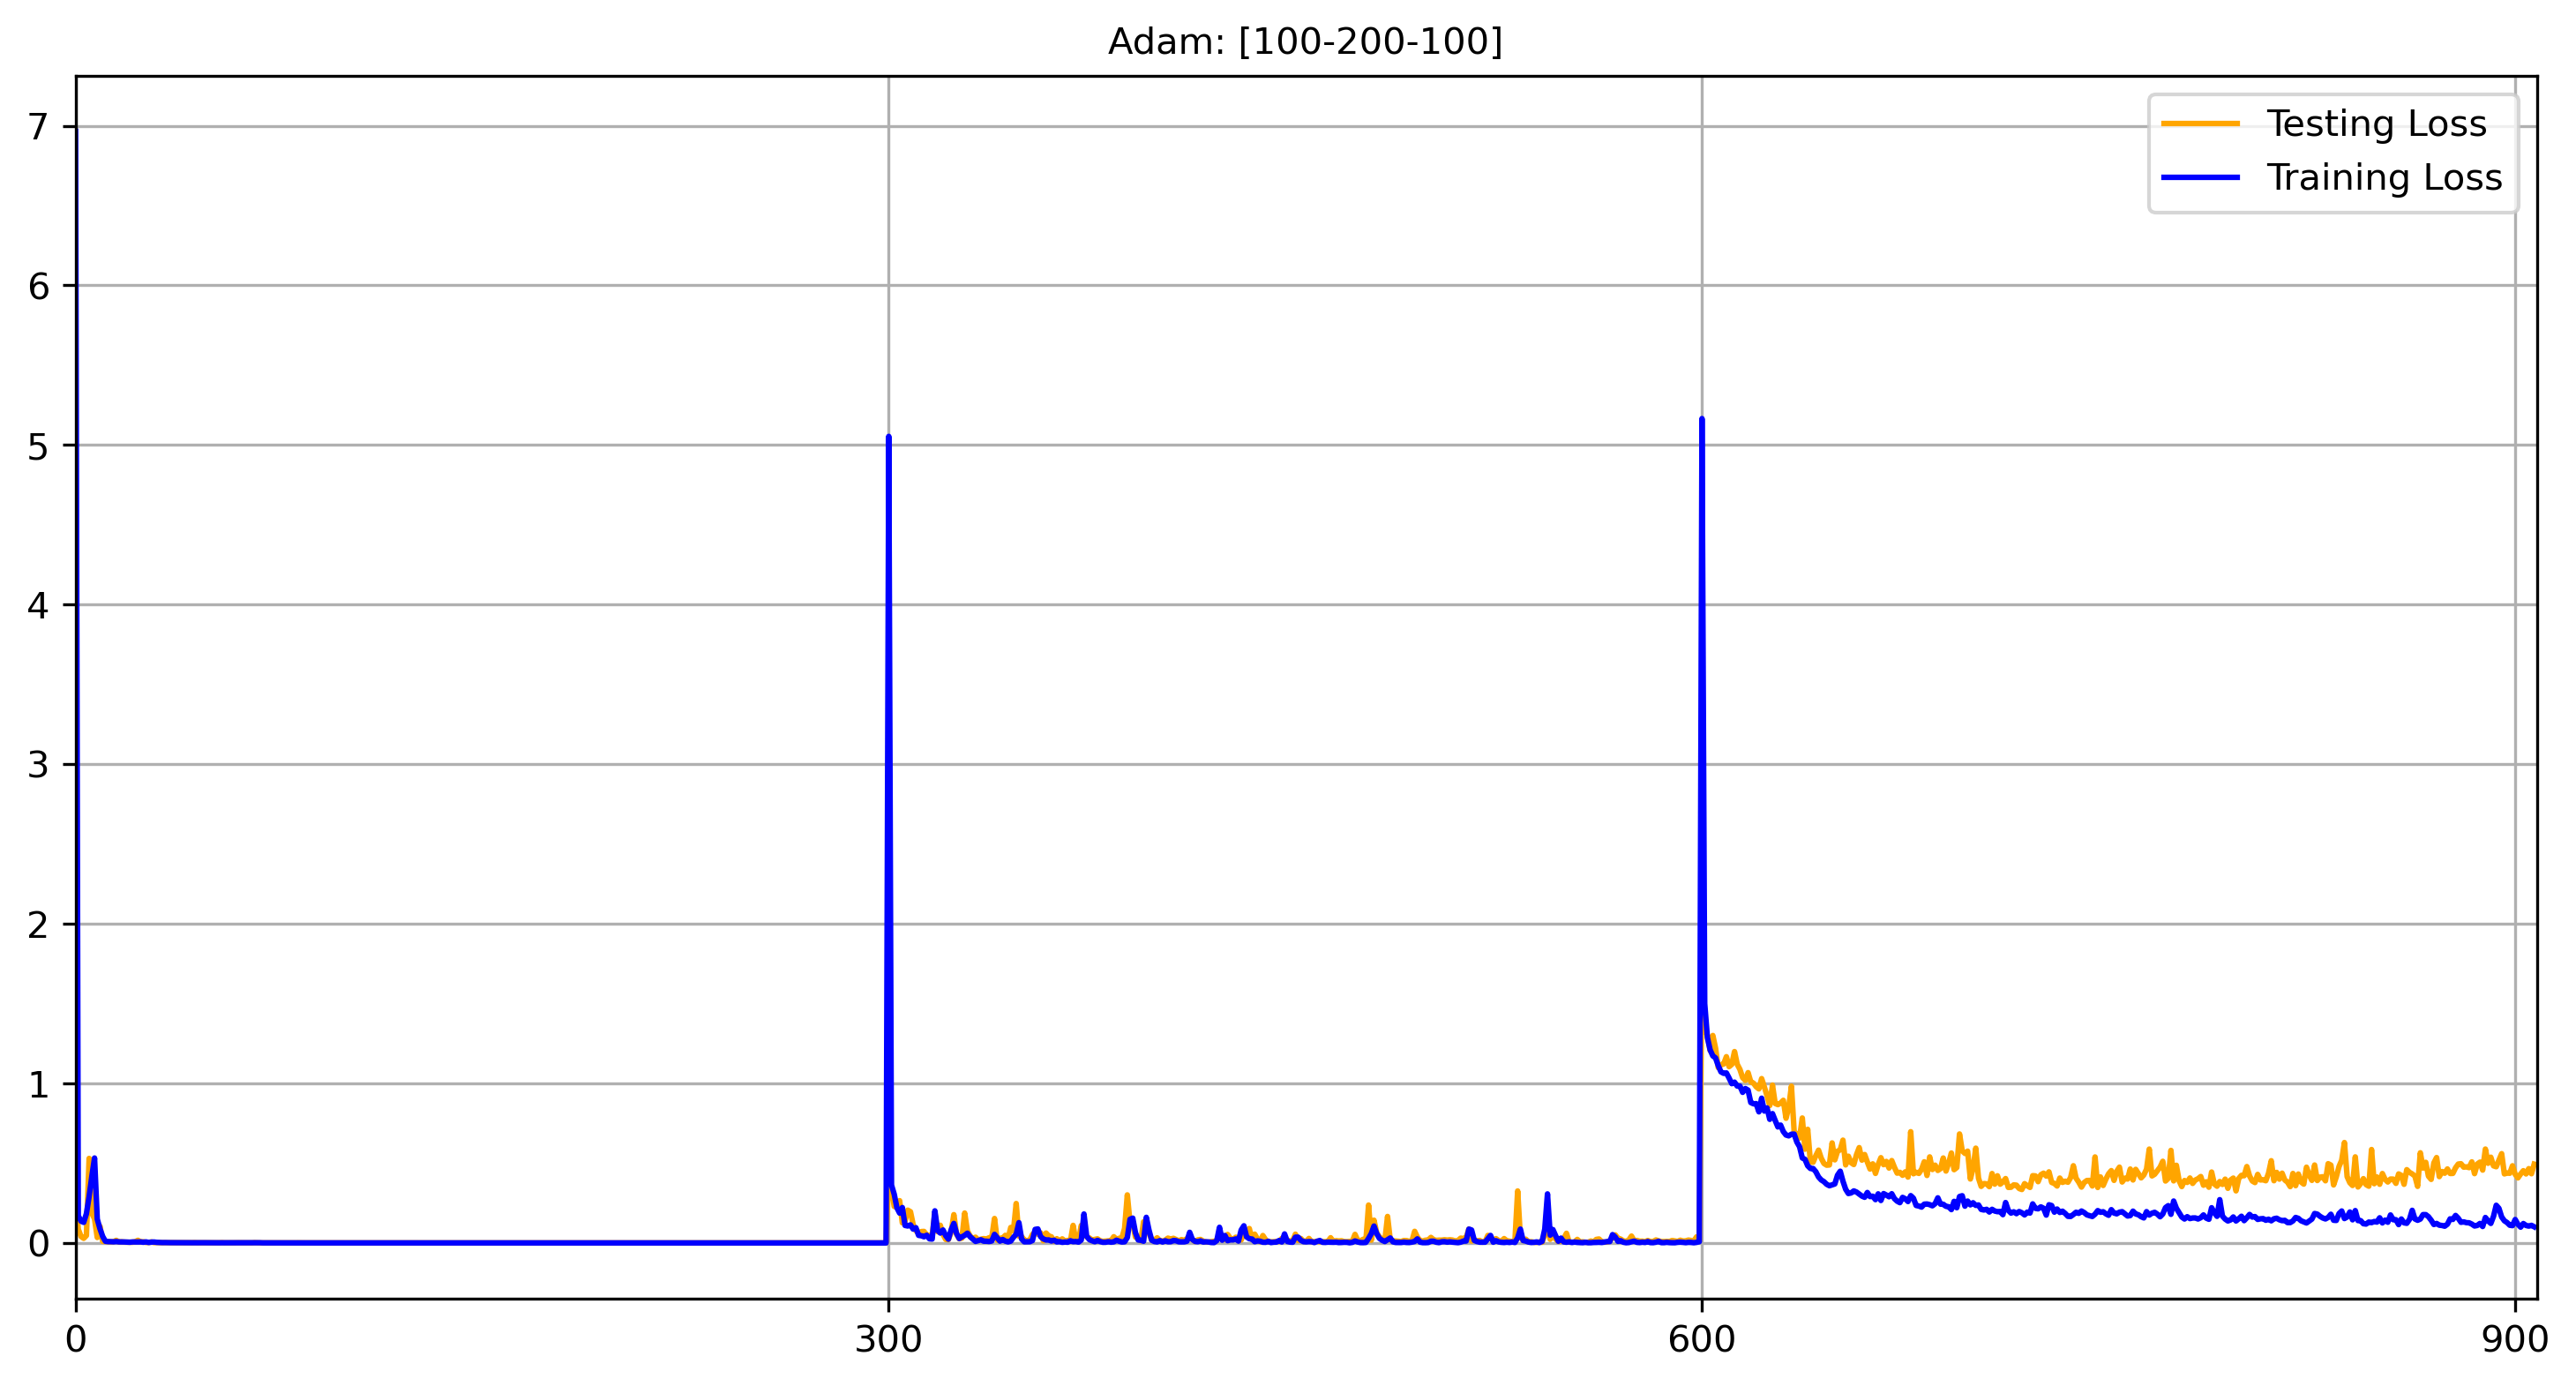

In [ ]:
graph_loss('Adam')

In [ ]:
curriculum = 6
directory = f"curriculum{curriculum:02d}_training"
train_plots = pickle.load(open(os.path.join(directory, f'train_plots_curr{curriculum:02d}.pkl'), 'rb'))
train_plots = torch.from_numpy(train_plots).type(torch.float).to(device)
test_plots = pickle.load(open(os.path.join(directory, f'test_plots_curr{curriculum:02d}.pkl'), 'rb'))
test_plots = torch.from_numpy(test_plots).type(torch.float).to(device)
train_labels = pickle.load(open(os.path.join(directory, f'train_labels_curr{curriculum:02d}.pkl'), 'rb'))
train_labels = torch.from_numpy(train_labels).type(torch.long).to(device)
test_labels = pickle.load(open(os.path.join(directory, f'test_labels_curr{curriculum:02d}.pkl'), 'rb'))
test_labels = torch.from_numpy(test_labels).type(torch.long).to(device)

In [ ]:
train_dataset = GraphDataset(train_plots, train_labels, transform=None)
test_dataset = GraphDataset(test_plots, test_labels, transform=None)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Choose curricululum to train
#curriculum = 6

model = MLP1L()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = True
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 1500 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 2000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
min_drop_tolerance = -0.05
#min_drop_tolerance = -0.005 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'SGD_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'SGD_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'SGD_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

C:\Users\vange\AppData\Local\Temp\ipykernel_7632\3266784761.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(path)


-0.31125
Epoch:001501 done. Time elapsed:2.190725 sec.
0.06722222222222218
Epoch:001502 done. Time elapsed:2.478724 sec.
0.0011111111111111738
Epoch:001503 done. Time elapsed:2.769266 sec.
0.028888888888888853
Epoch:001504 done. Time elapsed:3.073267 sec.
0.030555555555555558
Epoch:001505 done. Time elapsed:3.368267 sec.
0.0022222222222222365
Epoch:001506 done. Time elapsed:3.723103 sec.
0.0
Epoch:001507 done. Time elapsed:4.012110 sec.
0.007777777777777772
Epoch:001508 done. Time elapsed:4.303098 sec.
0.02444444444444438
Epoch:001509 done. Time elapsed:4.594096 sec.
0.0
Epoch:001510 done. Time elapsed:4.894098 sec.
-0.0022222222222221255
Epoch:001511 done. Time elapsed:5.296111 sec.
0.011111111111111072
Epoch:001512 done. Time elapsed:5.621097 sec.
-0.01388888888888895
Epoch:001513 done. Time elapsed:5.934096 sec.
0.0011111111111111738
Epoch:001514 done. Time elapsed:6.225096 sec.
0.0033333333333332993
Epoch:001515 done. Time elapsed:6.564097 sec.
0.013333333333333308
Epoch:001516 don

C:\Users\vange\AppData\Local\Temp\ipykernel_7632\3266784761.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(path)


-0.023333333333333317
Epoch:001531 done. Time elapsed:12.192478 sec.
-0.02499999999999991
Epoch:001532 done. Time elapsed:12.482480 sec.
0.032777777777777684
Epoch:001533 done. Time elapsed:12.811478 sec.
0.01777777777777778
Epoch:001534 done. Time elapsed:13.107479 sec.
-0.008888888888888835
Epoch:001535 done. Time elapsed:13.404478 sec.
0.008888888888888835
Epoch:001536 done. Time elapsed:13.750079 sec.
0.0038888888888889417
Epoch:001537 done. Time elapsed:14.050076 sec.
0.0038888888888888307
Epoch:001538 done. Time elapsed:14.338076 sec.
-0.002777777777777768
Epoch:001539 done. Time elapsed:14.668076 sec.
-0.0022222222222222365
Epoch:001540 done. Time elapsed:15.013077 sec.
0.01333333333333342
Epoch:001541 done. Time elapsed:15.439077 sec.
-0.016111111111111187
Epoch:001542 done. Time elapsed:15.776080 sec.
-0.0011111111111110628
Epoch:001543 done. Time elapsed:16.111076 sec.
0.012222222222222245
Epoch:001544 done. Time elapsed:16.427076 sec.
0.0038888888888888307
Epoch:001545 done.

Curriculum:06 Batchsize:{batchsize}
last epoch: 2000
Training Accuracy: 91.46%
Testing Accuracy: 78.72%


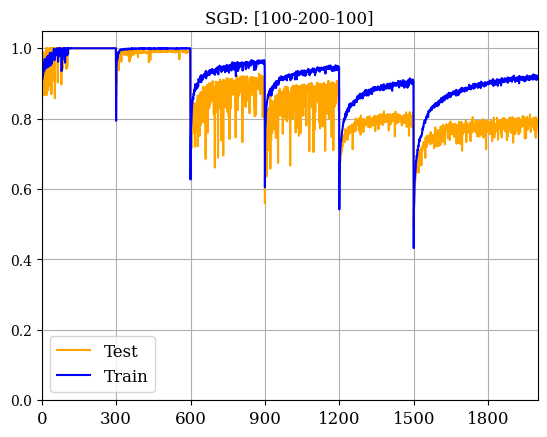

In [ ]:
graph_accu('SGD')

Curriculum:06 Batchsize:{batchsize}
last epoch: 2000
Training Loss: 20.38%
Testing Loss: 109.41%


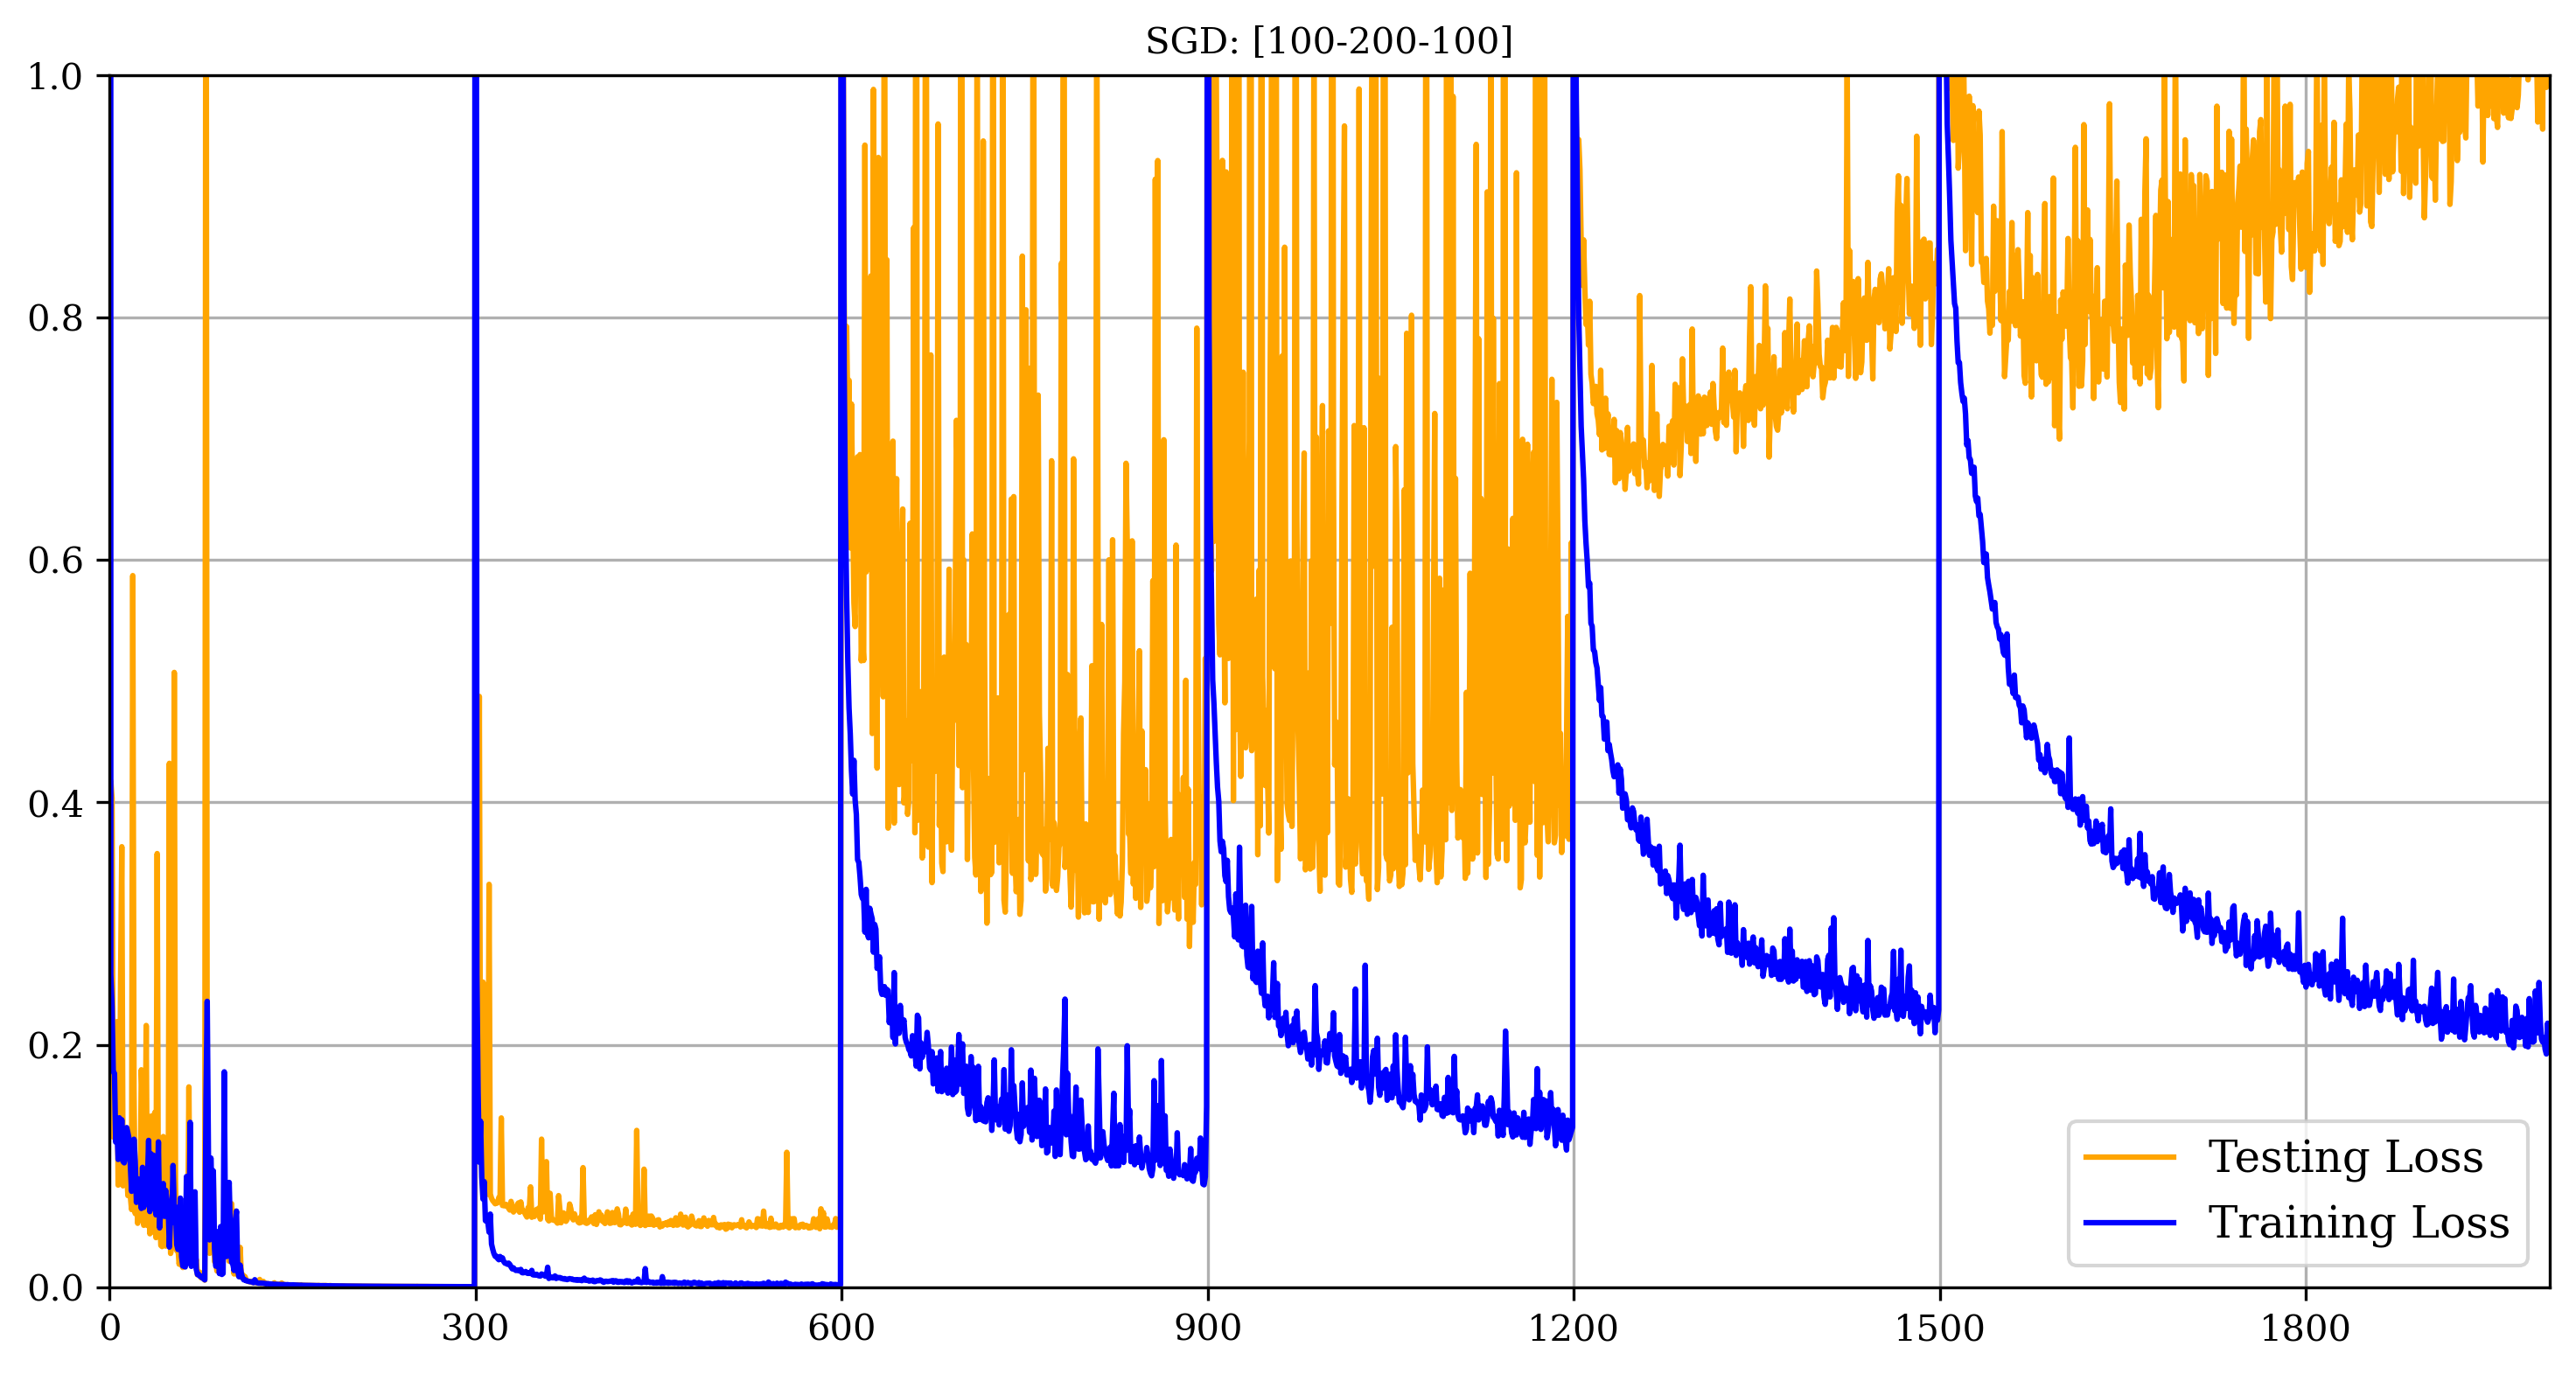

In [ ]:
graph_loss('SGD')

In [ ]:
model = MLP1L()

learning_rate = 1e-3
#Set minibatch size
batchsize = 64 #64  1-8 #128 8-32
#epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = True

resume1 = True
#Set resume1 to False if you want to continue using main directory
#Set resume1 to True if you want to resume using snapshot directory

resume2 = False
#Set resume2 to True if you want to continue using PREVIOUS CURRICULUM snapshot directory
#Set resume2 to False otherwise

#Which last epoch would you like to continue?
last_epoch = 1920 #31070 #31050

#For resume=False. If you want to initialize weights (I am not sure if this is truly effective)
initialize = True

#Set maximum epoch of the full training
max_epoch = 2000 #- last_epoch #3200 - last_epoch
#Set maximum repetitions during epoch restart
max_rep = 200
#Set accuracy drop tolerance to execute epoch restart
max_drop_tolerance = -0.5
#mid_drop_tolerance = -0.05
min_drop_tolerance = -0.01 #-0.005 #-0.5 #-0.005 #set to -0.5 for first ten epoch of new curriculum
#margin_tolerance = 0.1
#Save model and state every save_epoch
save_epoch = 5

#Choose your DNN model
#dnn1 = MLP1L() #CustomMLP(2,[200,100])

#local directory and file name of training and testing curriculum dataset
#trainset = 'curriculum_trainset//chainer_train_curr{:02d}.pkl'.format(curriculum)
#testset = 'curriculum_testset//chainer_test_curr{:02d}.pkl'.format(curriculum)
curriculum_folder = 'curriculum{:02d}_training'.format(curriculum)
#trainset = os.path.join(curriculum_folder, 'chainer_train_curr{:02d}.pkl'.format(curriculum))
#testset = os.path.join(curriculum_folder, 'chainer_test_curr{:02d}.pkl'.format(curriculum))

#Continuous training directory
directory1 = f'Adam_200_200_curr{curriculum:02d}_full'
#Snapshot directory (save models every save_epoch)
directory2 = f'Adam_200_200_curr{curriculum:02d}_snapshot'

#gpu_id = 0

#Load previous training results from the snapshot folder
prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum - 1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'Adam_200_200_curr{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_accu1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

train_dnn(train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:001921 done. Time elapsed:0.367709 sec.
Epoch:001922 done. Time elapsed:0.689709 sec.
Epoch:001923 done. Time elapsed:1.028841 sec.
Epoch:001924 done. Time elapsed:1.342845 sec.
Epoch:001925 done. Time elapsed:1.654844 sec.
Epoch:001926 done. Time elapsed:2.039341 sec.
Epoch:001927 done. Time elapsed:2.367610 sec.
Epoch:001928 done. Time elapsed:2.697610 sec.
Epoch:001929 done. Time elapsed:3.027610 sec.
Epoch:001930 done. Time elapsed:3.348613 sec.
Epoch:001931 done. Time elapsed:3.717302 sec.
Epoch:001932 done. Time elapsed:4.061302 sec.
Epoch:001933 done. Time elapsed:4.384302 sec.
001: Restarting...
Epoch:001933 done. Time elapsed:4.765303 sec.
Epoch:001934 done. Time elapsed:5.118304 sec.
Epoch:001935 done. Time elapsed:5.444303 sec.
Epoch:001936 done. Time elapsed:5.834302 sec.
001: Restarting...
Epoch:001936 done. Time elapsed:6.208303 sec.
002: Restarting...
Epoch:001936 done. Time elapsed:6.579627 sec.
Epoch:001937 done. Time elapsed:6.903624 sec.
001: Restarting...
Epoc

Curriculum:06 Batchsize:{batchsize}
last epoch: 2000
Training Accuracy: 83.47%
Testing Accuracy: 72.94%


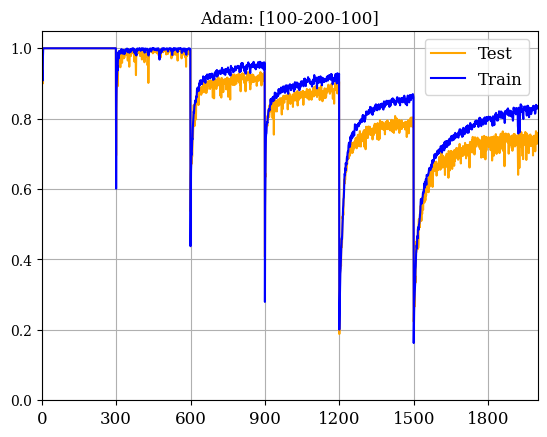

In [ ]:
graph_accu('Adam')

In [ ]:
graph_loss('Adam')

TypeError: graph_loss() missing 1 required positional argument: 'out'